In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision

ex_close_data = torch.load("ex_close_features.pt")
sd_close_data = torch.load("sd_close_features.pt")

sd7_close = sd_close_data["sd7_close"]
sd10_close = sd_close_data["sd10_close"]
sd10_close_paths = sd_close_data["sd10_close_paths"]

ex7_close = ex_close_data["ex7_close"]
ex10_close = ex_close_data["ex10_close"]
ex10_close_paths = ex_close_data["ex10_close_paths"]

In [2]:
# Load training features
cond7 = torch.load('combined_cond7.pt')
cond10 = torch.load('combined_cond10.pt')

#cond7 = torch.load('allaug_cond7.pt')
#cond10 = torch.load('allaug_cond10.pt')

# Load training features
ex7 = torch.load('combined_ex7.pt')
ex10 = torch.load('combined_ex10.pt')
# Load training features
sd7 = torch.load('combined_sd7.pt')
sd10 = torch.load('combined_sd10.pt')

C:\Users\k54739\AppData\Local\Temp\ipykernel_9032\1356295445.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cond7 = torch.load('combined_cond7.pt')
C:\Users\k54739\AppD

In [3]:
print(sd7.shape)
print(sd10.shape)

print(ex7.shape)
print(ex10.shape)

torch.Size([638, 512])
torch.Size([638, 512])
torch.Size([646, 512])
torch.Size([646, 512])




combined_sd7_numpy = combined_sd7.numpy()
combined_sd10_numpy = combined_sd10.numpy()

print(combined_sd7.shape)
print(combined_sd10.shape)


cond_7_numpy = cond_7.numpy()
cond_10_numpy = cond_10.numpy()

cond_7.shape





ex7_numpy = ex7.numpy()
ex10_numpy = ex10.numpy()


print(ex7.shape)
print(ex10.shape)




sd7_numpy = sd7.numpy()
sd10_numpy = sd10.numpy()


In [4]:
import joblib
# Load the scalers from disk
scaler_day7 = joblib.load('ex7.pkl')
scaler_day10 = joblib.load('ex10.pkl')

print("Scalers loaded!")

Scalers loaded!


print(sd7.shape)
print(sd10.shape)

import joblib
# Load the scalers from disk
scaler_day7 = joblib.load('sd7.pkl')
scaler_day10 = joblib.load('sd10.pkl')

print("Scalers loaded!")

import joblib
# Load the scalers from disk
scaler_day7 = joblib.load('scaler_cond7.pkl')
scaler_day10 = joblib.load('scaler_cond10.pkl')

print("Scalers loaded!")

combined_sd7_numpy = scaler_day7.transform(combined_sd7_numpy)
combined_sd10_numpy = scaler_day10.transform(combined_sd10_numpy)

combined_sd7_minmax = torch.tensor(combined_sd7_numpy)
combined_sd10_minmax = torch.tensor(combined_sd10_numpy)

cond_7_numpy = scaler_day7.transform(cond_7_numpy)
cond_10_numpy = scaler_day10.transform(cond_10_numpy)

cond7_minmax = torch.tensor(cond_7_numpy)
cond10_minmax = torch.tensor(cond_10_numpy)

ex7_numpy = scaler_day7.transform(ex7_numpy)
ex10_numpy = scaler_day10.transform(ex10_numpy)

ex7_minmax = torch.tensor(ex7_numpy)
ex10_minmax = torch.tensor(ex10_numpy)


sd7_numpy = scaler_day7.transform(sd7_numpy)
sd10_numpy = scaler_day10.transform(sd10_numpy)

sd7_minmax = torch.tensor(sd7_numpy)
sd10_minmax = torch.tensor(sd10_numpy)

In [5]:
import torch
from sklearn.preprocessing import MinMaxScaler

def scale_tensor(scaler, tensor):
    """
    Scales a tensor using the provided MinMaxScaler.

    Args:
        scaler (MinMaxScaler): The MinMaxScaler to use for scaling.
        tensor (torch.Tensor): The tensor to scale.

    Returns:
        torch.Tensor: The scaled tensor.
    """
    tensor_numpy = tensor.numpy()  # Convert tensor to numpy
    tensor_scaled_numpy = scaler.transform(tensor_numpy)  # Apply Min-Max scaling
    tensor_scaled = torch.tensor(tensor_scaled_numpy)  # Convert back to torch tensor
    return tensor_scaled




In [6]:
# Example usage for different datasets


cond7_minmax = scale_tensor(scaler_day7, cond7)
cond10_minmax = scale_tensor(scaler_day10, cond10)

ex7_minmax = scale_tensor(scaler_day7, ex7)
ex10_minmax = scale_tensor(scaler_day10, ex10)

sd7_minmax = scale_tensor(scaler_day7, sd7)
sd10_minmax = scale_tensor(scaler_day10, sd10)

sd7_close_minmax = scale_tensor(scaler_day7, sd7_close)
sd10_close_minmax = scale_tensor(scaler_day10, sd10_close)

ex7_close_minmax = scale_tensor(scaler_day7, ex7_close)
ex10_close_minmax = scale_tensor(scaler_day10, ex10_close)

In [7]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    # Corrected indentation for forward method
    def forward(self, x):
        x = self.encoder(x)
        z = self.decoder(x)
        return z

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [9]:
# Define the directory where models are saved
#load_dir = r'C:\Users\k54739\saved_model\ranking\simclr\minmax_scaled'

# Load a specific fold's best model
model = FeaturePredictor()
load_path = os.path.join('bestmodel_ex_6.pth')
model.load_state_dict(torch.load(load_path))
model.to(device)
model.eval()

print(f"Loaded model from {load_path}")

Loaded model from bestmodel_ex_6.pth


C:\Users\k54739\AppData\Local\Temp\ipykernel_9032\3892184749.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(load_path))


# all metrics added:

In [ ]:
# sd close

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = sd7_close_minmax.to(device)
train_day10_feats_minmaxed = sd10_close_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_sd_close.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


In [ ]:
# ex_close

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = ex7_close_minmax.to(device)
train_day10_feats_minmaxed = ex10_close_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "FeatNorm_all_metrics_ex_close.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


In [10]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = sd7_minmax.to(device)
train_day10_feats_minmaxed = sd10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 0.5055
Euclidean Distance: 16.0885
Cosine Distance: 0.7969
L1 Distance: 232.0012
Pearson Correlation: -0.2073
Dot Product: 25.1162
Jaccard Similarity: 0.0708
Hamming Distance: 210.0000
Mahalanobis Distance: 3612.2024


In [11]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "exnorm_sd.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to exnorm_sd.csv


In [12]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = cond7_minmax.to(device)
train_day10_feats_minmaxed = cond10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)


# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 1.4135
Euclidean Distance: 26.9018
Cosine Distance: 0.8610
L1 Distance: 241.9509
Pearson Correlation: -0.1123
Dot Product: 30.7883
Jaccard Similarity: 0.0933
Hamming Distance: 175.0000
Mahalanobis Distance: 594.2561


In [13]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "exnorm_cond.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to exnorm_cond.csv


In [1]:
# ex

In [14]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Assume exploded40_day7_minmaxed and exploded40_day10_minmaxed are already loaded
# Example shapes: [N, 512], where N is the number of feature vectors

# Ensure the tensors are on the same device as the model
train_day7_feats_minmaxed = ex7_minmax.to(device)
train_day10_feats_minmaxed = ex10_minmax.to(device)

# Initialize the MSE loss function
mse_loss_fn = nn.MSELoss()

# Lists to store metrics for each feature vector
mse_values = []
euclidean_distances = []
cosine_distances = []
l1_distances = []
pearson_correlations = []
dot_products = []
jaccard_similarities = []
hamming_distances = []
mahalanobis_distances = []

# Compute covariance matrix for Mahalanobis distance (for day10 features)
epsilon = 1e-6  # Stabilization constant for invertibility
mean_vector = torch.mean(train_day10_feats_minmaxed, dim=0)  # Mean vector
covariance_matrix = torch.cov(train_day10_feats_minmaxed.T)  # Covariance matrix
covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Loop through each feature vector
# Loop through each feature vector
for i in range(train_day7_feats_minmaxed.shape[0]):
    train_day7_feats = train_day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    train_day10_feats = train_day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
    
    # Get prediction
    with torch.no_grad():
        predicted_day10 = model(train_day7_feats)
    
    # Compute MSE for this feature vector
    mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
    mse_values.append(mse)
    
    # Compute Euclidean distance
    euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
    euclidean_distances.append(euclidean_distance)
    
    # Compute Cosine distance
    cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
    cosine_distances.append(cosine_distance)
    
    # Compute L1 distance
    l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
    l1_distances.append(l1_distance)
    
    # Compute Pearson Correlation
    combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
    pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
    pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
    pearson_correlations.append(pearson_corr.item())
    
    # Compute Inner Product (Dot Product)
    dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
    dot_products.append(dot_product)
    
    # Compute Jaccard Similarity (thresholding features to binary)
    bin_pred = (predicted_day10.flatten() > 0.5).int()
    bin_true = (train_day10_feats.flatten() > 0.5).int()
    intersection = (bin_pred & bin_true).sum().item()
    union = (bin_pred | bin_true).sum().item()
    jaccard_similarity = intersection / union if union > 0 else 0
    jaccard_similarities.append(jaccard_similarity)
    
    # Compute Hamming Distance (binary representation)
    hamming_distance = (bin_pred != bin_true).sum().item()
    hamming_distances.append(hamming_distance)
    
    # Compute Mahalanobis Distance
    delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
    mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
    mahalanobis_distances.append(mahalanobis_distance)

# Print some example metrics for the first feature vector
print(f"Example metrics for the first feature vector:")
print(f"MSE: {mse_values[0]:.4f}")
print(f"Euclidean Distance: {euclidean_distances[0]:.4f}")
print(f"Cosine Distance: {cosine_distances[0]:.4f}")
print(f"L1 Distance: {l1_distances[0]:.4f}")
print(f"Pearson Correlation: {pearson_correlations[0]:.4f}")
print(f"Dot Product: {dot_products[0]:.4f}")
print(f"Jaccard Similarity: {jaccard_similarities[0]:.4f}")
print(f"Hamming Distance: {hamming_distances[0]:.4f}")
print(f"Mahalanobis Distance: {mahalanobis_distances[0]:.4f}")


Example metrics for the first feature vector:
MSE: 0.0057
Euclidean Distance: 1.7009
Cosine Distance: 0.0158
L1 Distance: 28.6740
Pearson Correlation: 0.9756
Dot Product: 59.7240
Jaccard Similarity: 0.6991
Hamming Distance: 34.0000
Mahalanobis Distance: 113.0463


In [15]:
import pandas as pd

# Create a DataFrame with all the metrics
data = {
    "MSE": mse_values,  # List of MSE values
    "Euclidean Distance": euclidean_distances,  # List of Euclidean distances
    "Cosine Distance": cosine_distances,  # List of Cosine distances
    "L1 Distance": l1_distances,  # List of L1 distances
    "Pearson Correlation": pearson_correlations,  # List of Pearson correlation values
    "Dot Product": dot_products,  # List of dot product values
    "Jaccard Similarity": jaccard_similarities,  # List of Jaccard similarities
    "Hamming Distance": hamming_distances,  # List of Hamming distances
    "Mahalanobis Distance": mahalanobis_distances  # List of Mahalanobis distances
}

# Convert the data dictionary into a DataFrame
df = pd.DataFrame(data)

# Specify the desired name for the CSV file
csv_file_name = "exnorm_ex.csv"  # Replace this with your desired file name

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)  # Save without an index column
print(f"All metrics saved to {csv_file_name}")


All metrics saved to exnorm_ex.csv


In [2]:
#sd

In [ ]:
# plot

import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("FeatNorm_all_metrics_ex.csv"),
    "sd": pd.read_csv("FeatNorm_all_metrics_sd.csv"),
    "control": pd.read_csv("FeatNorm_all_metrics_control.csv"),
    "sd_close": pd.read_csv("FeatNorm_all_metrics_sd_close.csv"),
    "ex_close": pd.read_csv("FeatNorm_all_metrics_ex_close.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green", "sd_close": "red", "ex_close": "lime"}
#hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                #hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [ ]:
# sd_close is not close to sd maybe its because training is overfitted. 

import pandas as pd
df = pd.read_csv("all_metrics_combined_sd.csv")
df.shape

import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("allaugcond_ex.csv"),
    "sd": pd.read_csv("allaugcond_sd.csv"),
    "control": pd.read_csv("allaug_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [16]:
import pandas as pd
import numpy as np

# Load datasets
datasets = {
    "explod": pd.read_csv("exnorm_ex.csv"),
    "sd": pd.read_csv("exnorm_sd.csv"),
    "control": pd.read_csv("exnorm_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Accuracy calculation function
def calculate_accuracy(datasets, metric_name):
    # Step 1: Calculate mean inference metric for each class
    class_means = {}
    for class_name, df in datasets.items():
        if metric_name in df.columns:
            class_means[class_name] = df[metric_name].mean()

    # Sort class means to find the middle class
    sorted_means = sorted(class_means.items(), key=lambda x: x[1])
    middle_class = sorted_means[1][0]  # The middle class is the second one in sorted order
    middle_class_mean = sorted_means[1][1]

    # Step 2: Find the min and max for the middle class
    middle_class_min = datasets[middle_class][metric_name].min()
    middle_class_max = datasets[middle_class][metric_name].max()

    # Step 3: Calculate errors
    error_1 = sum(datasets[sorted_means[0][0]][metric_name] > middle_class_min)
    error_3 = sum(datasets[sorted_means[2][0]][metric_name] < middle_class_max)
    total_errors = error_1 + error_3

    # Step 4: Calculate accuracy
    total_points = sum(len(df) for df in datasets.values())
    accuracy = (total_points - total_errors) / total_points

    # Print results
    print(f"Metric: {metric_name}")
    print(f"  Class Means: {class_means}")
    print(f"  Middle Class: {middle_class} (Mean: {middle_class_mean})")
    print(f"  Middle Class Min: {middle_class_min}, Max: {middle_class_max}")
    print(f"  Errors (C1 > min): {error_1}, Errors (C3 < max): {error_3}")
    print(f"  Total Errors: {total_errors}")
    print(f"  Accuracy: {accuracy:.4f}\n")

    return accuracy

# Calculate and print accuracy for each metric
results = {}
for metric in metrics:
    results[metric] = calculate_accuracy(datasets, metric)

# Summary of accuracies
print("\nSummary of Accuracies:")
for metric, acc in results.items():
    print(f"{metric}: {acc:.4f}")


Metric: MSE
  Class Means: {'explod': 0.010888559963887845, 'sd': 0.8362640041776211, 'control': 3.4787796889130886}
  Middle Class: sd (Mean: 0.8362640041776211)
  Middle Class Min: 0.2433385103940963, Max: 6.525444507598877
  Errors (C1 > min): 0, Errors (C3 < max): 604
  Total Errors: 604
  Accuracy: 0.6877

Metric: Euclidean Distance
  Class Means: {'explod': 2.133399206049302, 'sd': 19.342920170308656, 'control': 30.04926205414992}
  Middle Class: sd (Mean: 19.342920170308656)
  Middle Class Min: 11.161958694458008, Max: 57.8016242980957
  Errors (C1 > min): 0, Errors (C3 < max): 604
  Total Errors: 604
  Accuracy: 0.6877

Metric: Cosine Distance
  Class Means: {'explod': 0.04988483083506482, 'sd': 0.7483849012319197, 'control': 0.7338804119194929}
  Middle Class: control (Mean: 0.7338804119194929)
  Middle Class Min: 0.143848180770874, Max: 0.9750649109482764
  Errors (C1 > min): 54, Errors (C3 < max): 638
  Total Errors: 692
  Accuracy: 0.6422

Metric: L1 Distance
  Class Means:

In [16]:
import pandas as pd
import numpy as np

# Load datasets
datasets = {
    "explod": pd.read_csv("sd_ex.csv"),
    "sd": pd.read_csv("sd_sd.csv"),
    "control": pd.read_csv("sd_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE", 
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Accuracy calculation function
def calculate_accuracy(datasets, metric_name):
    # Step 1: Calculate mean inference metric for each class
    class_means = {}
    for class_name, df in datasets.items():
        if metric_name in df.columns:
            class_means[class_name] = df[metric_name].mean()

    # Sort class means to find the middle class
    sorted_means = sorted(class_means.items(), key=lambda x: x[1])
    middle_class = sorted_means[1][0]  # The middle class is the second one in sorted order
    middle_class_mean = sorted_means[1][1]

    # Step 2: Find the min and max for the middle class
    middle_class_min = datasets[middle_class][metric_name].min()
    middle_class_max = datasets[middle_class][metric_name].max()

    # Step 3: Calculate errors
    error_1 = sum(datasets[sorted_means[0][0]][metric_name] > middle_class_min)
    error_3 = sum(datasets[sorted_means[2][0]][metric_name] < middle_class_max)
    total_errors = error_1 + error_3

    # Step 4: Calculate accuracy
    total_points = sum(len(df) for df in datasets.values())
    accuracy = (total_points - total_errors) / total_points

    # Print results
    print(f"Metric: {metric_name}")
    print(f"  Class Means: {class_means}")
    print(f"  Middle Class: {middle_class} (Mean: {middle_class_mean})")
    print(f"  Middle Class Min: {middle_class_min}, Max: {middle_class_max}")
    print(f"  Errors (C1 > min): {error_1}, Errors (C3 < max): {error_3}")
    print(f"  Total Errors: {total_errors}")
    print(f"  Accuracy: {accuracy:.4f}\n")

    return accuracy

# Calculate and print accuracy for each metric
results = {}
for metric in metrics:
    results[metric] = calculate_accuracy(datasets, metric)

# Summary of accuracies
print("\nSummary of Accuracies:")
for metric, acc in results.items():
    print(f"{metric}: {acc:.4f}")


Metric: MSE
  Class Means: {'explod': 11917.964235515343, 'sd': 0.029156228170954927, 'control': 5169.131663065942}
  Middle Class: control (Mean: 5169.131663065942)
  Middle Class Min: 0.1524088382720947, Max: 249848.609375
  Errors (C1 > min): 0, Errors (C3 < max): 190
  Total Errors: 190
  Accuracy: 0.8071

Metric: Euclidean Distance
  Class Means: {'explod': 1833.466118631865, 'sd': 3.71584435495837, 'control': 846.4470769662123}
  Middle Class: control (Mean: 846.4470769662123)
  Middle Class Min: 8.833647727966309, Max: 11310.2822265625
  Errors (C1 > min): 0, Errors (C3 < max): 190
  Total Errors: 190
  Accuracy: 0.8071

Metric: Cosine Distance
  Class Means: {'explod': 0.9516293283554995, 'sd': 0.10760305996598864, 'control': 0.9536384321228923}
  Middle Class: explod (Mean: 0.9516293283554995)
  Middle Class Min: 0.6827549338340759, Max: 1.0371989533305168
  Errors (C1 > min): 0, Errors (C3 < max): 650
  Total Errors: 650
  Accuracy: 0.3401

Metric: L1 Distance
  Class Means: 

In [33]:
import pandas as pd
import numpy as np

# Load datasets
datasets = {
    "explod": pd.read_csv("10fold_ex.csv"),
    "sd": pd.read_csv("10fold_sd.csv"),
    "control": pd.read_csv("10fold_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Accuracy calculation function
def calculate_accuracy(datasets, metric_name):
    # Step 1: Calculate mean inference metric for each class
    class_means = {}
    for class_name, df in datasets.items():
        if metric_name in df.columns:
            class_means[class_name] = df[metric_name].mean()

    # Sort class means to find the middle class
    sorted_means = sorted(class_means.items(), key=lambda x: x[1])
    middle_class = sorted_means[1][0]  # The middle class is the second one in sorted order
    middle_class_mean = sorted_means[1][1]

    # Step 2: Find the min and max for the middle class
    middle_class_min = datasets[middle_class][metric_name].min()
    middle_class_max = datasets[middle_class][metric_name].max()

    # Step 3: Calculate errors
    error_1 = sum(datasets[sorted_means[0][0]][metric_name] > middle_class_min)
    error_3 = sum(datasets[sorted_means[2][0]][metric_name] < middle_class_max)
    total_errors = error_1 + error_3

    # Step 4: Calculate accuracy
    total_points = sum(len(df) for df in datasets.values())
    accuracy = (total_points - total_errors) / total_points

    # Print results
    print(f"Metric: {metric_name}")
    print(f"  Class Means: {class_means}")
    print(f"  Middle Class: {middle_class} (Mean: {middle_class_mean})")
    print(f"  Middle Class Min: {middle_class_min}, Max: {middle_class_max}")
    print(f"  Errors (C1 > min): {error_1}, Errors (C3 < max): {error_3}")
    print(f"  Total Errors: {total_errors}")
    print(f"  Accuracy: {accuracy:.4f}\n")

    return accuracy

# Calculate and print accuracy for each metric
results = {}
for metric in metrics:
    results[metric] = calculate_accuracy(datasets, metric)

# Summary of accuracies
print("\nSummary of Accuracies:")
for metric, acc in results.items():
    print(f"{metric}: {acc:.4f}")


Metric: MSE
  Class Means: {'explod': 0.06849374769157482, 'sd': 0.098180710190329, 'control': 0.017481411278892547}
  Middle Class: explod (Mean: 0.06849374769157482)
  Middle Class Min: 0.011244898661971, Max: 0.1616832166910171
  Errors (C1 > min): 396, Errors (C3 < max): 143
  Total Errors: 539
  Accuracy: 0.4528

Metric: Euclidean Distance
  Class Means: {'explod': 5.749489638679906, 'sd': 7.038515482277706, 'control': 2.8234088795918684}
  Middle Class: explod (Mean: 5.749489638679906)
  Middle Class Min: 2.3994557857513428, Max: 9.098450660705566
  Errors (C1 > min): 396, Errors (C3 < max): 143
  Total Errors: 539
  Accuracy: 0.4528

Metric: Cosine Distance
  Class Means: {'explod': 0.413492751592084, 'sd': 0.5213821953740613, 'control': 0.10427091451791612}
  Middle Class: explod (Mean: 0.413492751592084)
  Middle Class Min: 0.0894885659217834, Max: 0.6994228363037109
  Errors (C1 > min): 303, Errors (C3 < max): 145
  Total Errors: 448
  Accuracy: 0.5452

Metric: L1 Distance
  

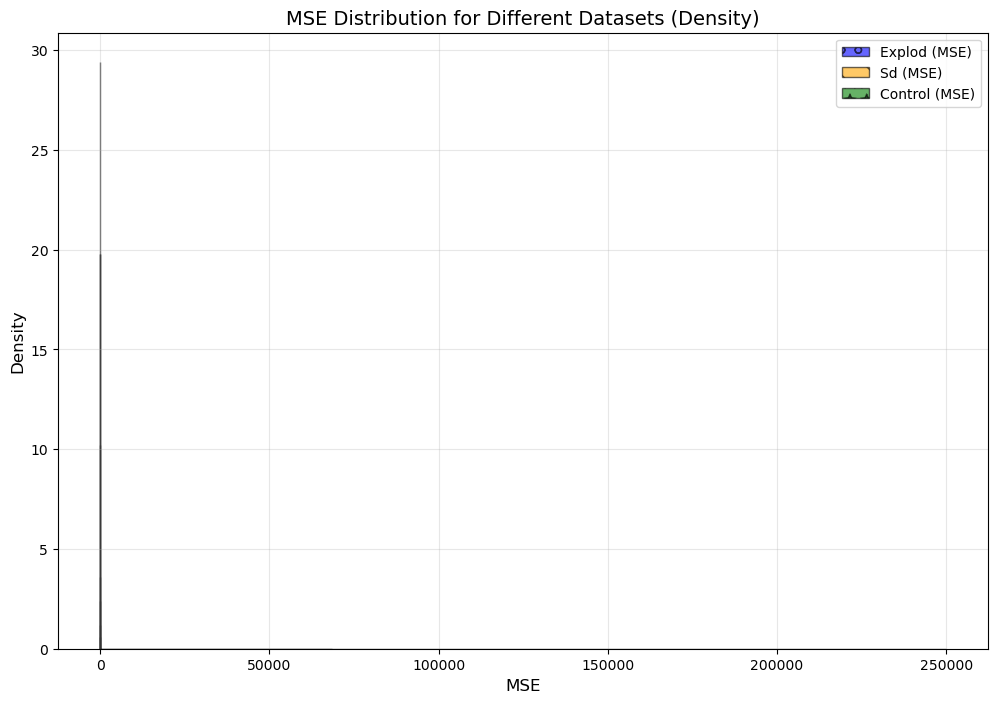

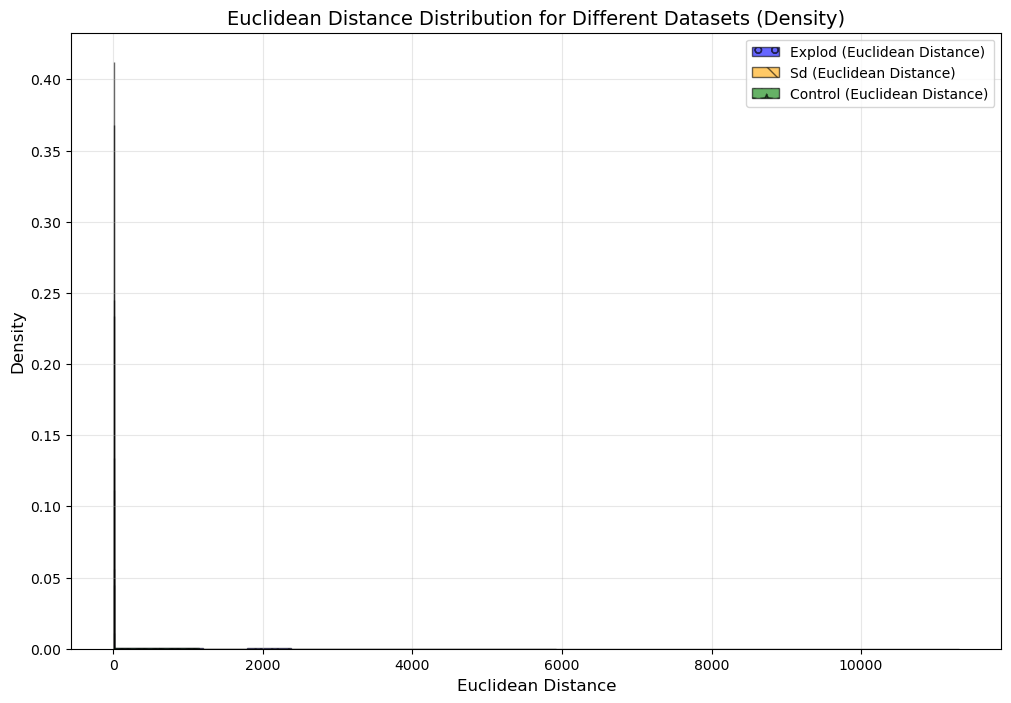

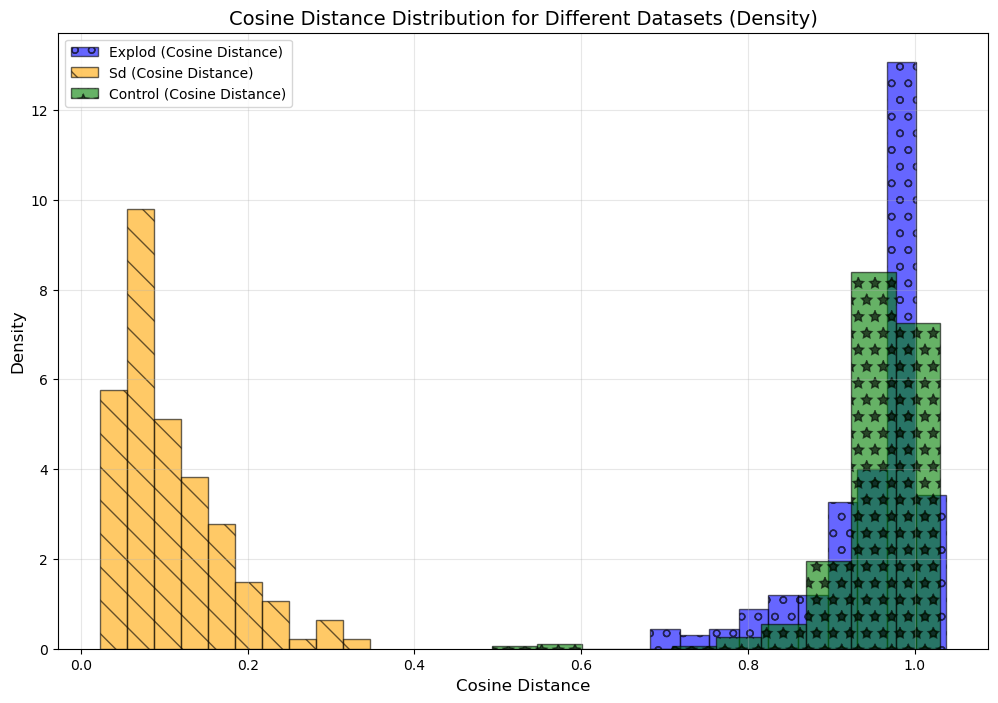

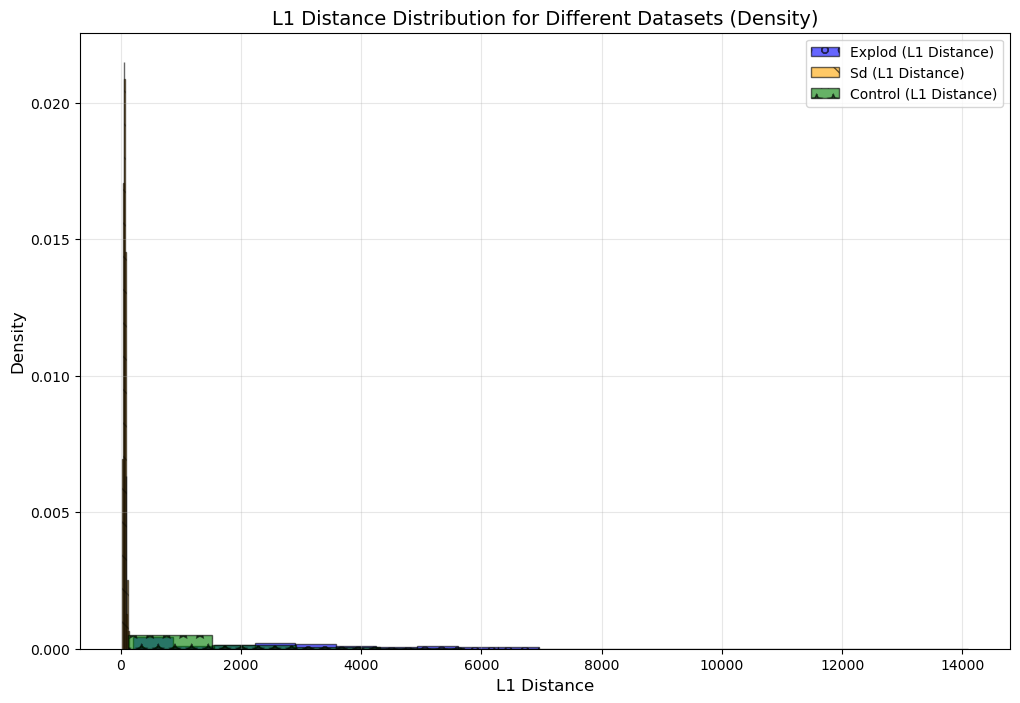

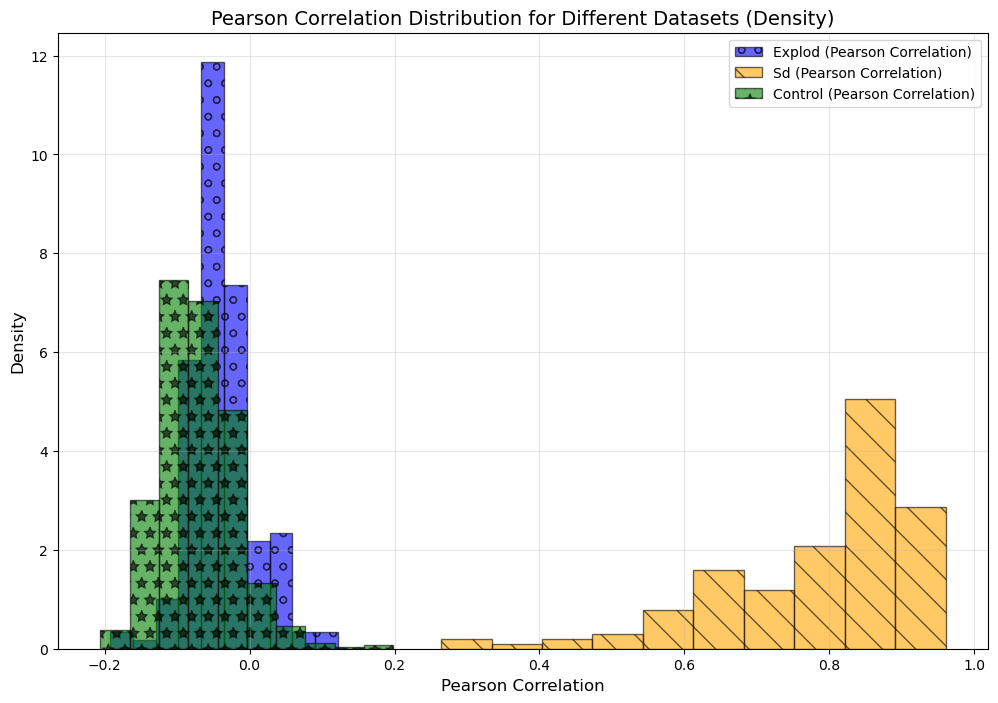

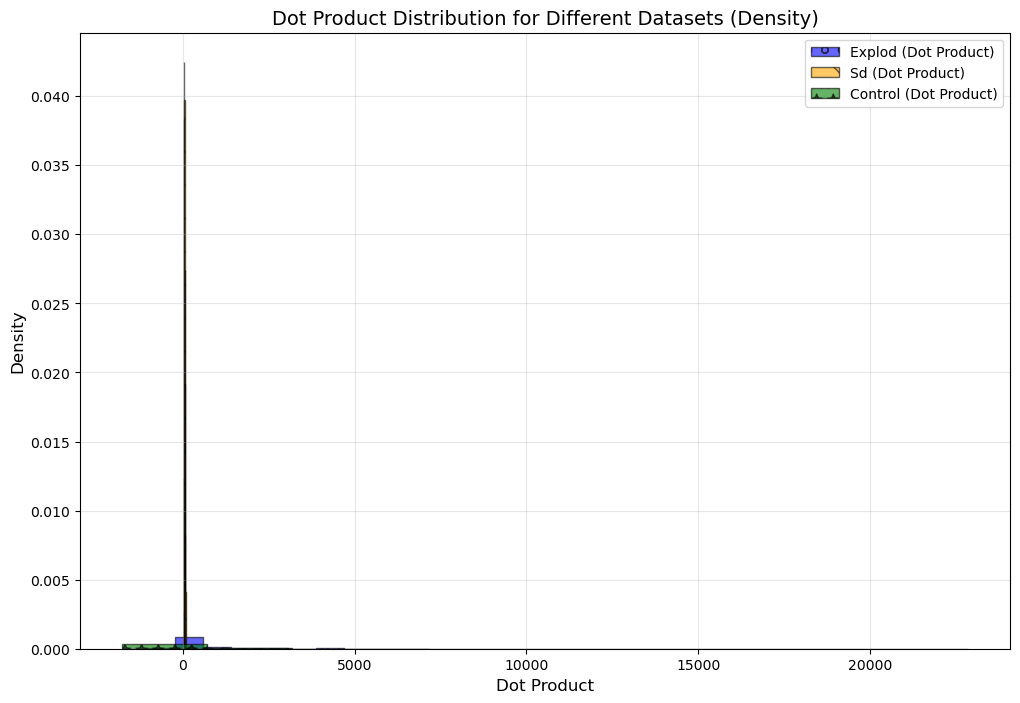

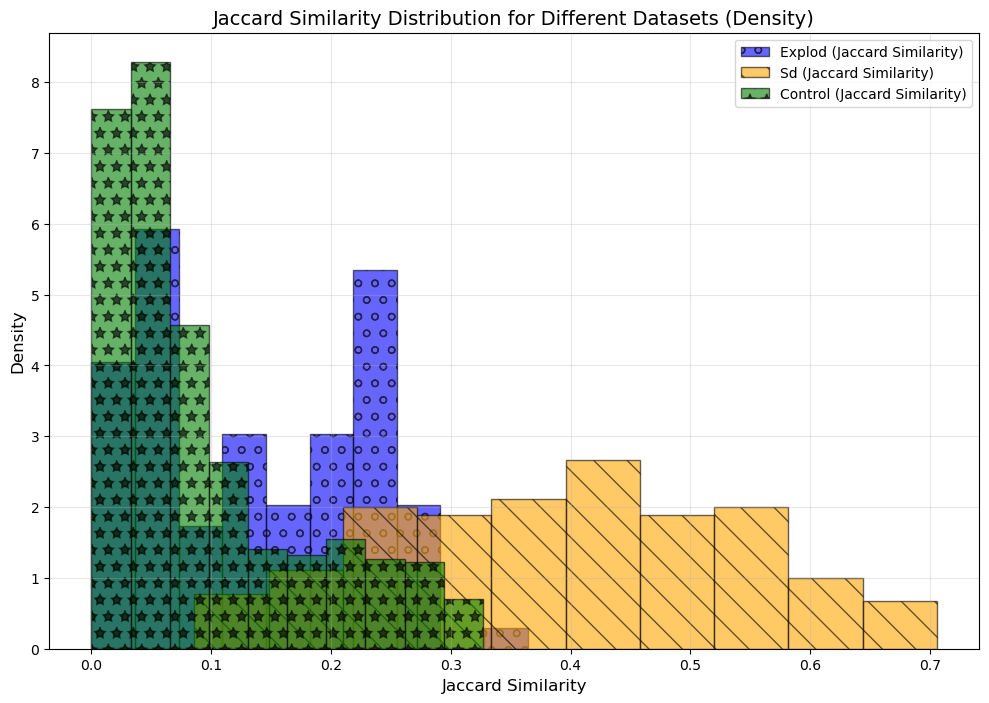

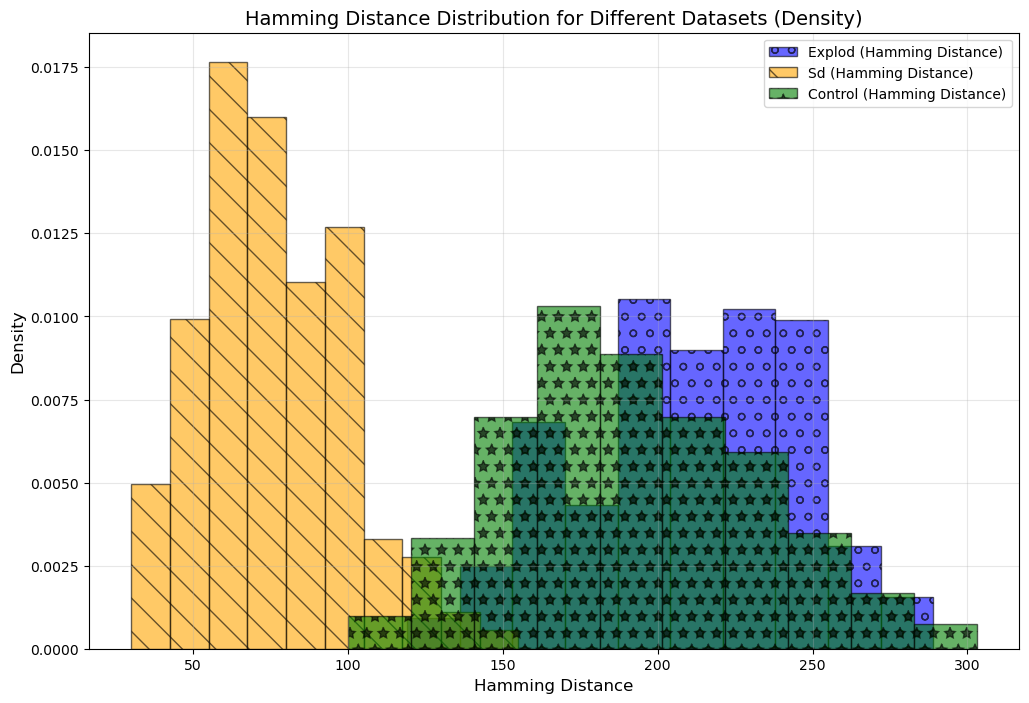

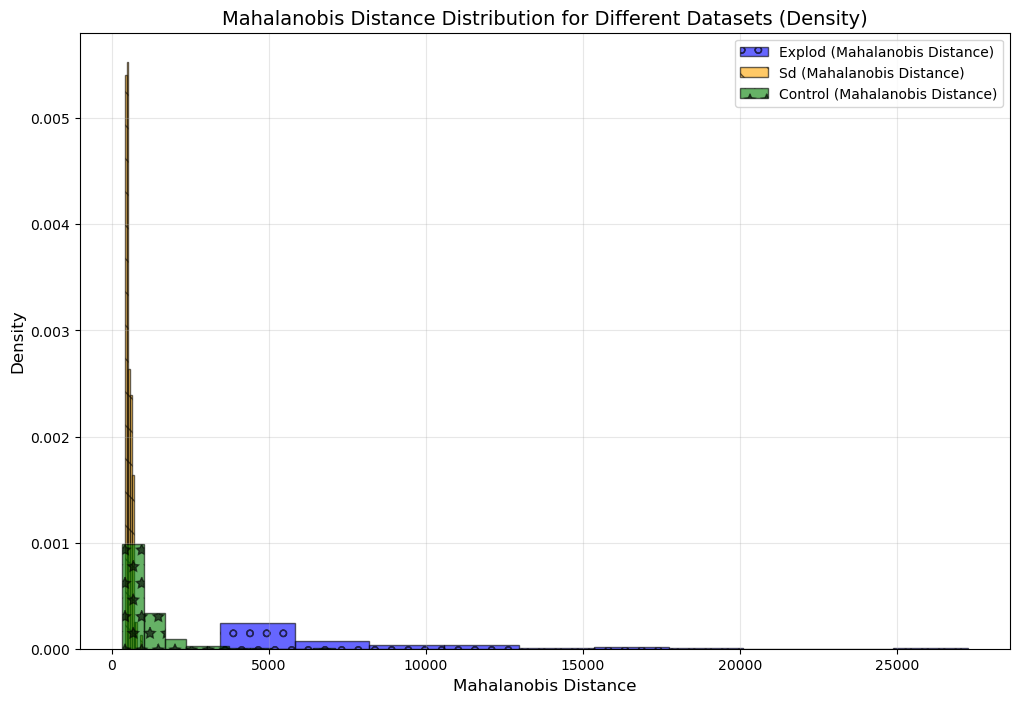

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("sd_ex.csv"),
    "sd": pd.read_csv("sd_sd.csv"),
    "control": pd.read_csv("sd_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black",
                density=True  # Normalize to density
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets (Density)", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


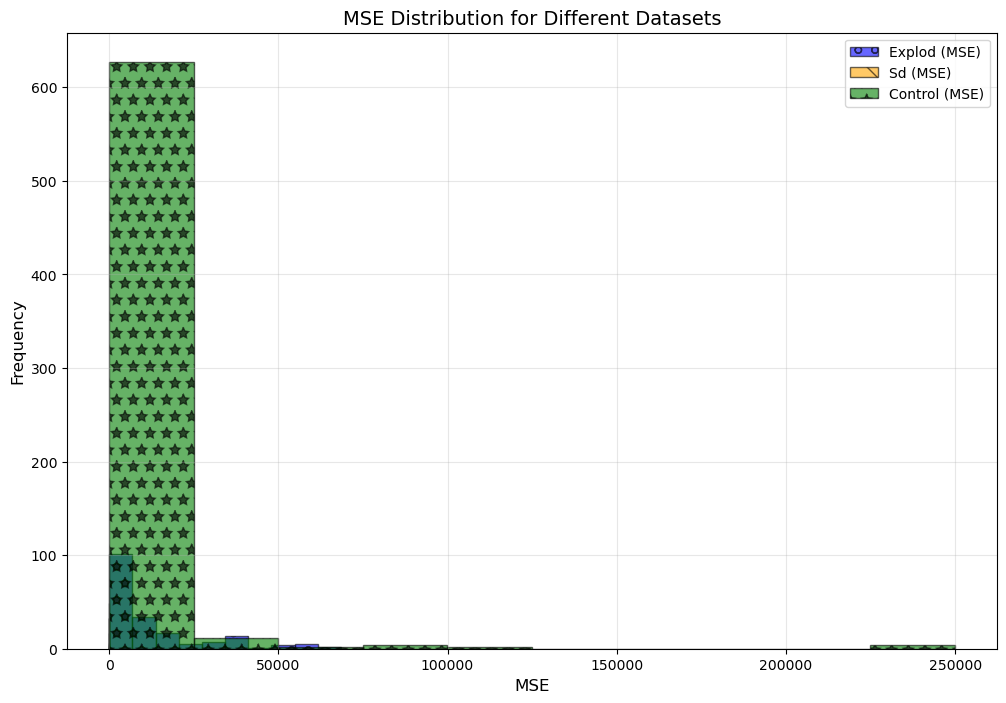

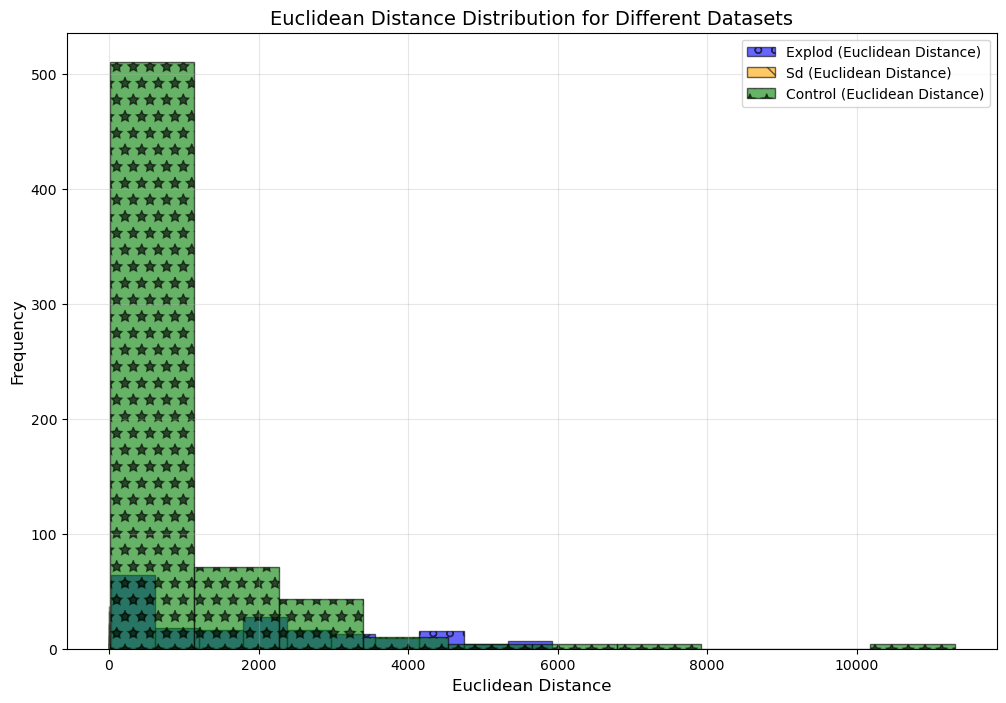

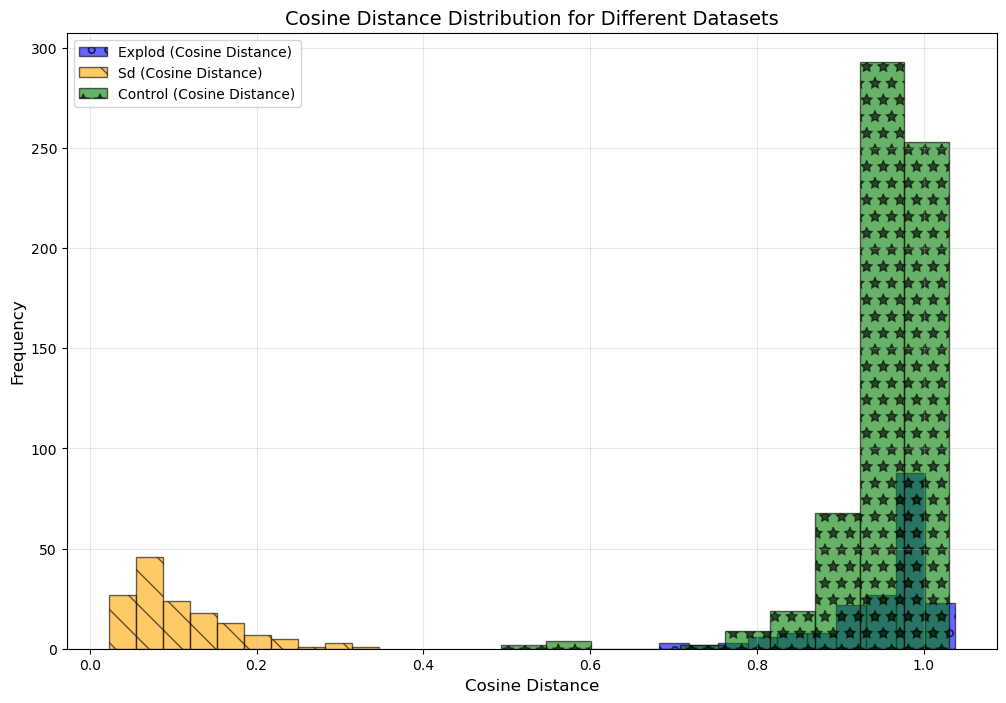

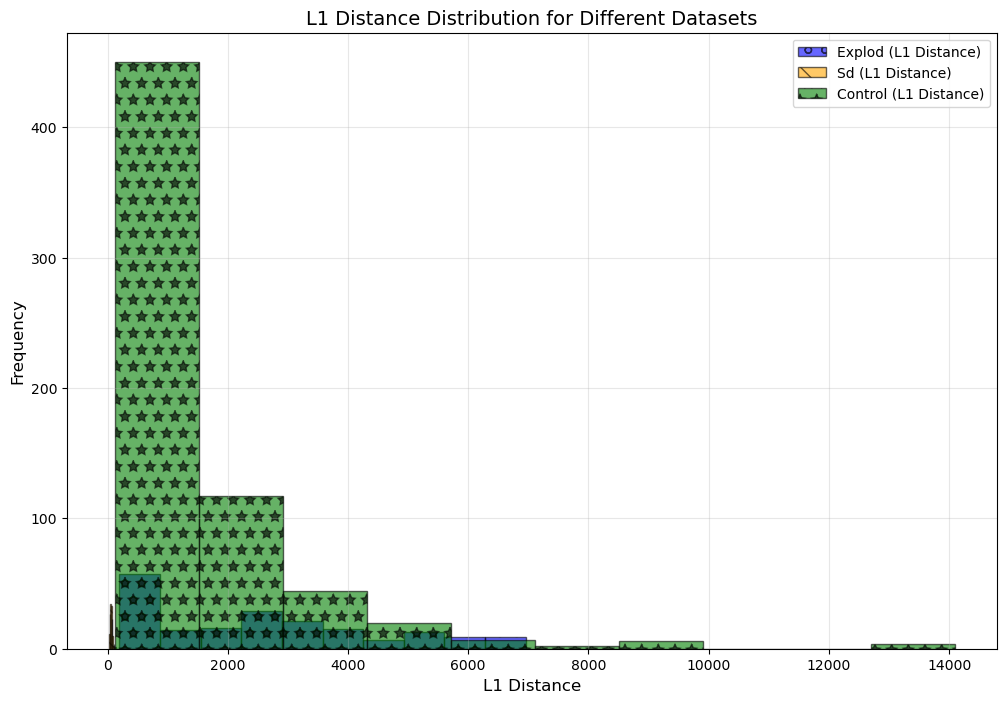

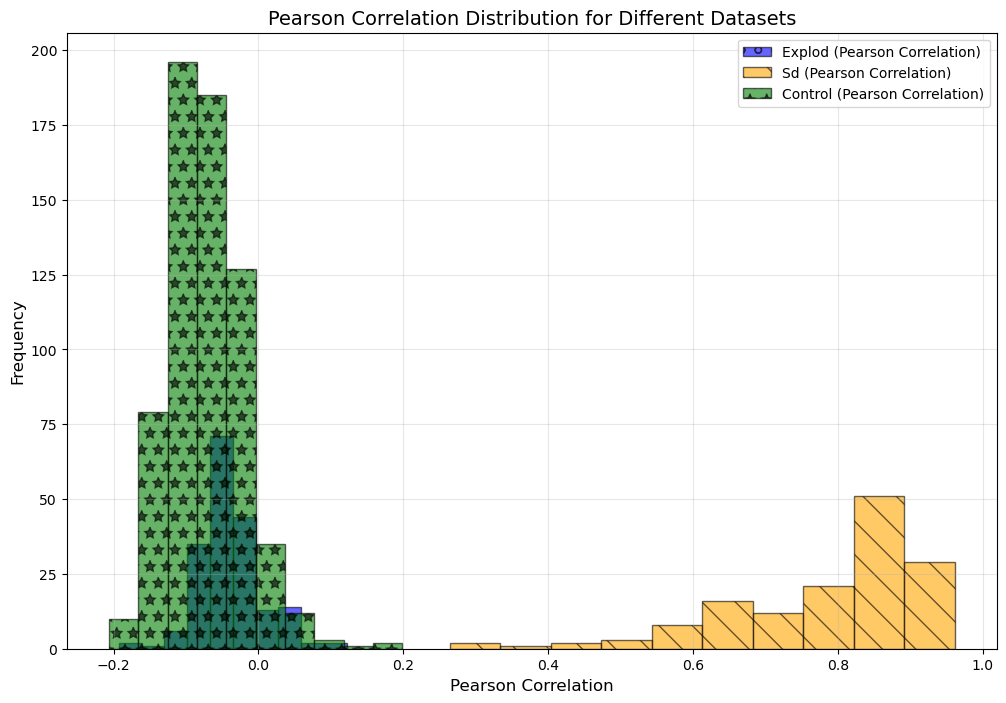

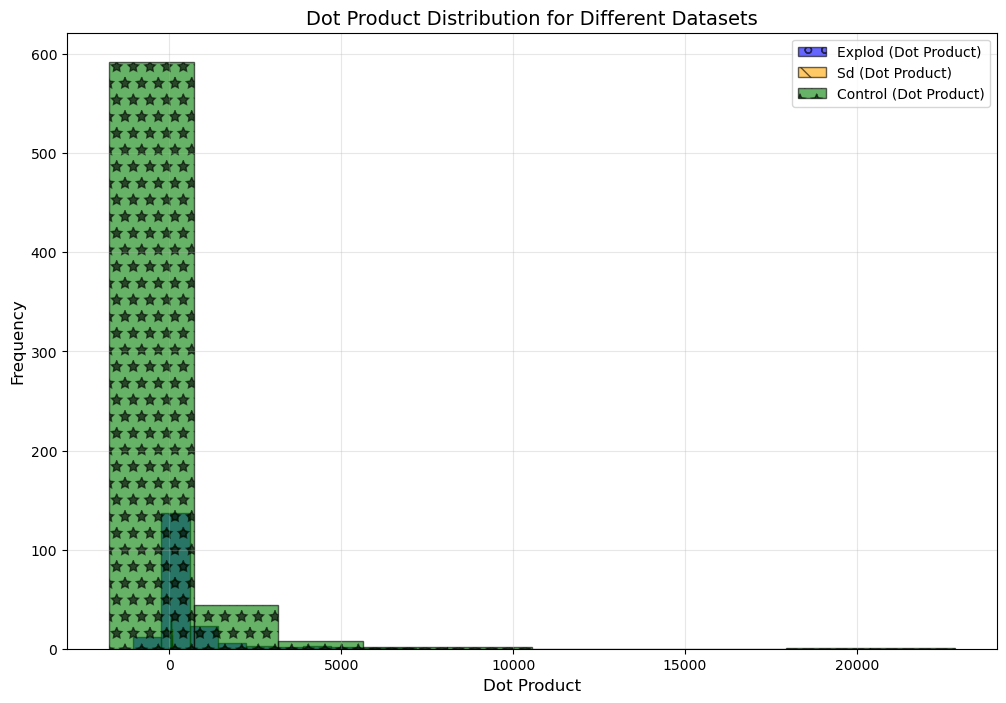

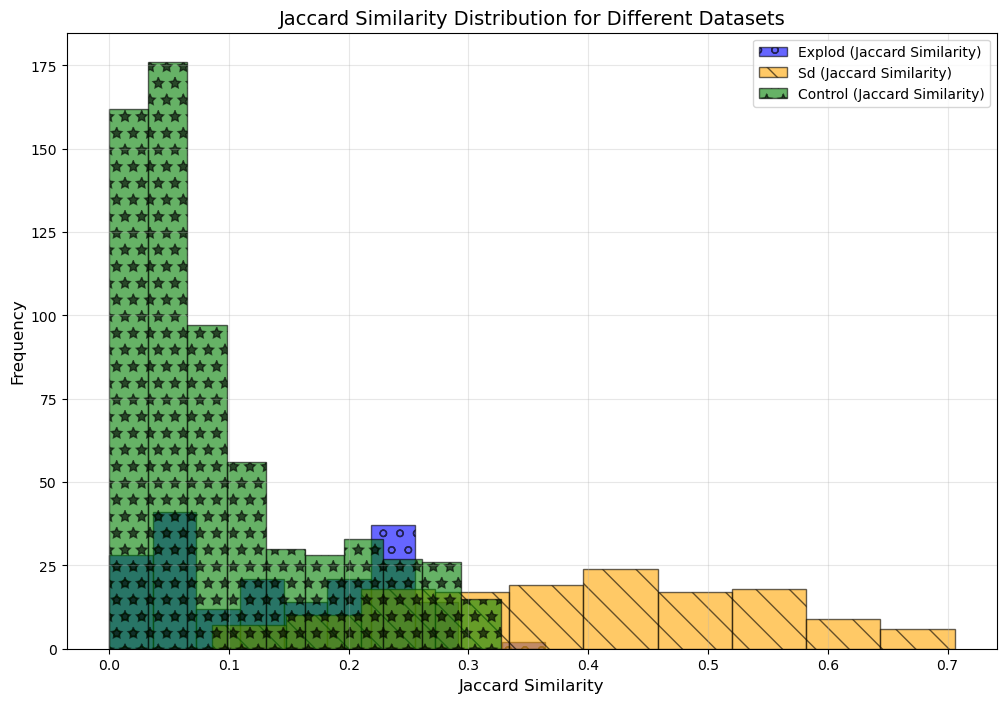

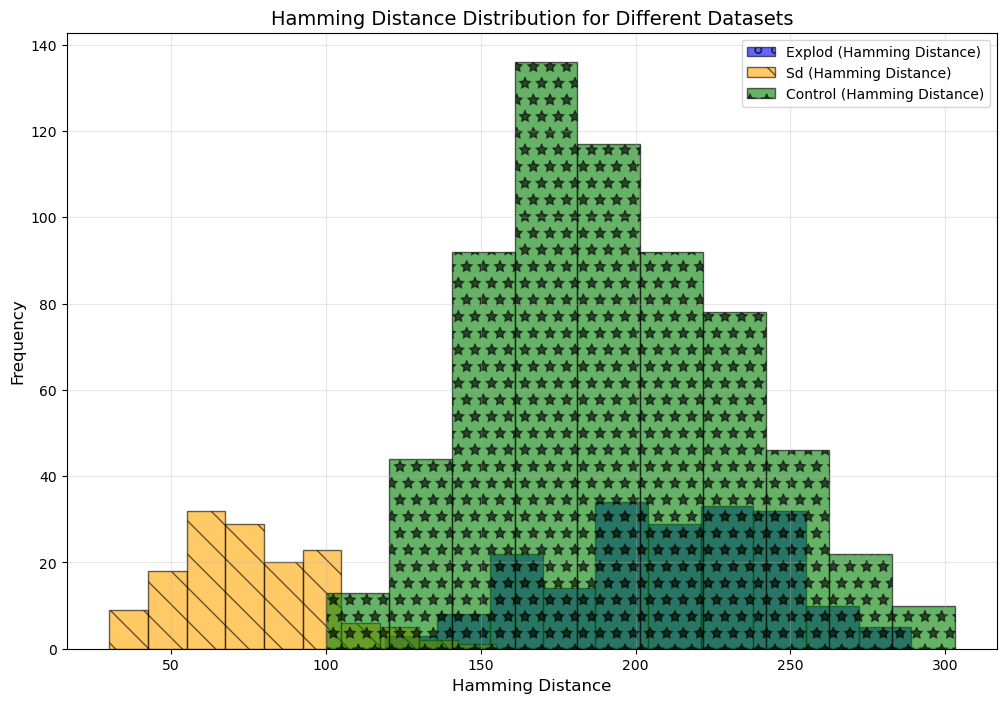

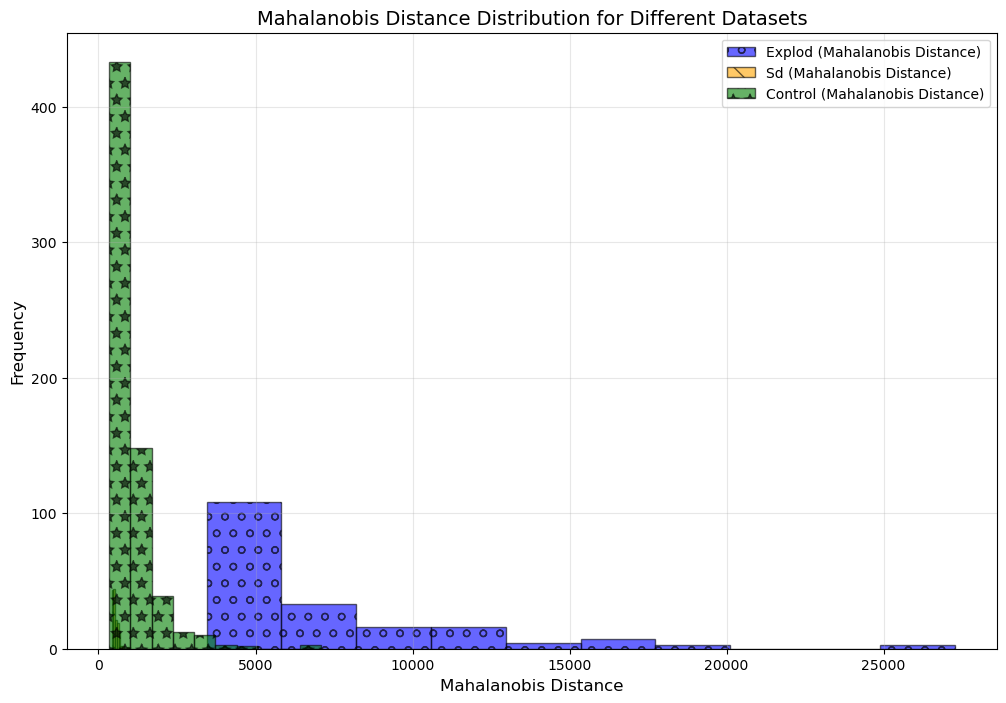

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("sd_ex.csv"),
    "sd": pd.read_csv("sd_sd.csv"),
    "control": pd.read_csv("sd_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


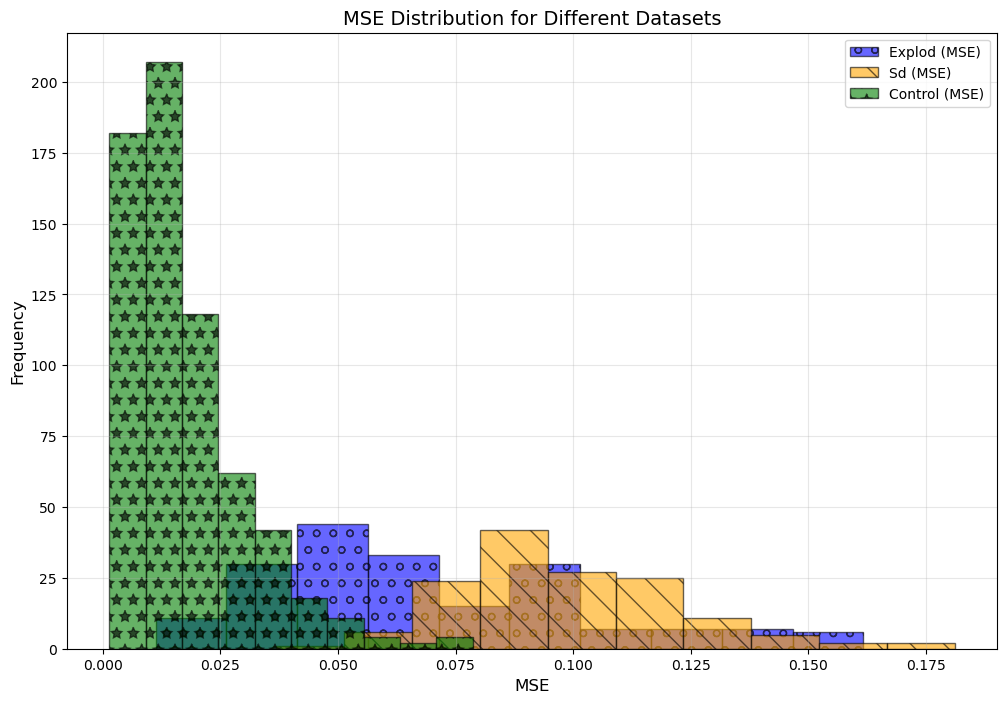

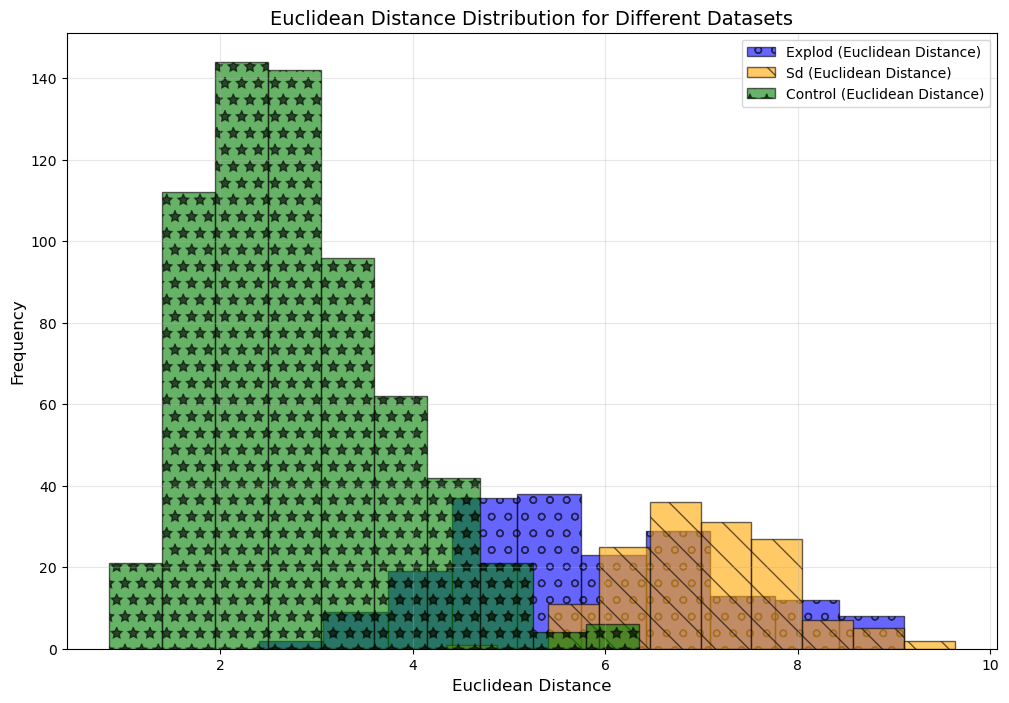

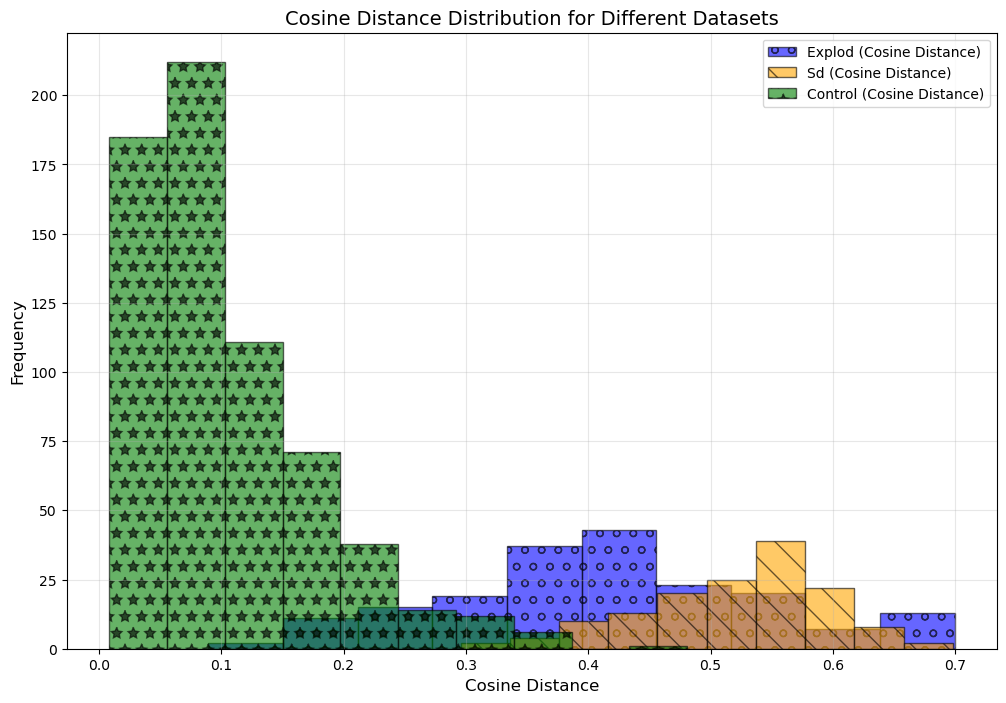

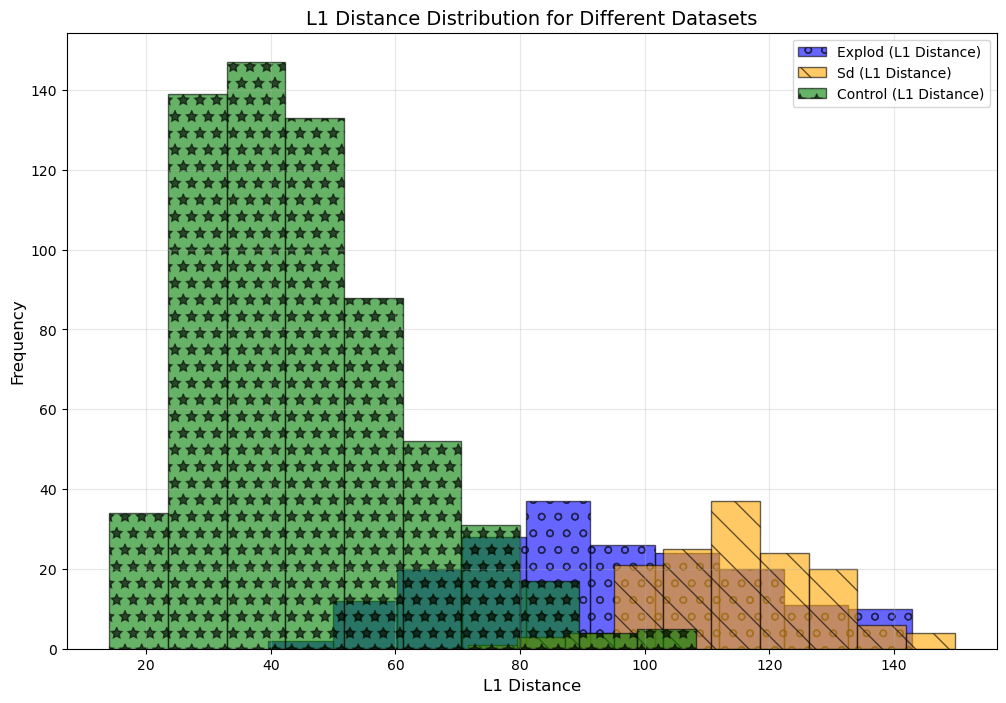

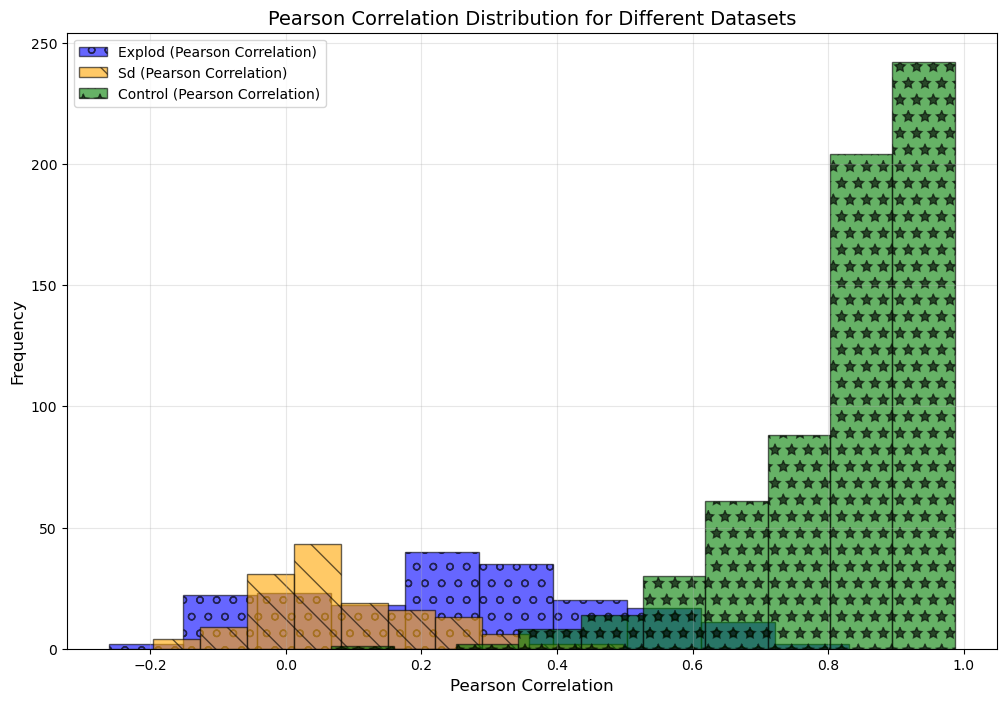

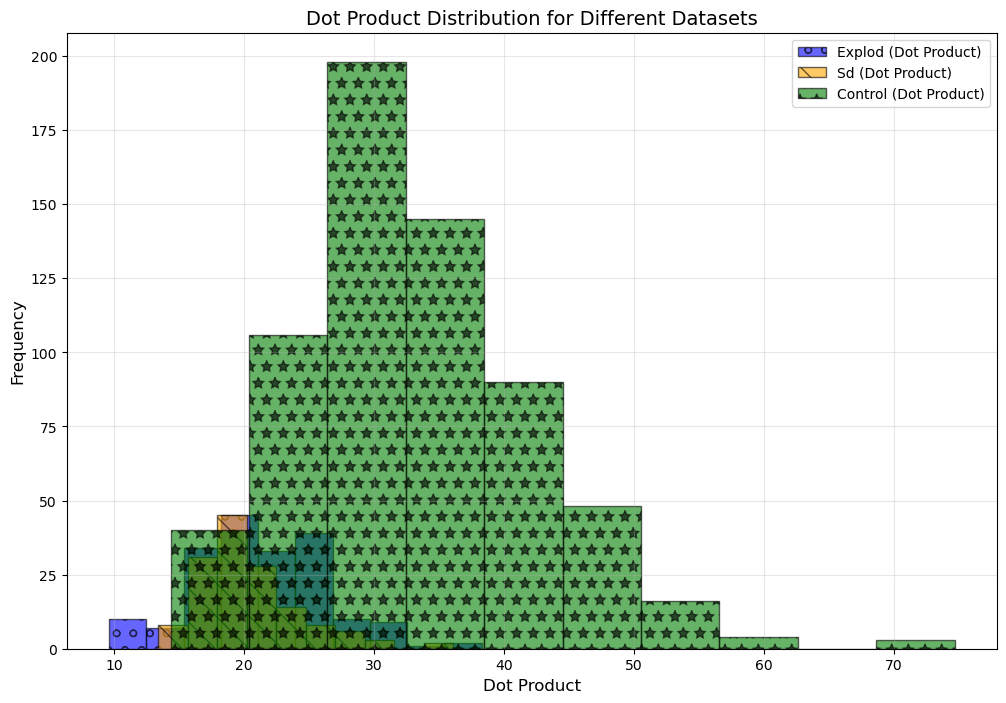

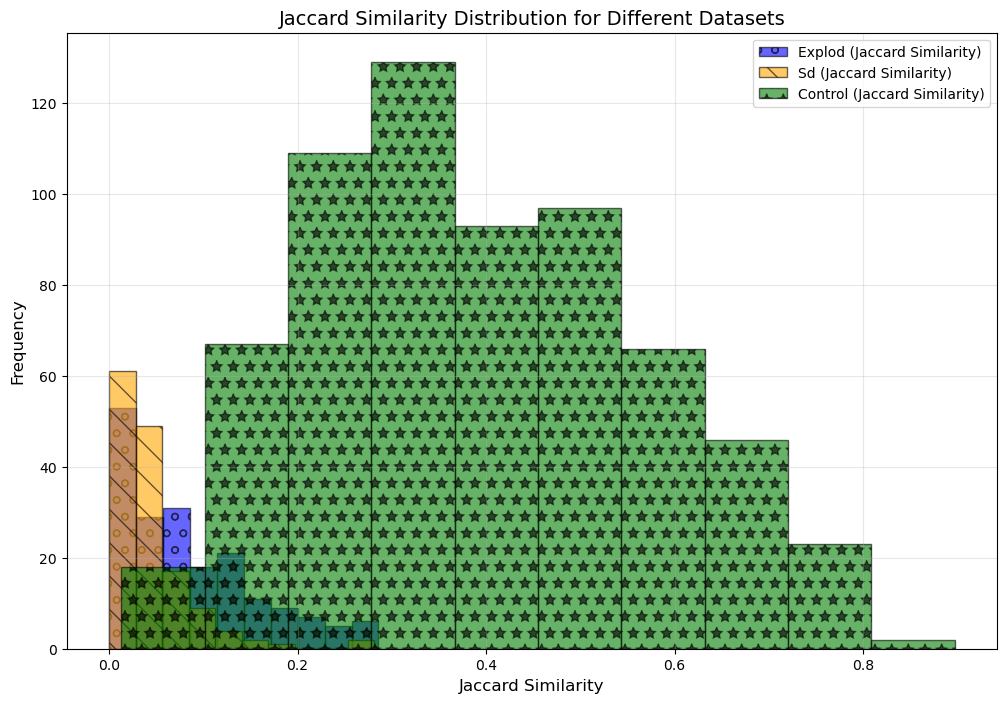

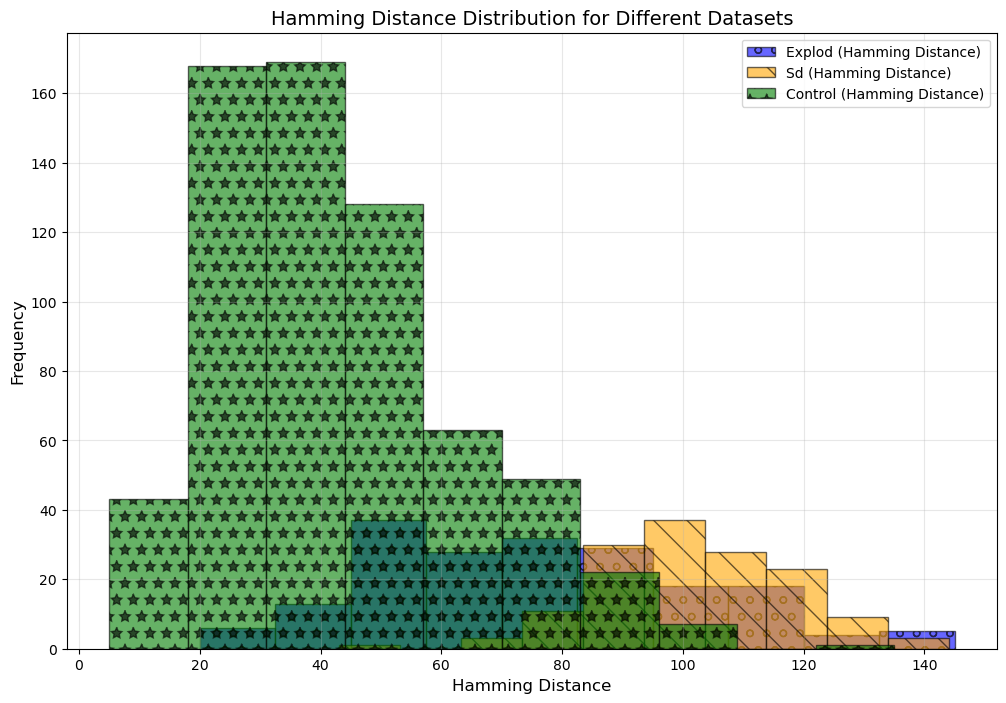

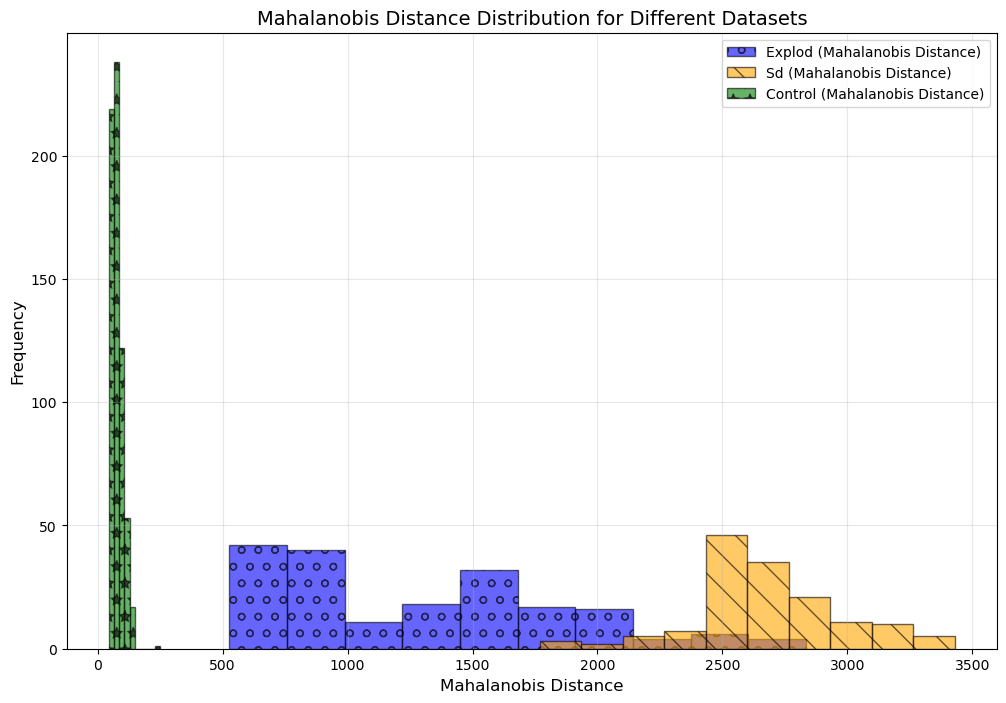

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Load datasets
datasets = {
    "explod": pd.read_csv("10fold_ex.csv"),
    "sd": pd.read_csv("10fold_sd.csv"),
    "control": pd.read_csv("10fold_cond.csv")
}

# Prepare all metrics
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance"
]

# Define colors and hatching patterns for each dataset
colors = {"explod": "blue", "sd": "orange", "control": "green"}
hatch_styles = {"explod": "o", "sd": "\\", "control": "*"}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, df in datasets.items():
        if metric_name in df.columns:
            values = df[metric_name].tolist()
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                hatch=hatch_styles[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Compute covariance matrix for Mahalanobis distance (for day10 features)
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day10_feats_minmaxed, dim=0)  # Mean vector
    covariance_matrix = torch.cov(day10_feats_minmaxed.T)  # Covariance matrix
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
    covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day10_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10, dim=1)  # Predicted distribution
        actual_probs = F.softmax(train_day10_feats, dim=1)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [21]:
ex_close_metrics = compute_metrics(model, ex7_close_minmax, ex10_close_minmax)
sd_close_metrics = compute_metrics(model, sd7_close_minmax, sd10_close_minmax)
cond_metrics = compute_metrics(model, cond7_minmax, cond10_minmax)
combined_sd_metrics = compute_metrics(model, combined_sd7_minmax, combined_sd10_minmax)
sd_metrics = compute_metrics(model, sd7_minmax, sd10_minmax)
ex_metrics = compute_metrics(model, ex7_minmax, ex10_minmax)

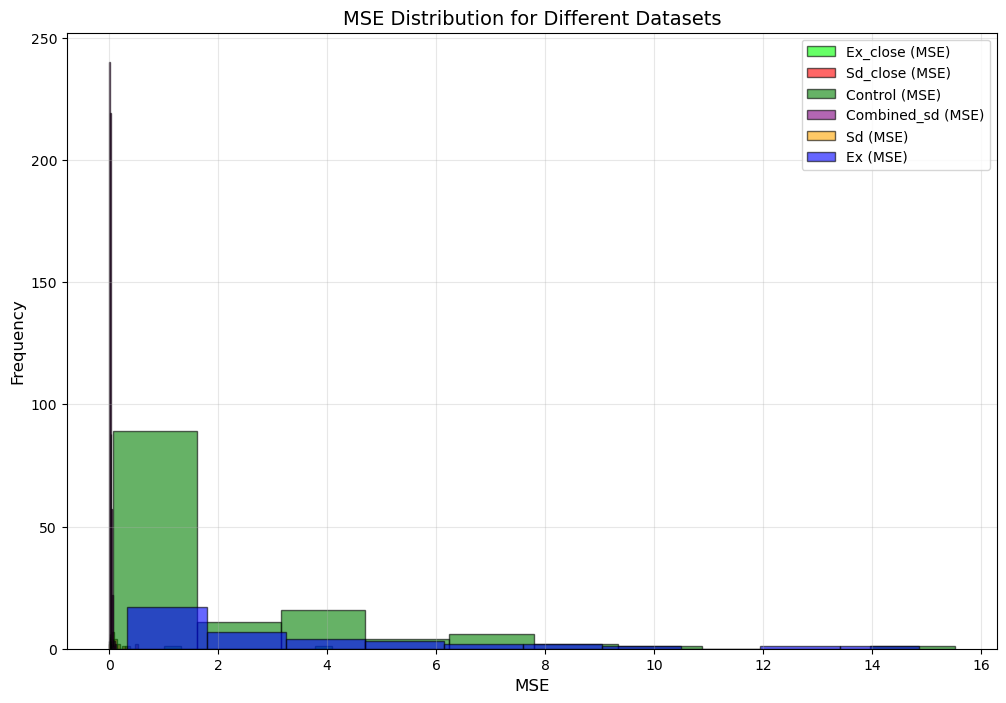

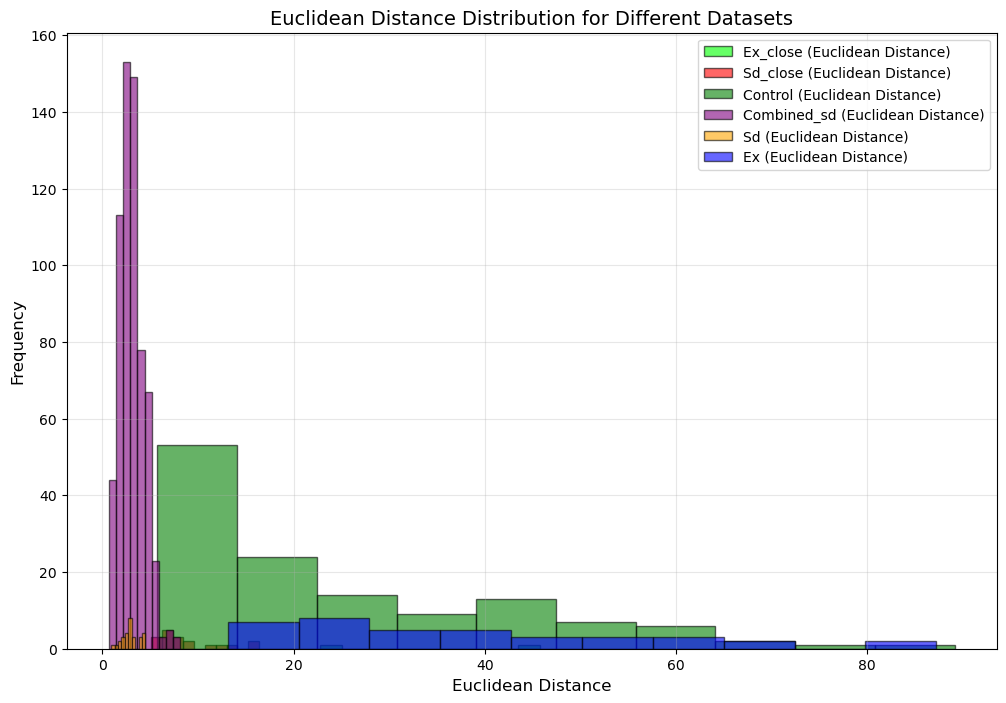

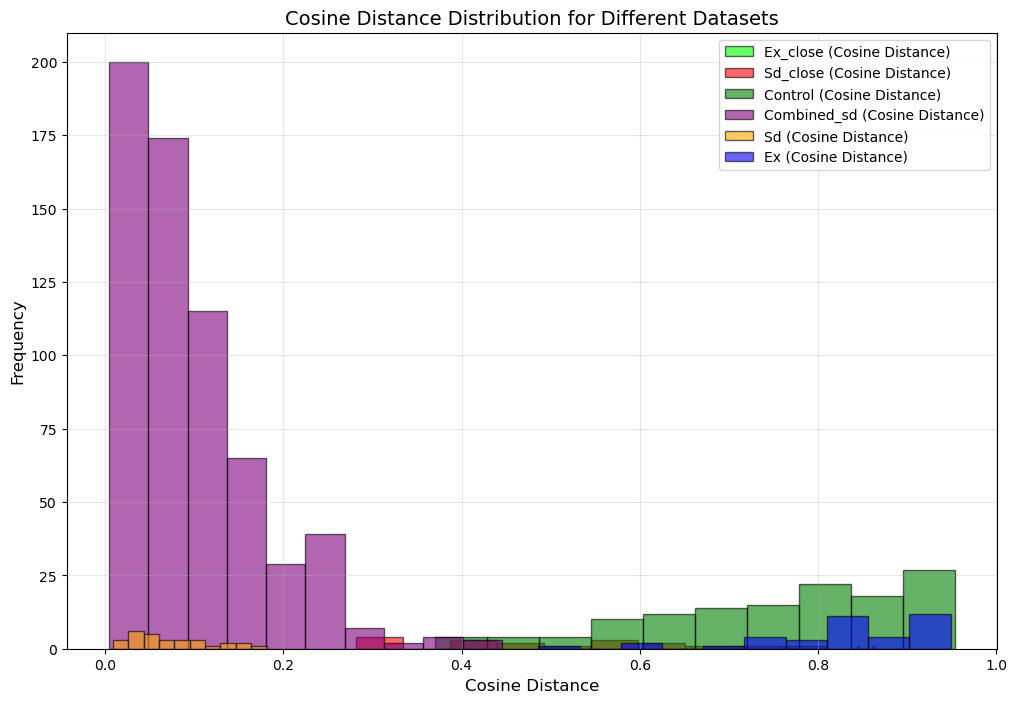

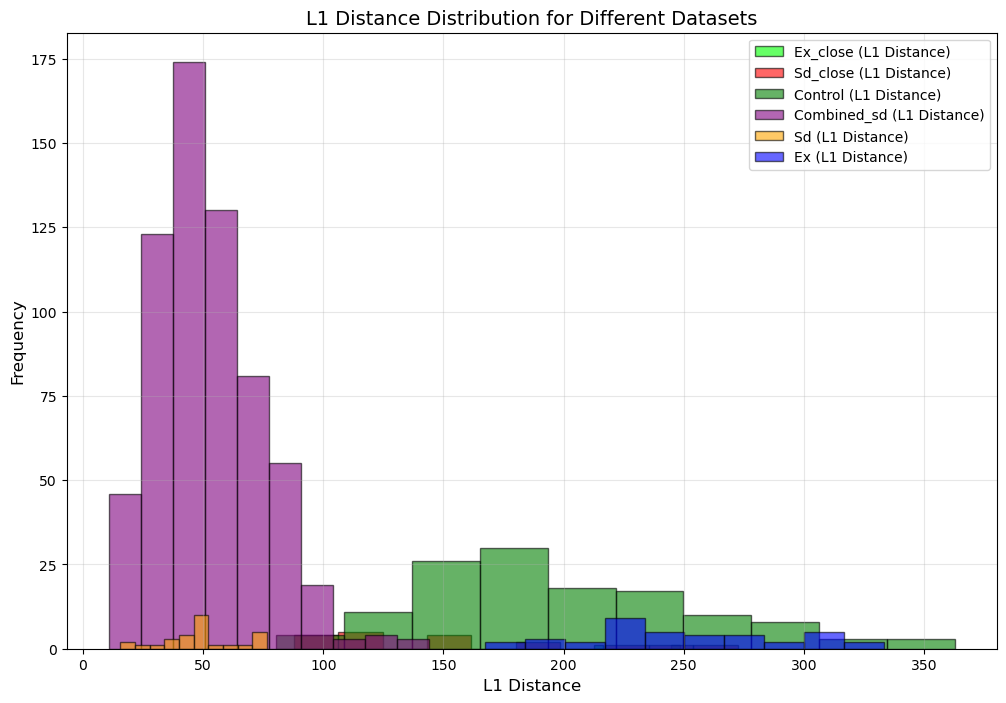

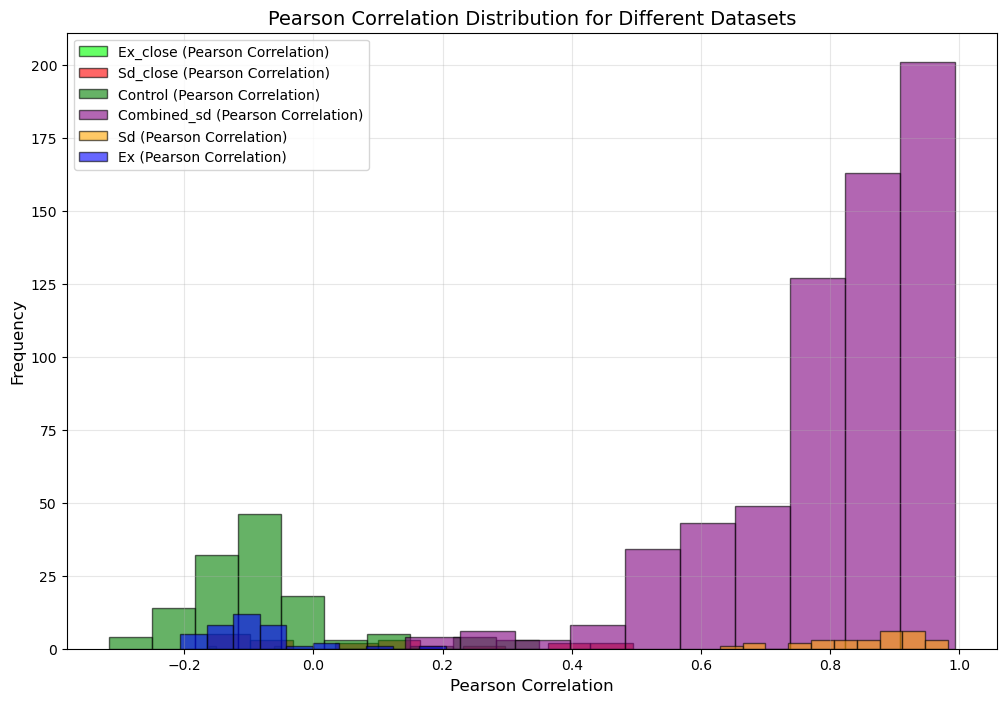

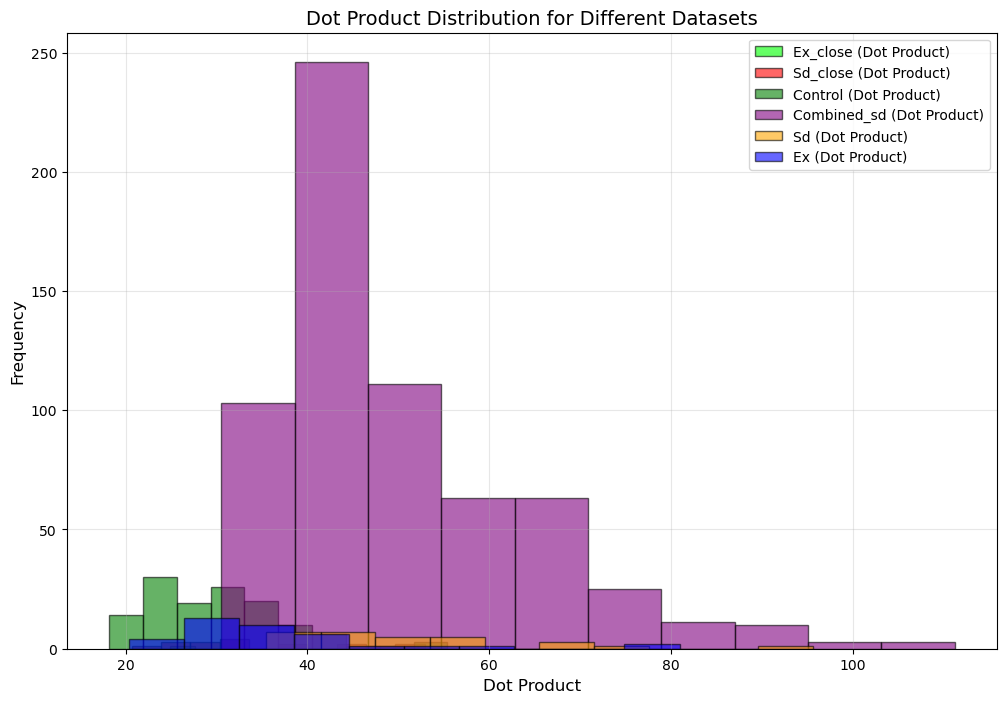

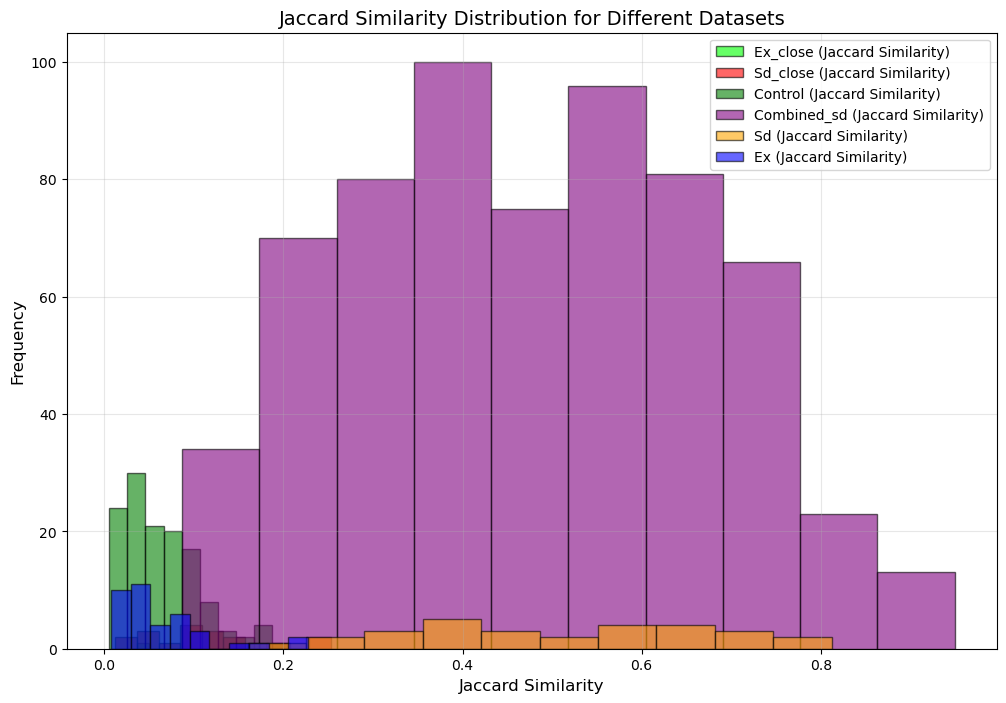

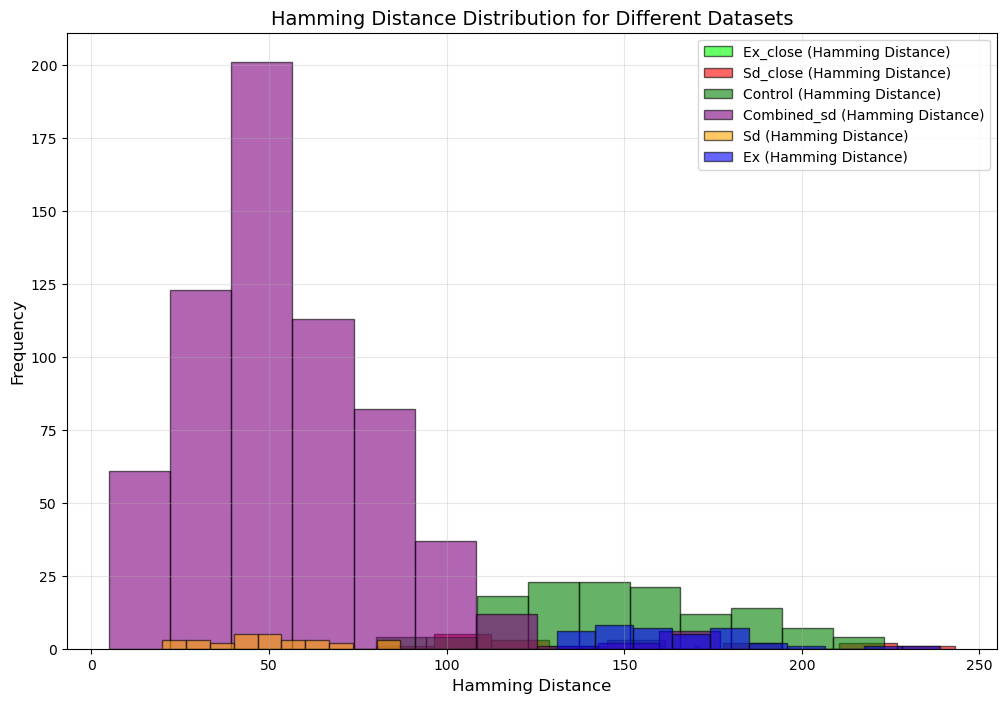

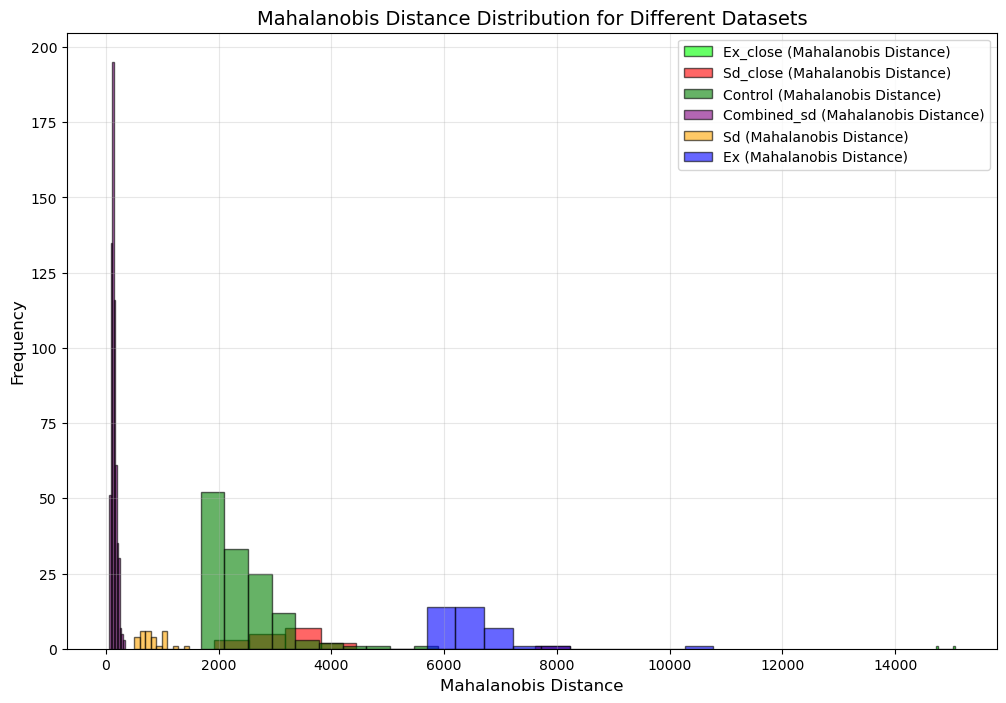

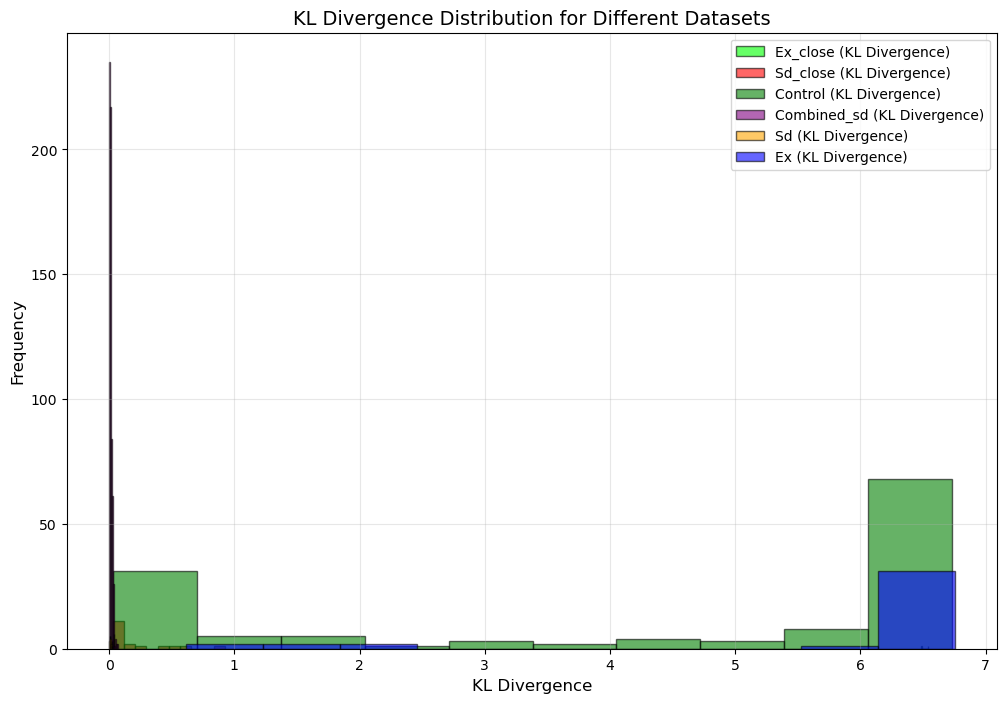

In [22]:
import matplotlib.pyplot as plt

# Metrics dictionary
datasets = {
    "ex_close": ex_close_metrics,
    "sd_close": sd_close_metrics,
    "control": cond_metrics,
    "combined_sd": combined_sd_metrics,
    "sd": sd_metrics,
    "ex": ex_metrics
}

# Metrics to plot
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance",
    "KL Divergence"
]

# Define colors for each dataset
colors = {
    "ex_close": "lime",
    "sd_close": "red",
    "control": "green",
    "combined_sd": "purple",
    "sd": "orange",
    "ex": "blue"
}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, metrics_dict in datasets.items():
        if metric_name in metrics_dict:  # Check if the metric exists
            values = metrics_dict[metric_name]
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [23]:
def cor_compute_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Compute covariance matrix for Mahalanobis distance (for day10 features)
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day10_feats_minmaxed, dim=0)  # Mean vector
    covariance_matrix = torch.cov(day10_feats_minmaxed.T)  # Covariance matrix
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
    covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Check dimensional consistency
        if predicted_day10.shape != train_day10_feats.shape:
            raise ValueError(
                f"Dimensional mismatch: Predicted {predicted_day10.shape} vs Actual {train_day10_feats.shape}"
            )
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.squeeze(), train_day10_feats.squeeze()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day10_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10.squeeze(), dim=0)  # Predicted distribution
        actual_probs = F.softmax(train_day10_feats.squeeze(), dim=0)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [24]:
ex_close_metrics = cor_compute_metrics(model, ex7_close_minmax, ex10_close_minmax)
sd_close_metrics = cor_compute_metrics(model, sd7_close_minmax, sd10_close_minmax)
cond_metrics = cor_compute_metrics(model, cond7_minmax, cond10_minmax)
combined_sd_metrics = cor_compute_metrics(model, combined_sd7_minmax, combined_sd10_minmax)
sd_metrics = cor_compute_metrics(model, sd7_minmax, sd10_minmax)
ex_metrics = cor_compute_metrics(model, ex7_minmax, ex10_minmax)

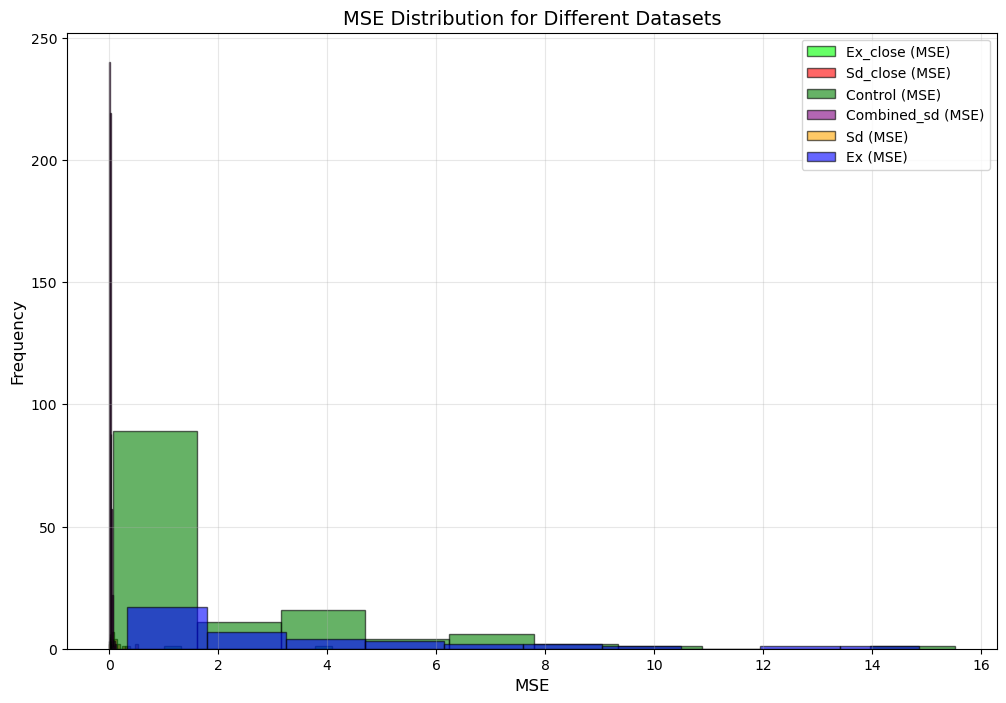

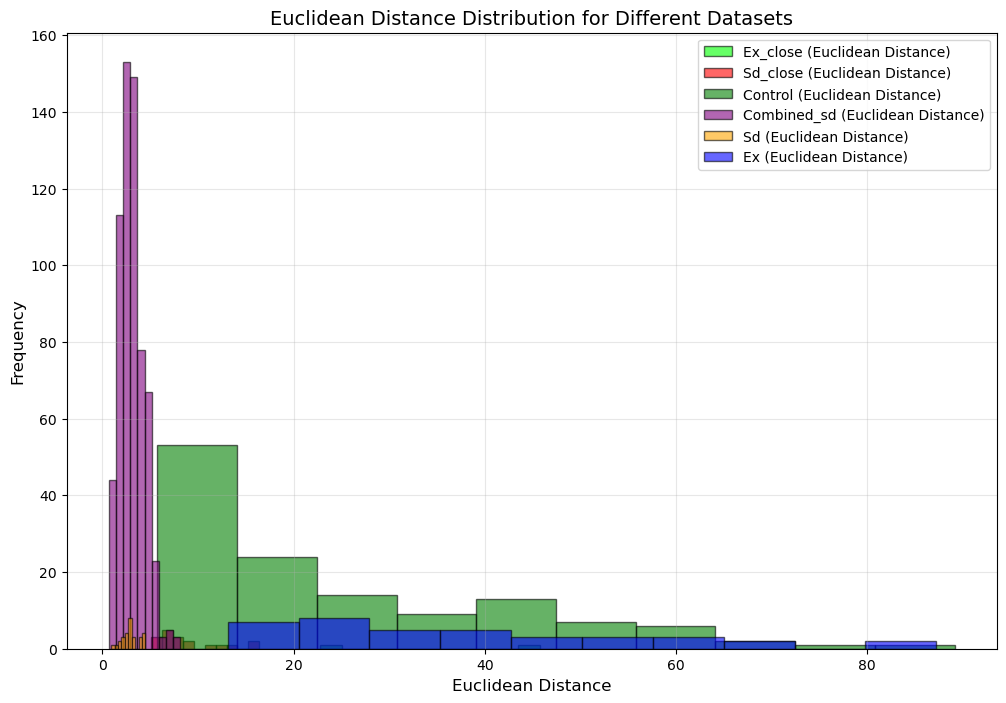

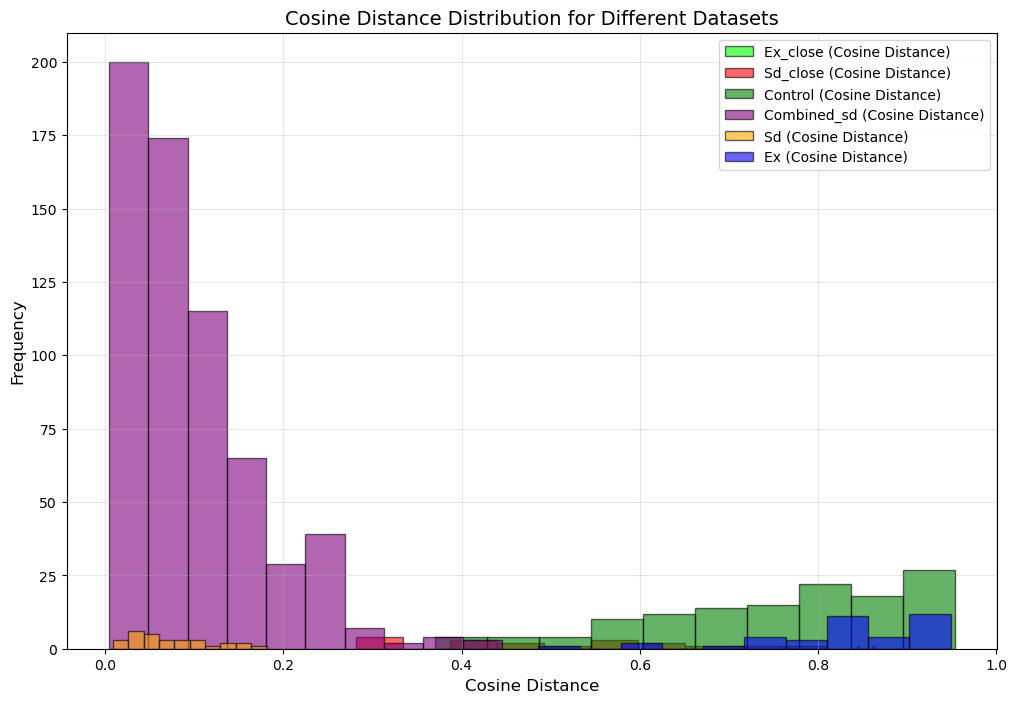

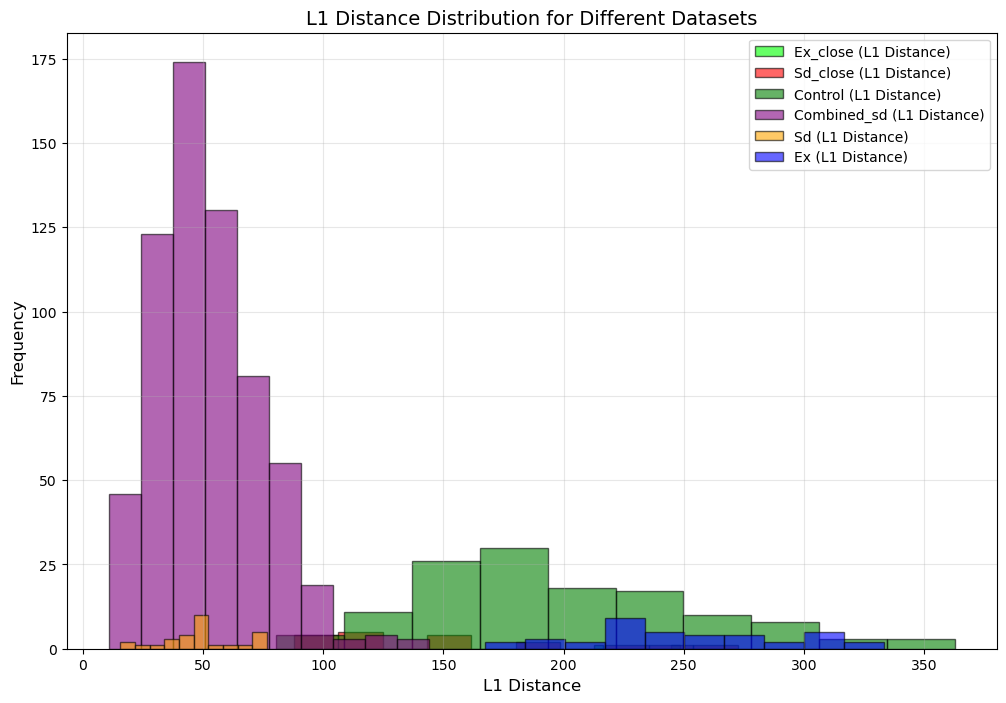

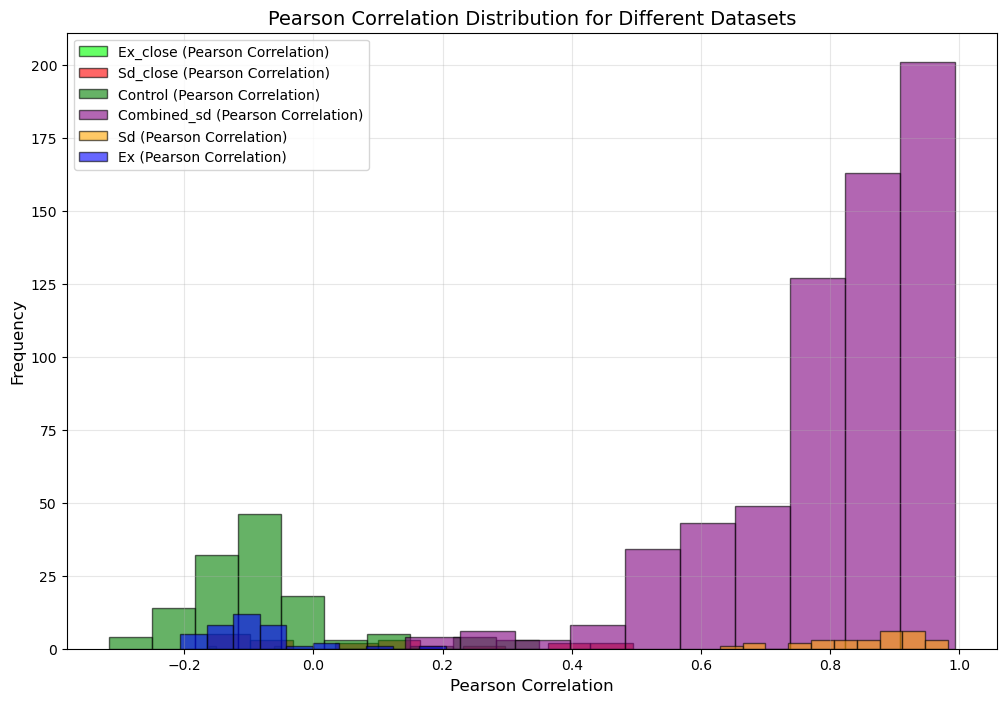

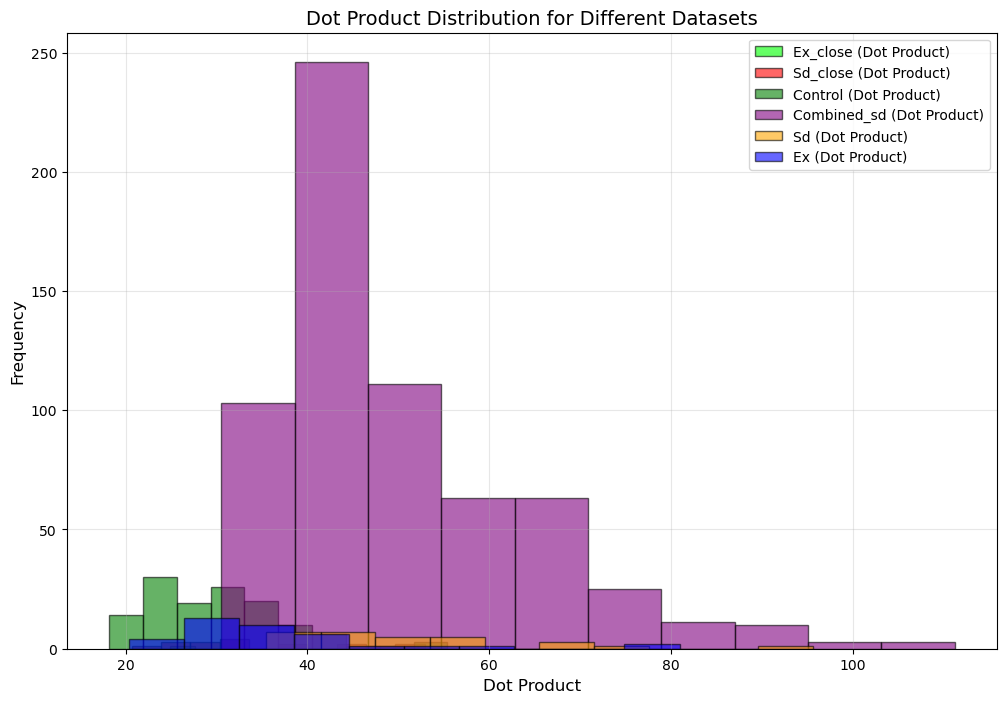

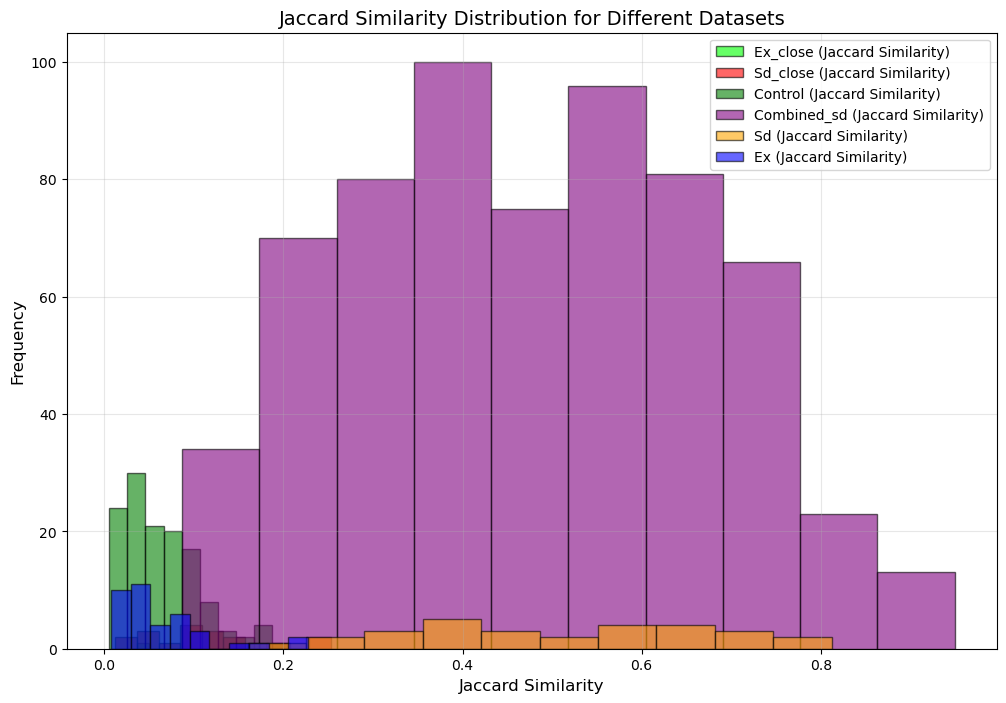

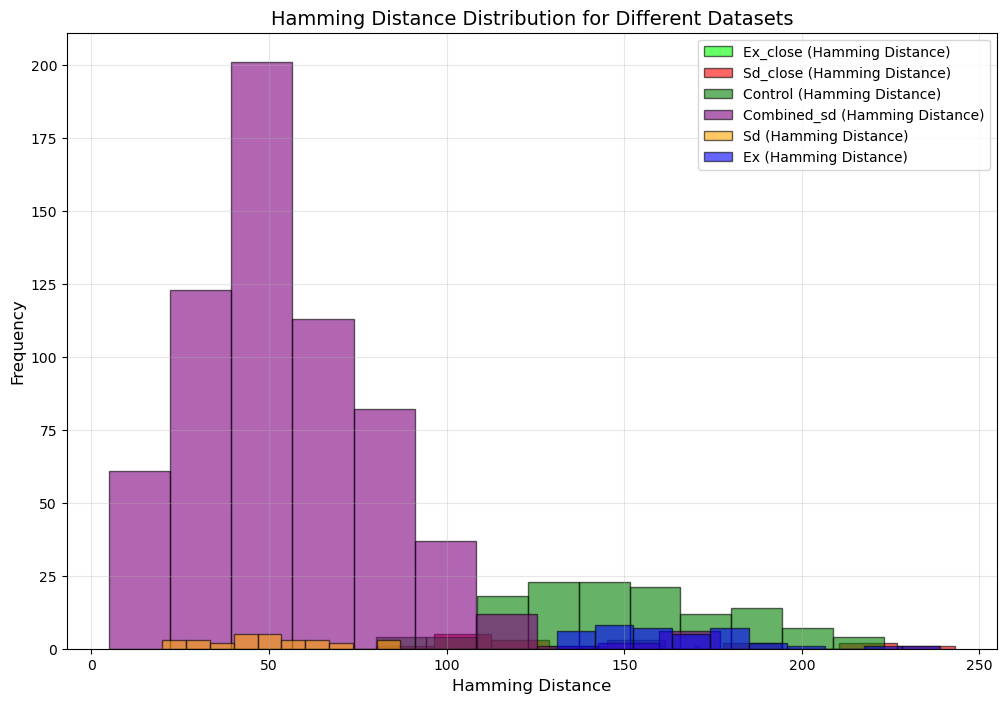

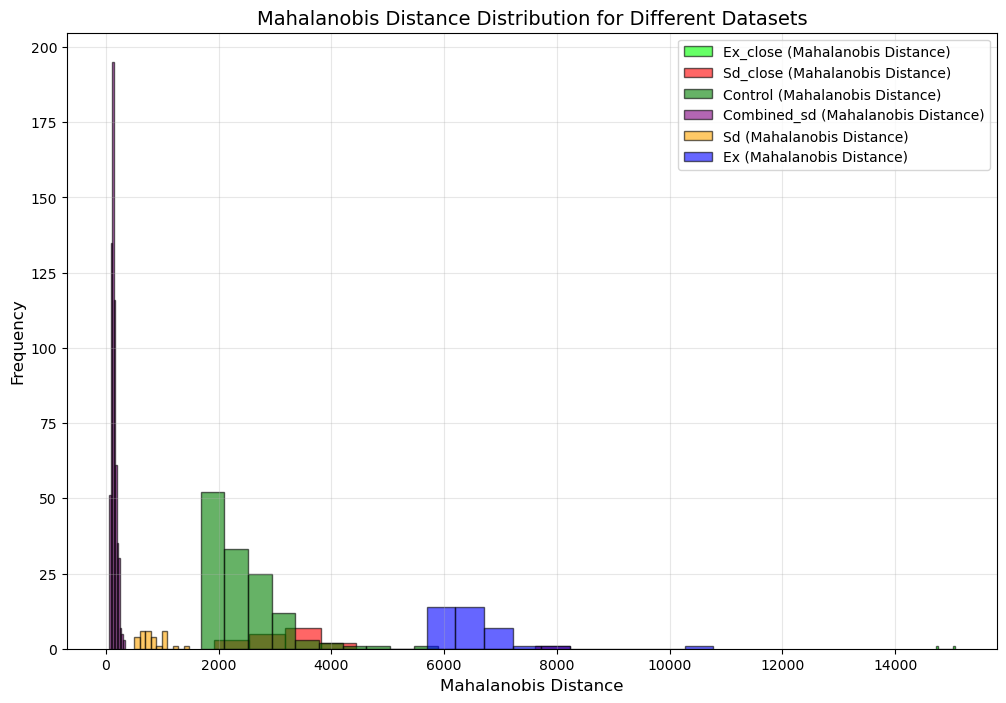

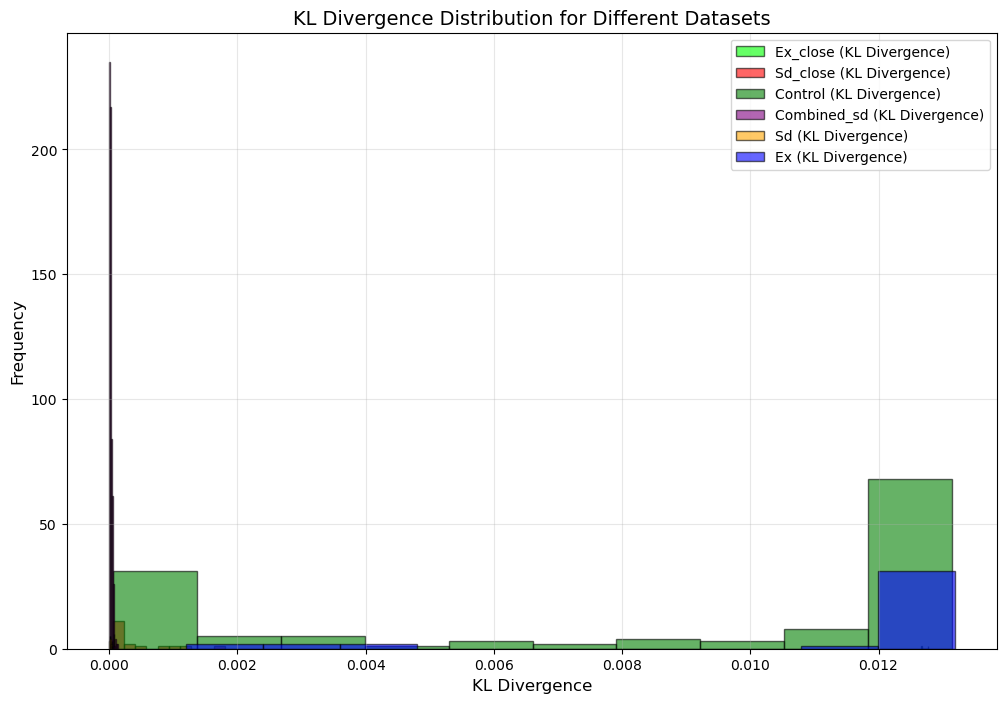

In [25]:
import matplotlib.pyplot as plt

# Metrics dictionary
datasets = {
    "ex_close": ex_close_metrics,
    "sd_close": sd_close_metrics,
    "control": cond_metrics,
    "combined_sd": combined_sd_metrics,
    "sd": sd_metrics,
    "ex": ex_metrics
}

# Metrics to plot
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance",
    "KL Divergence"
]

# Define colors for each dataset
colors = {
    "ex_close": "lime",
    "sd_close": "red",
    "control": "green",
    "combined_sd": "purple",
    "sd": "orange",
    "ex": "blue"
}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, metrics_dict in datasets.items():
        if metric_name in metrics_dict:  # Check if the metric exists
            values = metrics_dict[metric_name]
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [23]:
# Mahalolan distance
import torch.nn as nn
import torch.nn.functional as F

In [1]:
# pointwise mahalolan

In [44]:
def newmd_compute_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Check dimensional consistency
        if predicted_day10.shape != train_day10_feats.shape:
            raise ValueError(
                f"Dimensional mismatch: Predicted {predicted_day10.shape} vs Actual {train_day10_feats.shape}"
            )
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.squeeze(), train_day10_feats.squeeze()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day10_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        actual_day10 = train_day10_feats
        delta = predicted_day10 - actual_day10  # Shape: [1, 512]
        
        # Use an identity matrix with the correct shape for covariance
        identity_matrix = torch.eye(delta.size(-1), device=device)  # Shape: [512, 512]
        
        # Compute Mahalanobis distance in 2D space
        # delta @ identity_matrix @ delta.T calculates (delta * Cov^-1 * delta.T)
        mahalanobis_distance = torch.sqrt((delta @ identity_matrix @ delta.T).squeeze()).item()
        
        mahalanobis_distances.append(mahalanobis_distance)
        '''delta = predicted_day10.flatten() - actual_day10.flatten()
        identity_matrix = torch.eye(delta.size(0), device=device)  # Use identity matrix as covariance
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(identity_matrix, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)'''
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10.squeeze(), dim=0)  # Predicted distribution
        actual_probs = F.softmax(train_day10_feats.squeeze(), dim=0)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [45]:
ex_close_metrics = newmd_compute_metrics(model, ex7_close_minmax, ex10_close_minmax)
sd_close_metrics = newmd_compute_metrics(model, sd7_close_minmax, sd10_close_minmax)
cond_metrics = newmd_compute_metrics(model, cond7_minmax, cond10_minmax)
combined_sd_metrics = newmd_compute_metrics(model, combined_sd7_minmax, combined_sd10_minmax)
sd_metrics = newmd_compute_metrics(model, sd7_minmax, sd10_minmax)
ex_metrics = newmd_compute_metrics(model, ex7_minmax, ex10_minmax)

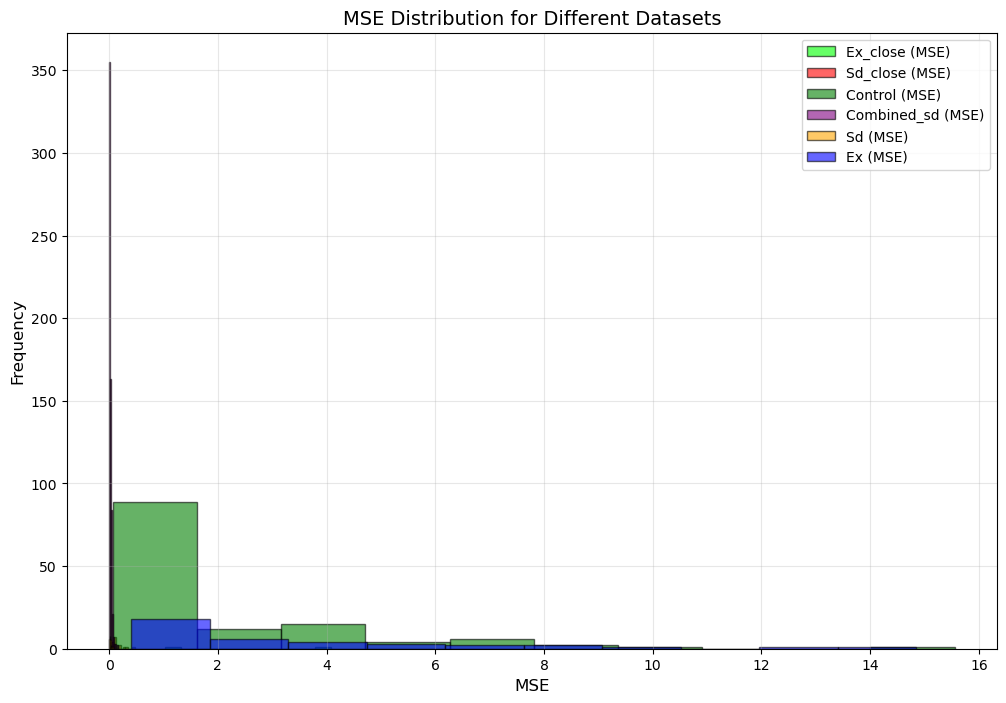

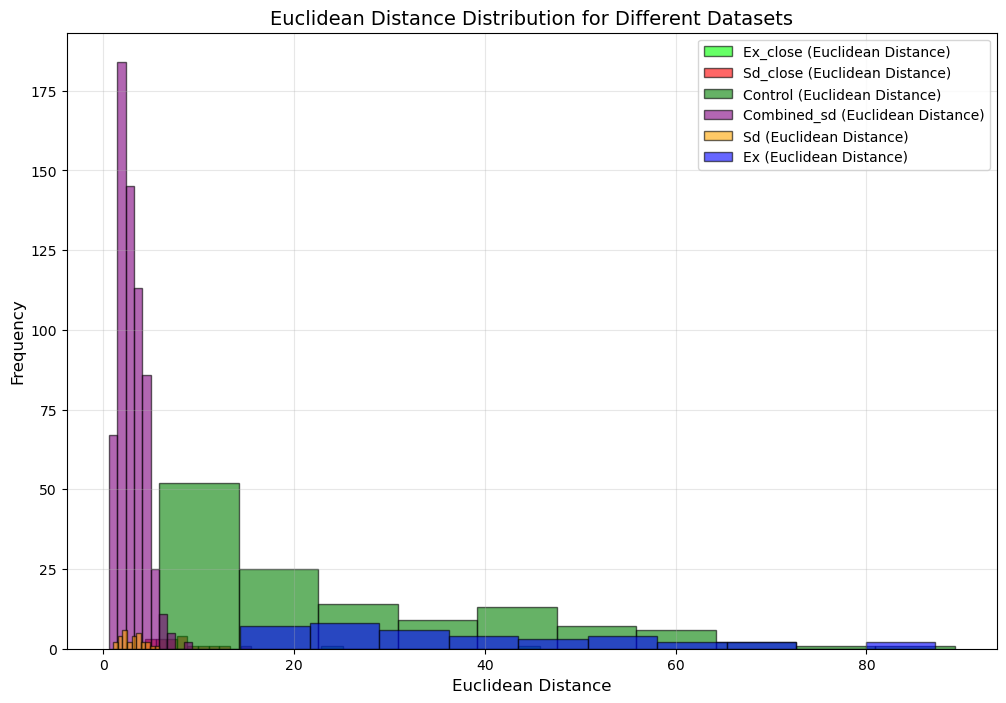

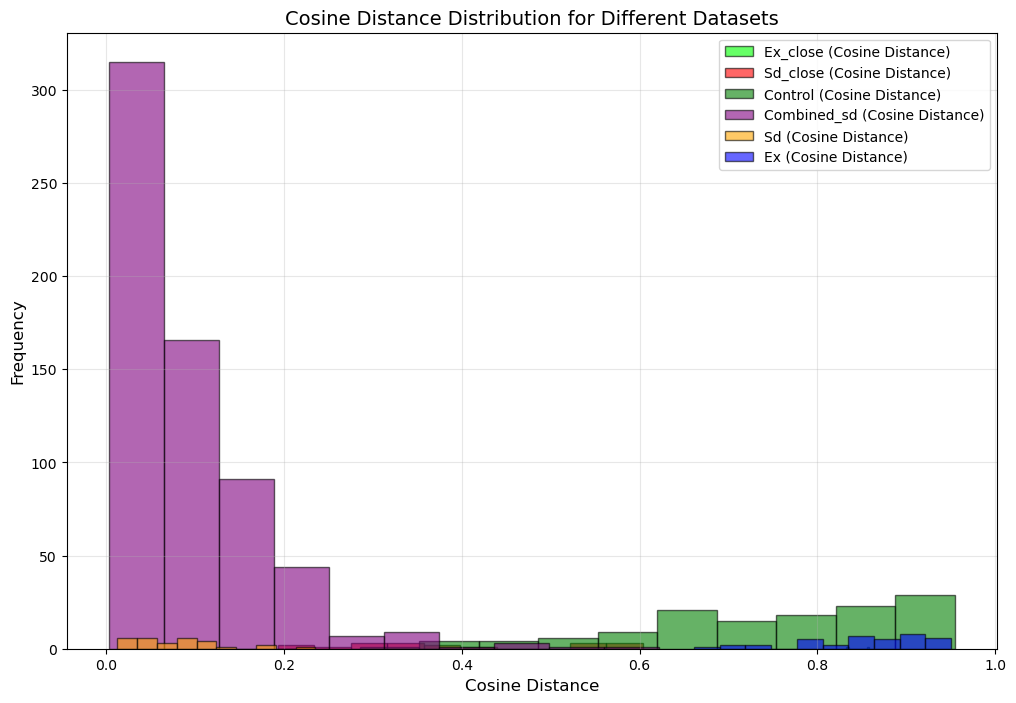

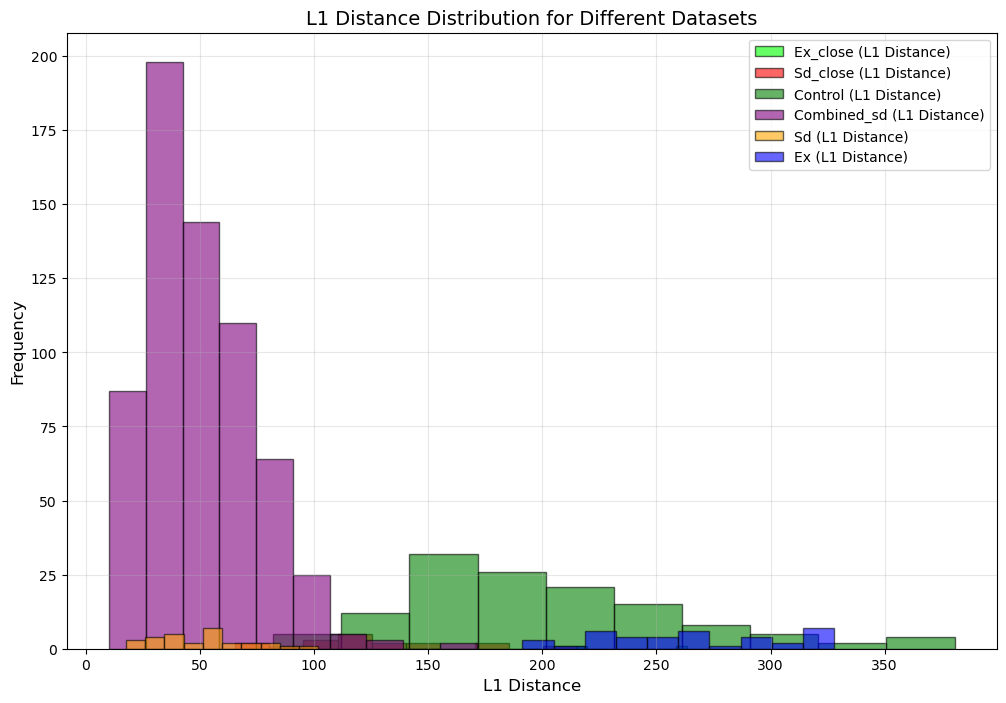

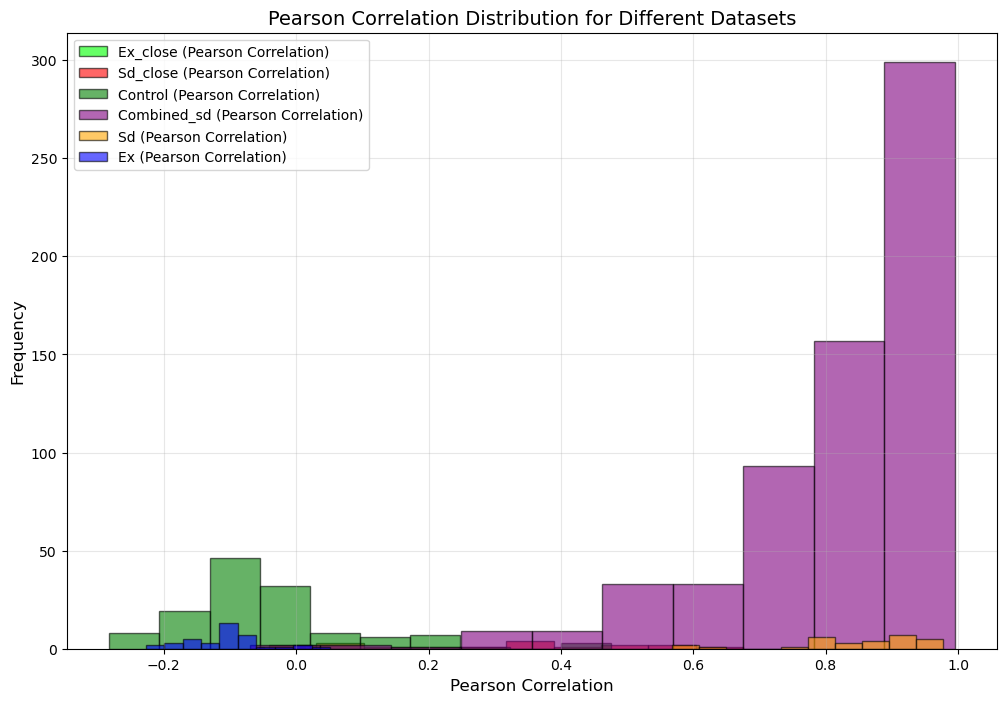

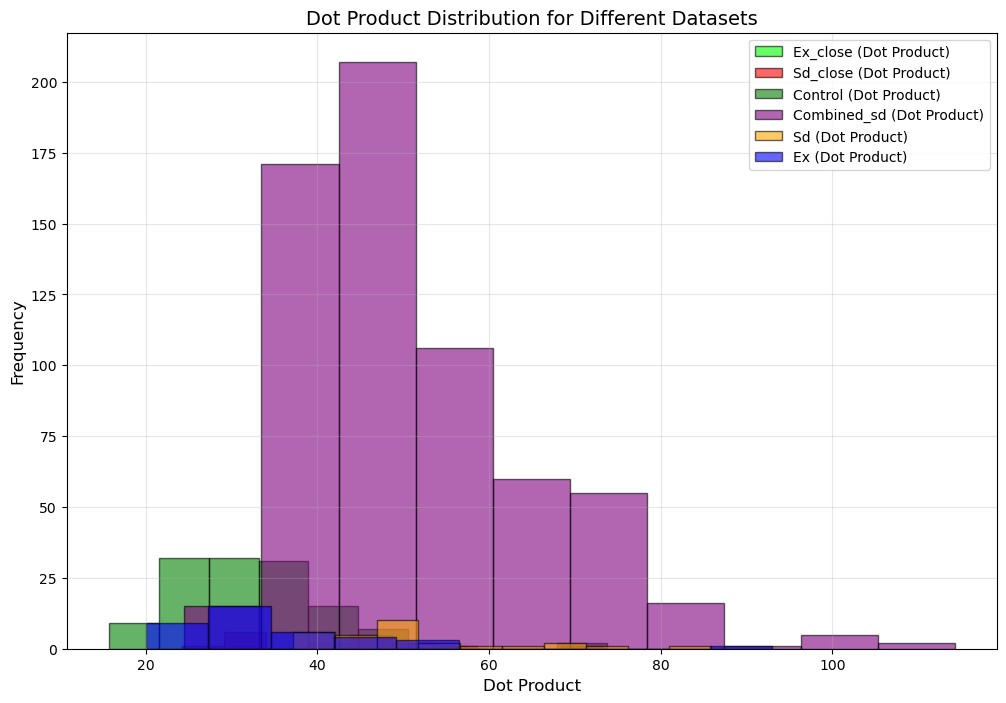

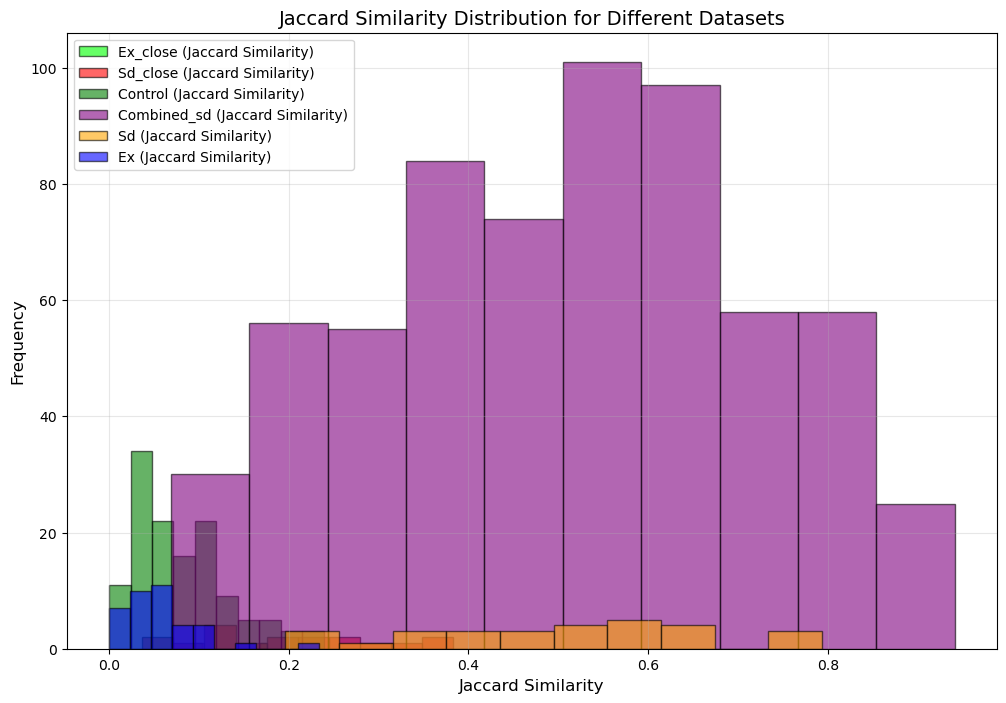

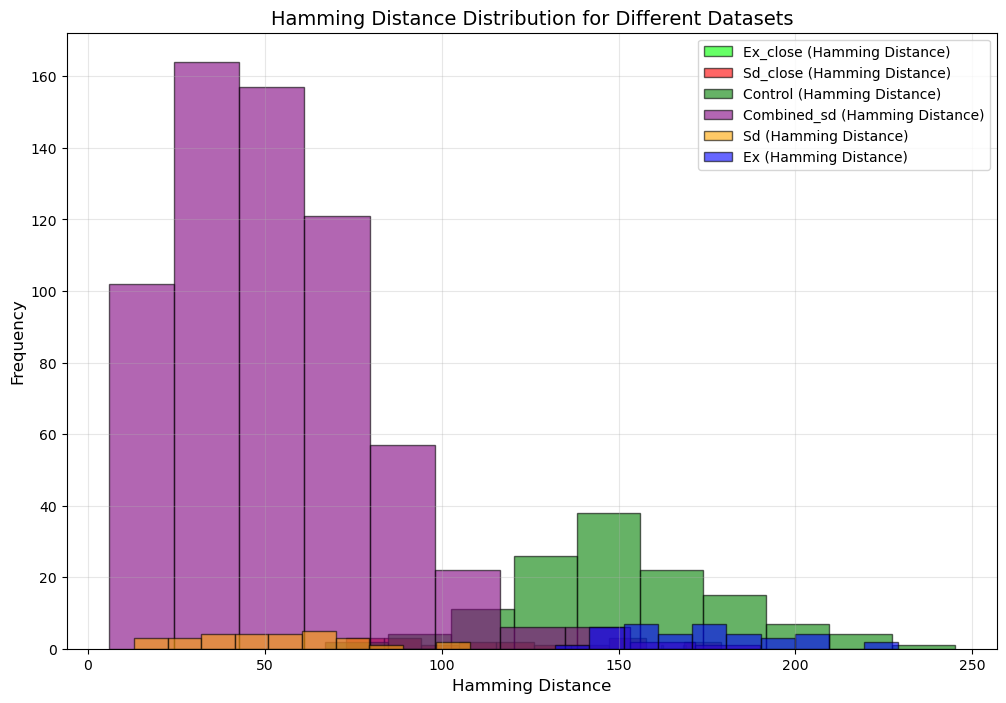

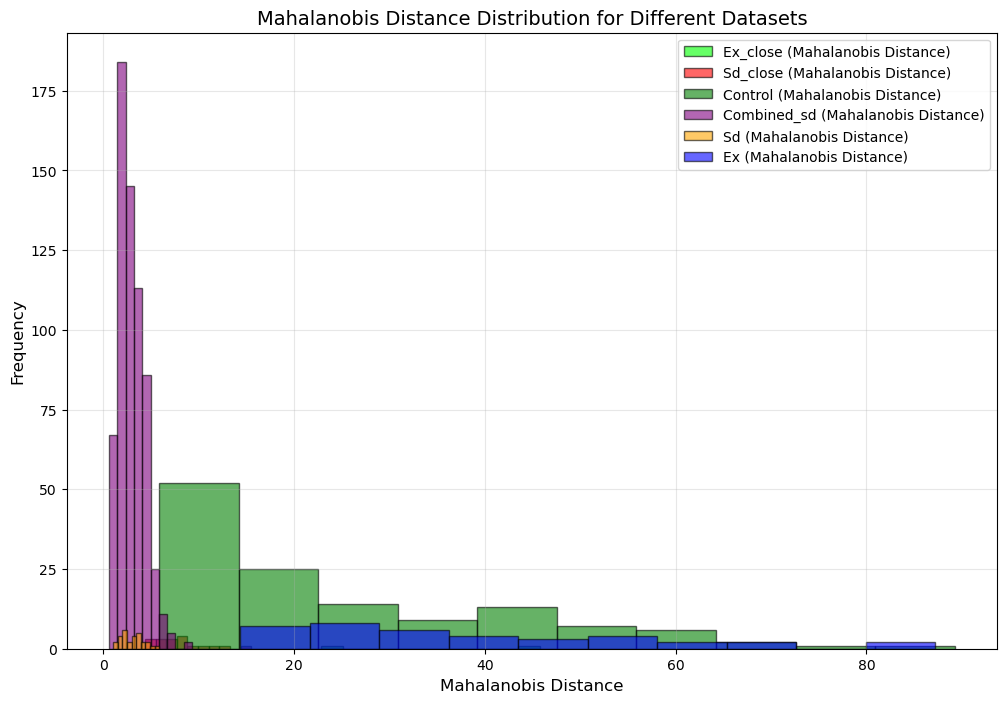

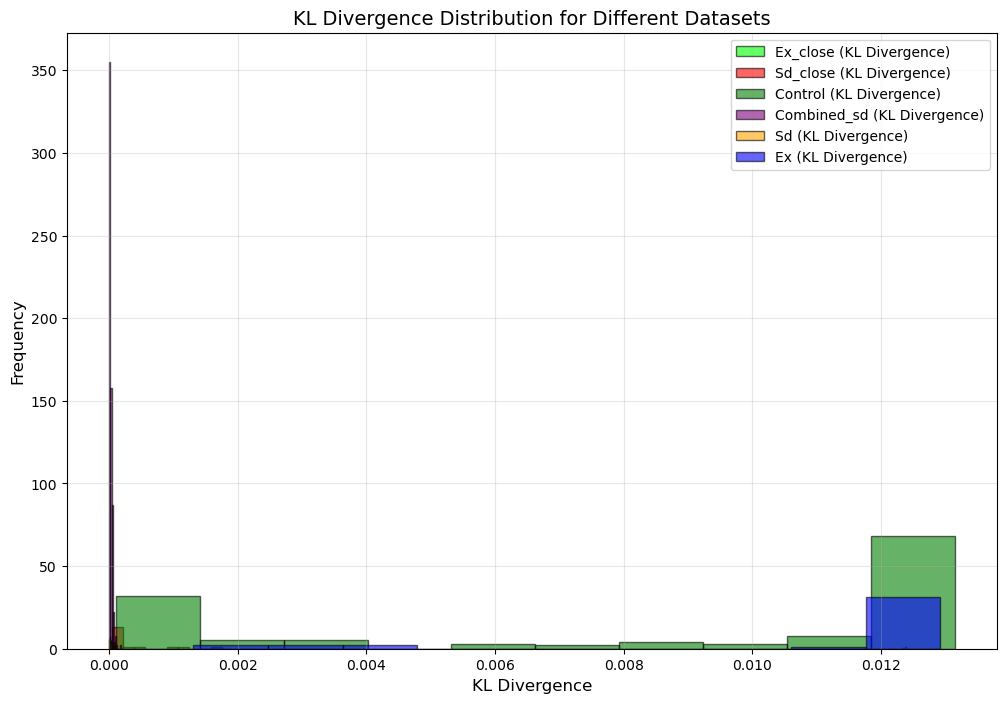

In [46]:
import matplotlib.pyplot as plt

# Metrics dictionary
datasets = {
    "ex_close": ex_close_metrics,
    "sd_close": sd_close_metrics,
    "control": cond_metrics,
    "combined_sd": combined_sd_metrics,
    "sd": sd_metrics,
    "ex": ex_metrics
}

# Metrics to plot
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance",
    "KL Divergence"
]

# Define colors for each dataset
colors = {
    "ex_close": "lime",
    "sd_close": "red",
    "control": "green",
    "combined_sd": "purple",
    "sd": "orange",
    "ex": "blue"
}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, metrics_dict in datasets.items():
        if metric_name in metrics_dict:  # Check if the metric exists
            values = metrics_dict[metric_name]
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [47]:
def md_compute_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Check dimensional consistency
        if predicted_day10.shape != train_day10_feats.shape:
            raise ValueError(
                f"Dimensional mismatch: Predicted {predicted_day10.shape} vs Actual {train_day10_feats.shape}"
            )
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.squeeze(), train_day10_feats.squeeze()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day10_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        actual_day10 = train_day10_feats
        delta = predicted_day10.flatten() - actual_day10.flatten()
        identity_matrix = torch.eye(delta.size(0), device=device)  # Use identity matrix as covariance
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(identity_matrix, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10.squeeze(), dim=0)  # Predicted distribution
        actual_probs = F.softmax(train_day10_feats.squeeze(), dim=0)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [48]:
ex_close_metrics = md_compute_metrics(model, ex7_close_minmax, ex10_close_minmax)
sd_close_metrics = md_compute_metrics(model, sd7_close_minmax, sd10_close_minmax)
cond_metrics = md_compute_metrics(model, cond7_minmax, cond10_minmax)
combined_sd_metrics = md_compute_metrics(model, combined_sd7_minmax, combined_sd10_minmax)
sd_metrics = md_compute_metrics(model, sd7_minmax, sd10_minmax)
ex_metrics = md_compute_metrics(model, ex7_minmax, ex10_minmax)

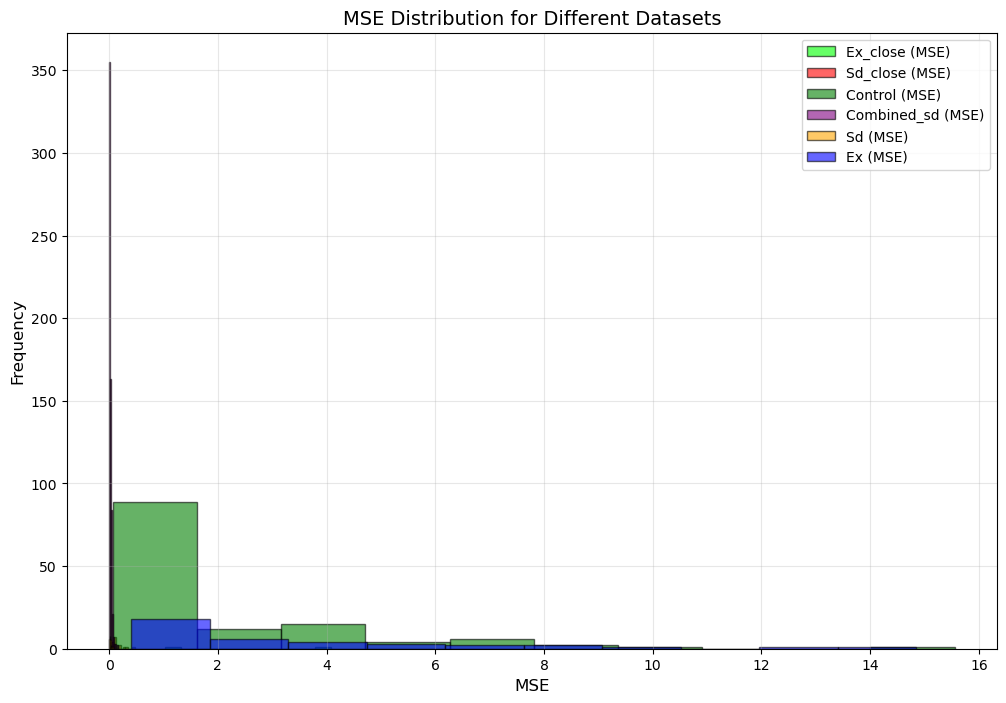

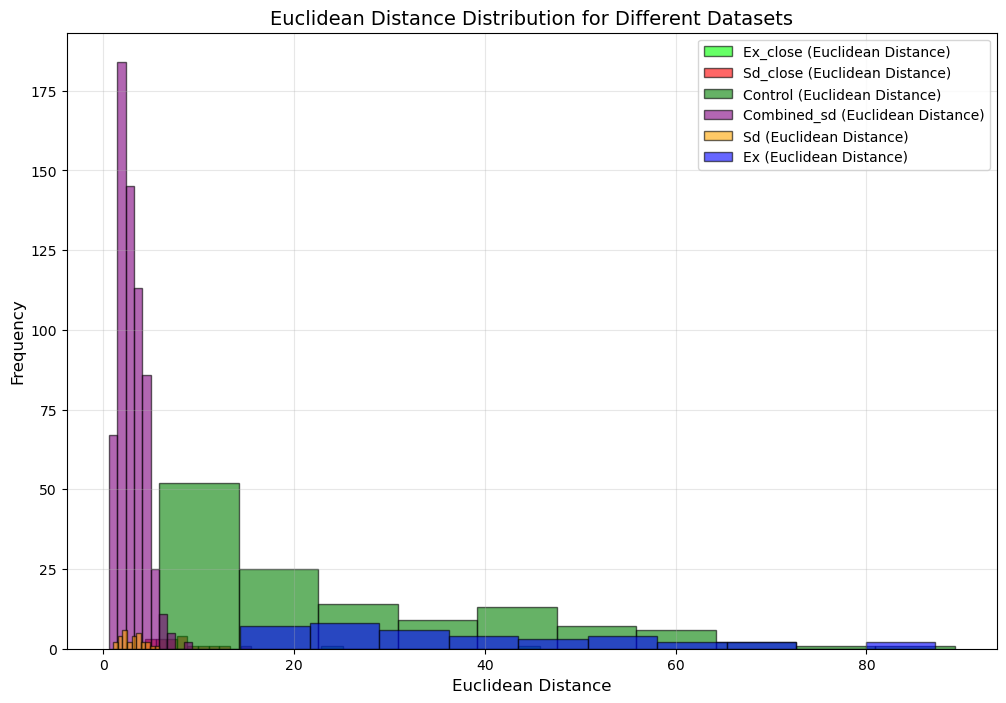

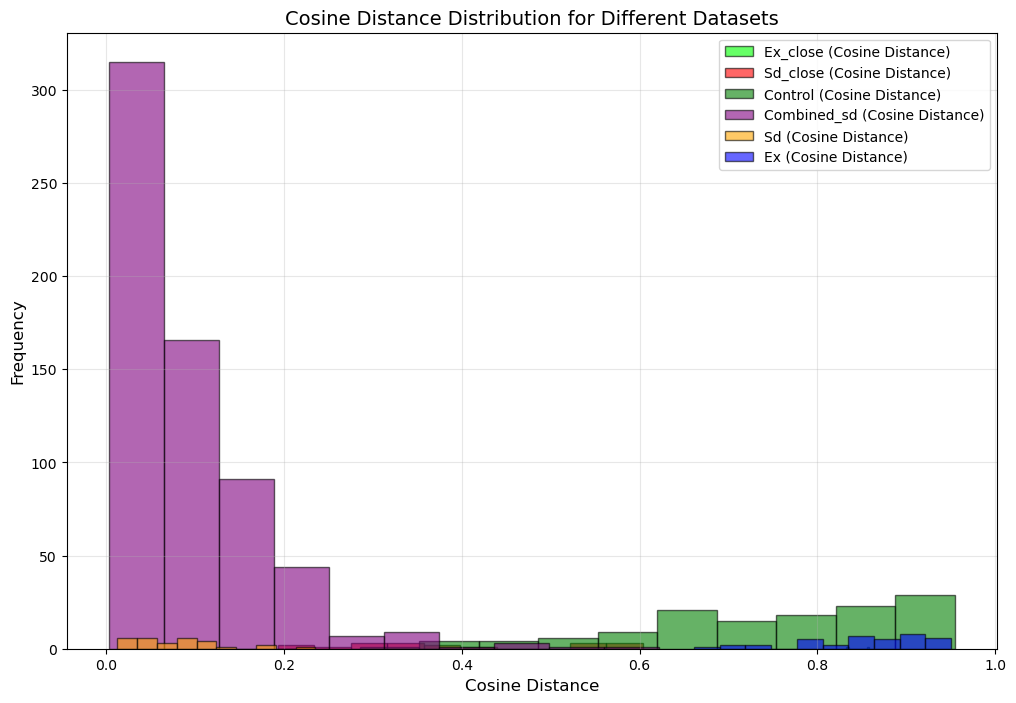

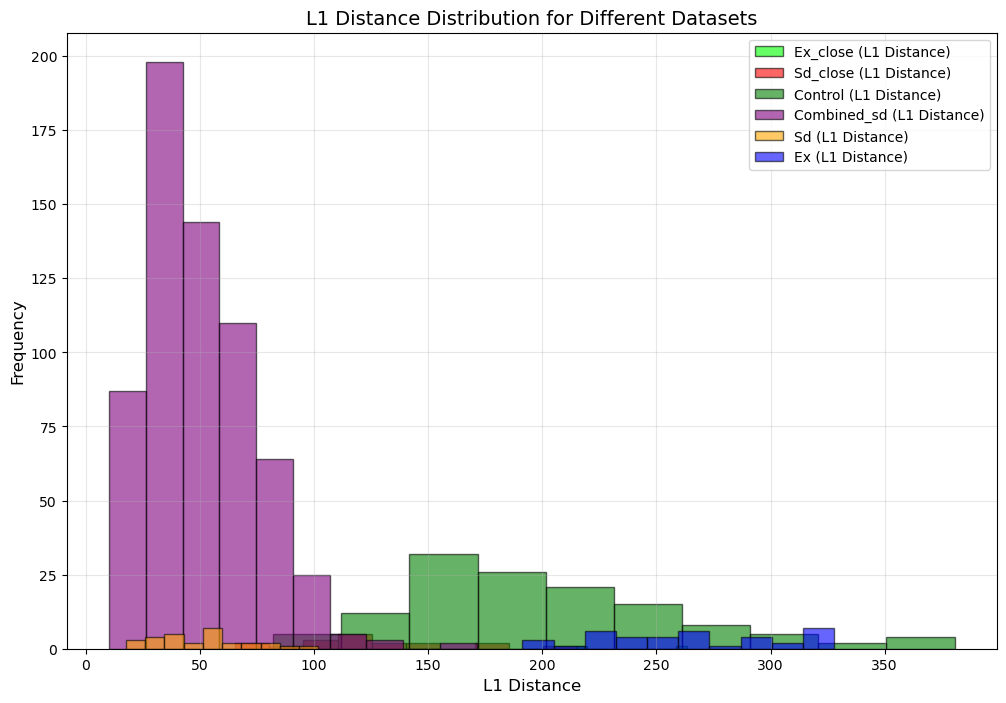

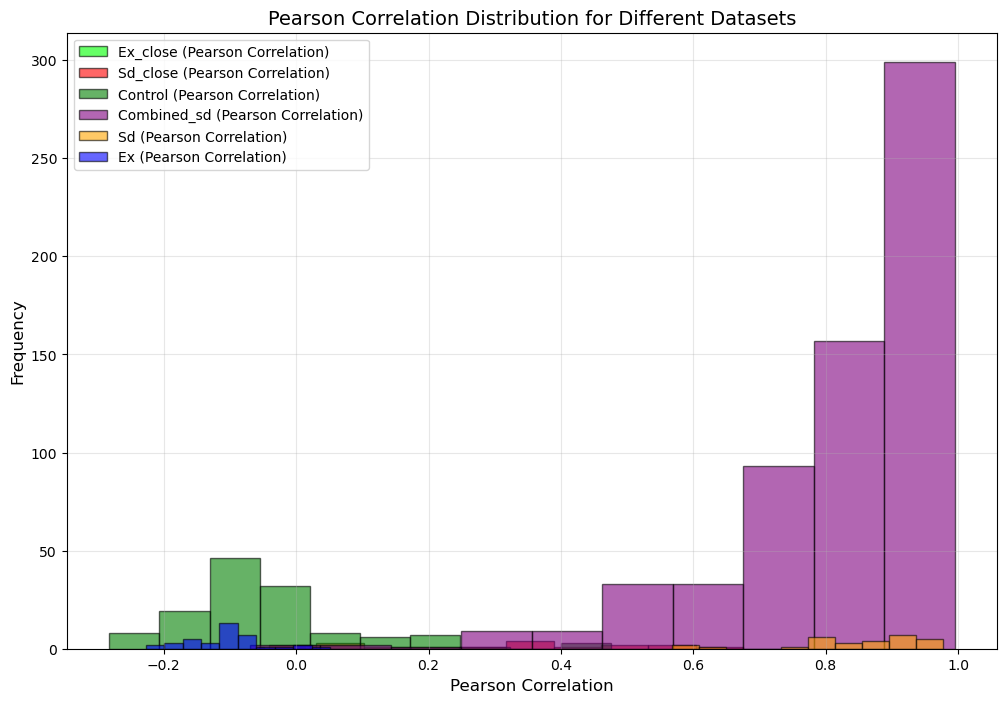

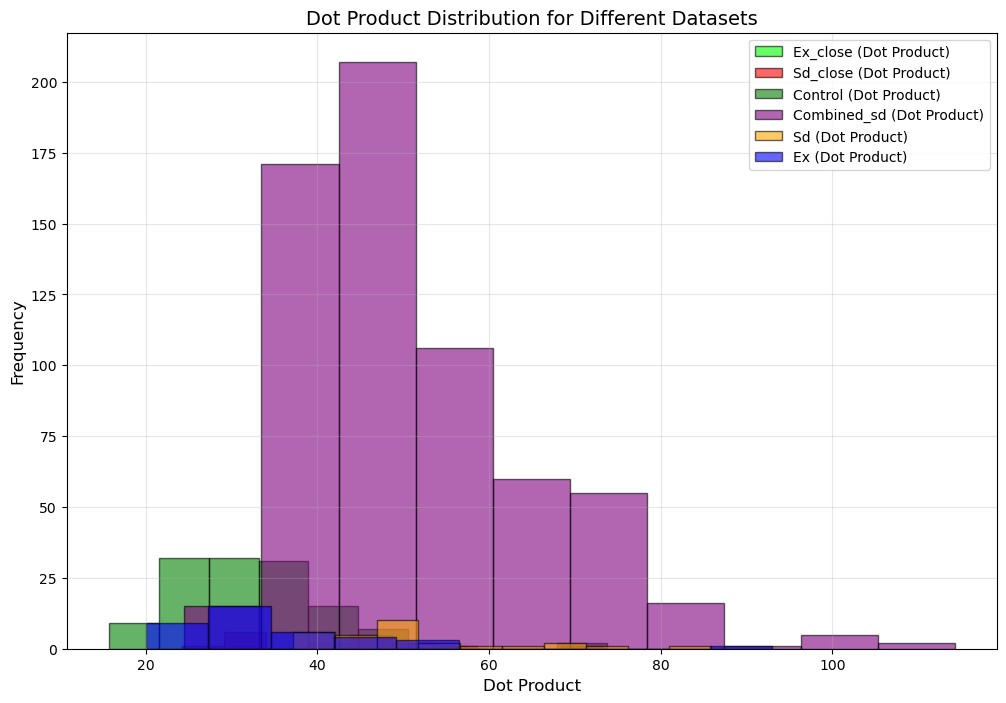

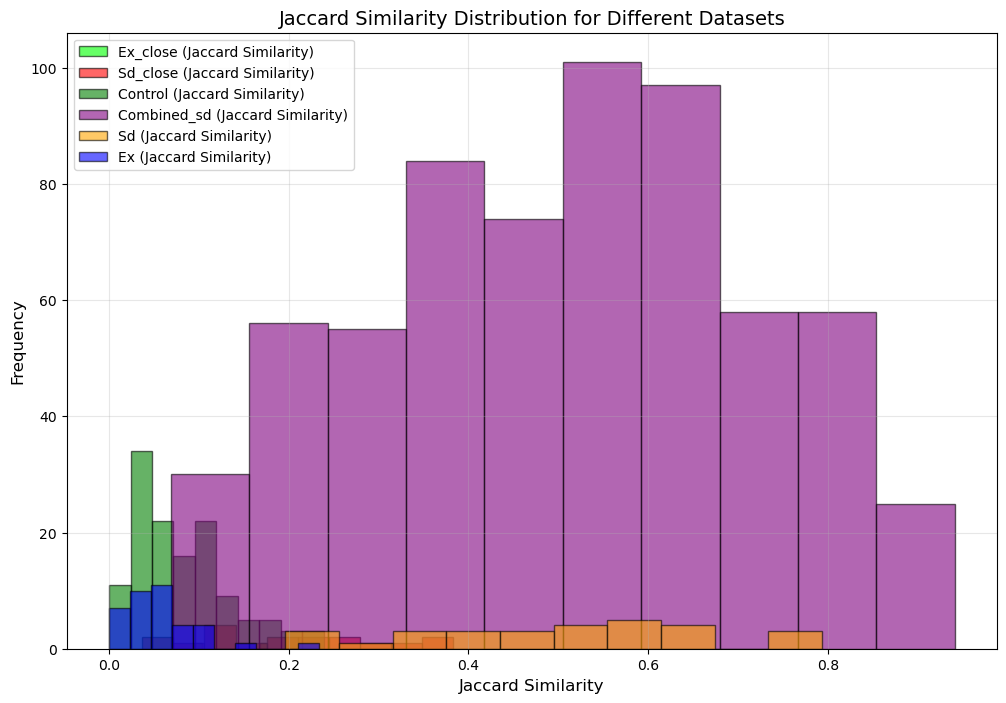

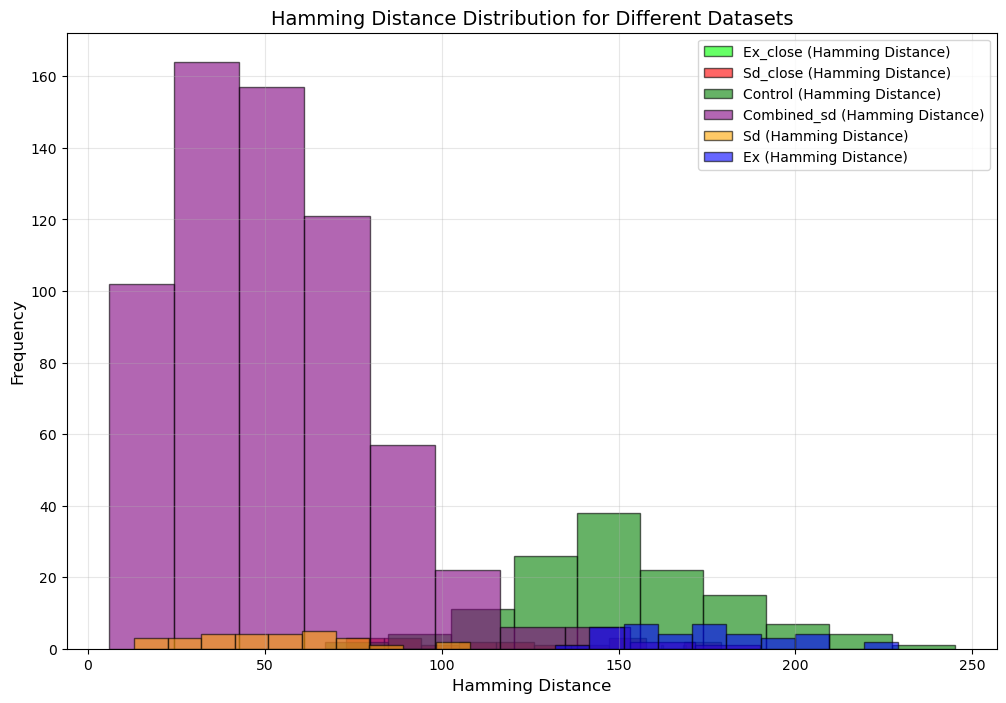

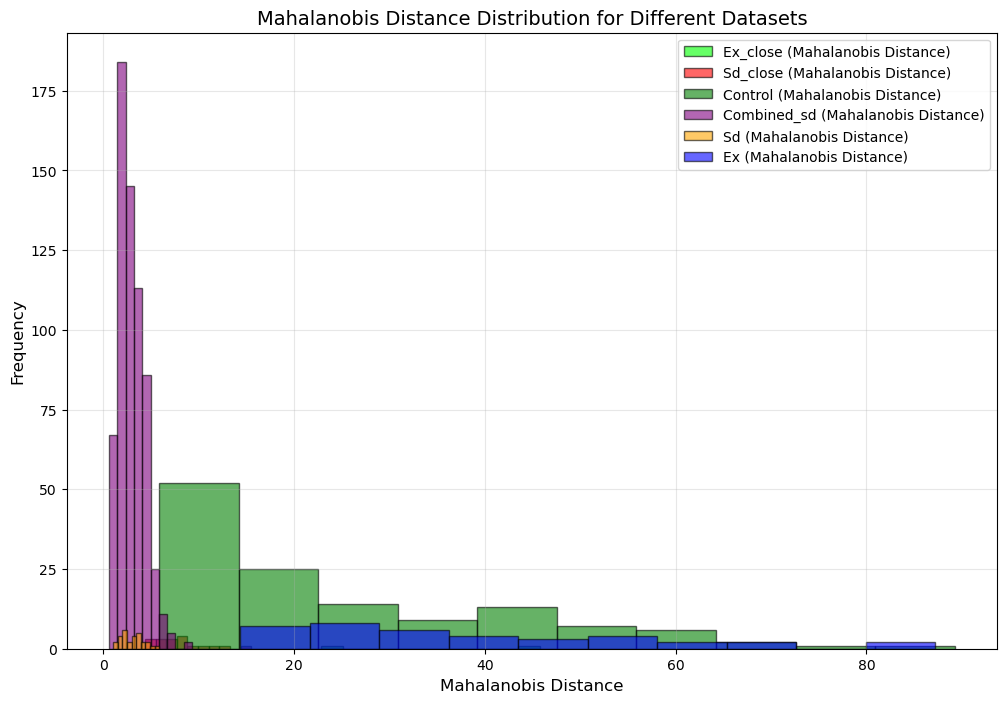

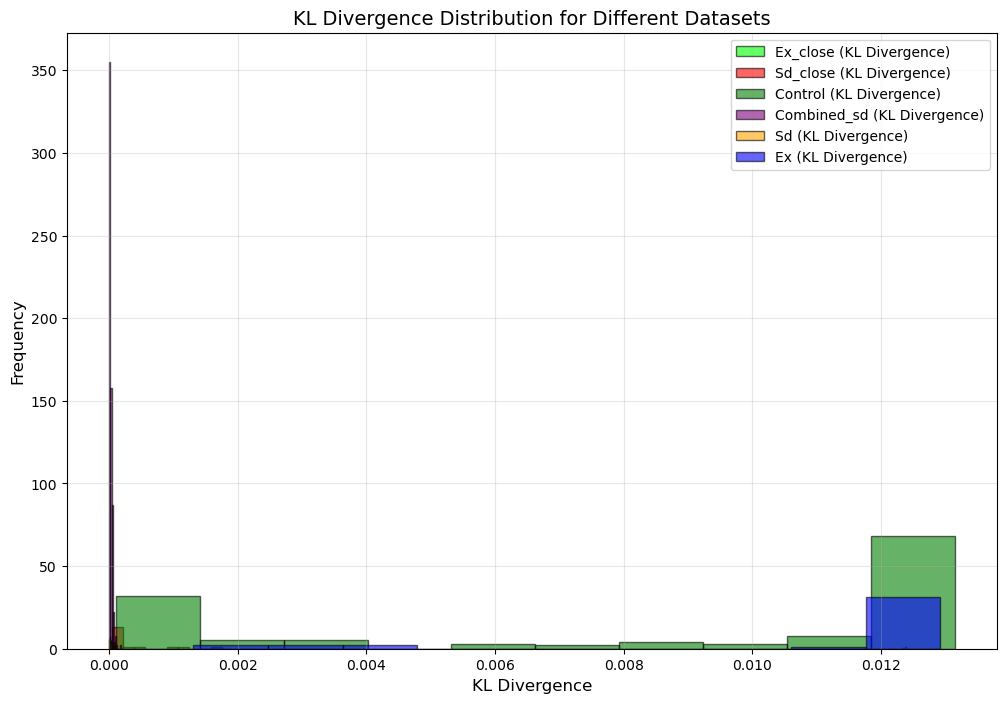

In [49]:
import matplotlib.pyplot as plt

# Metrics dictionary
datasets = {
    "ex_close": ex_close_metrics,
    "sd_close": sd_close_metrics,
    "control": cond_metrics,
    "combined_sd": combined_sd_metrics,
    "sd": sd_metrics,
    "ex": ex_metrics
}

# Metrics to plot
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance",
    "KL Divergence"
]

# Define colors for each dataset
colors = {
    "ex_close": "lime",
    "sd_close": "red",
    "control": "green",
    "combined_sd": "purple",
    "sd": "orange",
    "ex": "blue"
}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, metrics_dict in datasets.items():
        if metric_name in metrics_dict:  # Check if the metric exists
            values = metrics_dict[metric_name]
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


# greatest finding here is when i did mahalolan from point to point I understood that, its just euclidean so if i don't do mean, mahlolan just act as euclidean.

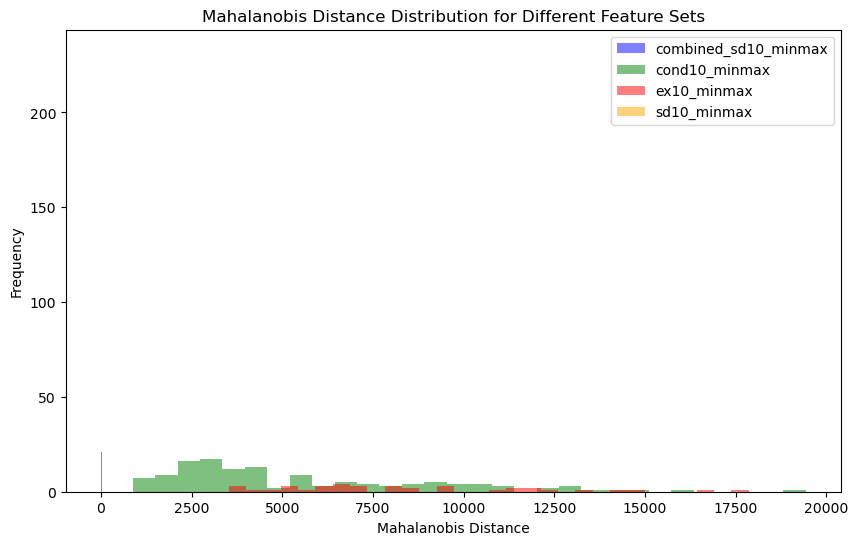

In [68]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def calculate_mahalanobis_distances(features, mean_vector, cov_inv):
    """
    Calculate Mahalanobis distances for the given feature set.
    
    Parameters:
    - features (torch.Tensor): The feature set of shape [N, 512], where N is the number of feature vectors.
    - mean_vector (torch.Tensor): The mean vector of the distribution to compare against (shape [512]).
    - cov_inv (torch.Tensor): The inverse covariance matrix of the distribution (shape [512, 512]).
    
    Returns:
    - mahalanobis_distances (List): List of Mahalanobis distances for each feature vector.
    """
    mahalanobis_distances = []
    
    for i in range(features.shape[0]):  # Iterate over all feature vectors in the set
        feature_vector = features[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Compute the Mahalanobis distance
        delta = feature_vector.flatten() - mean_vector  # Difference from the mean
        distance = torch.sqrt(torch.dot(delta, torch.matmul(cov_inv, delta)))  # Mahalanobis distance
        mahalanobis_distances.append(distance.item())  # Convert to scalar and append
        
    return mahalanobis_distances


# Calculate mean and covariance matrix of the combined feature vectors (using combined_sd10_minmax as an example)
mean_vector = torch.mean(combined_sd10_minmax, dim=0)  # Mean vector of combined_sd10_minmax
covariance_matrix = torch.cov(combined_sd10_minmax.T)  # Covariance matrix of combined_sd10_minmax
epsilon = 1e-6  # Stabilization constant
covariance_matrix += torch.eye(covariance_matrix.size(0), device=combined_sd10_minmax.device) * epsilon  # Stabilize
cov_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Calculate Mahalanobis distances for each feature set
combined_sd10_distances = calculate_mahalanobis_distances(combined_sd10_minmax, mean_vector, cov_inv)
cond10_distances = calculate_mahalanobis_distances(cond10_minmax, mean_vector, cov_inv)
ex10_distances = calculate_mahalanobis_distances(ex10_minmax, mean_vector, cov_inv)
sd10_distances = calculate_mahalanobis_distances(sd10_minmax, mean_vector, cov_inv)

# Plotting the Mahalanobis distances
plt.figure(figsize=(10, 6))

# Plot each group
plt.hist(combined_sd10_distances, bins=30, alpha=0.5, label="combined_sd10_minmax", color='blue')
plt.hist(cond10_distances, bins=30, alpha=0.5, label="cond10_minmax", color='green')
plt.hist(ex10_distances, bins=30, alpha=0.5, label="ex10_minmax", color='red')
plt.hist(sd10_distances, bins=30, alpha=0.5, label="sd10_minmax", color='orange')

# Labels and title
plt.title("Mahalanobis Distance Distribution for Different Feature Sets")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

# Show the plot
plt.show()


# added control day 7 instead of day 10

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def d7_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Compute covariance matrix for Mahalanobis distance (for day10 features)
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day7_feats_minmaxed, dim=0)  # Mean vector
    covariance_matrix = torch.cov(day7_feats_minmaxed.T)  # Covariance matrix
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
    covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        #train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day7_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day7_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day7_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day7_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.flatten(), train_day7_feats.flatten()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day7_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day7_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10, dim=1)  # Predicted distribution
        actual_probs = F.softmax(train_day7_feats, dim=1)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [18]:
d7_metrics = d7_metrics(model, cond7_minmax, cond10_minmax)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_metrics(model, day7_feats_minmaxed, day10_feats_minmaxed):
    """
    Compute metrics between day 7 and day 10 features using a given model.
    
    Args:
        model: The trained PyTorch model.
        day7_feats_minmaxed (torch.Tensor): Features from day 7 after min-max scaling. Shape: [N, 512].
        day10_feats_minmaxed (torch.Tensor): Features from day 10 after min-max scaling. Shape: [N, 512].
        
    Returns:
        metrics (dict): A dictionary containing lists of metrics for each feature vector.
    """
    device = next(model.parameters()).device  # Ensure the tensors are on the same device as the model
    
    # Ensure inputs are on the correct device
    day7_feats_minmaxed = day7_feats_minmaxed.to(device)
    day10_feats_minmaxed = day10_feats_minmaxed.to(device)
    
    # Initialize the MSE loss function
    mse_loss_fn = nn.MSELoss()
    
    # Lists to store metrics
    mse_values = []
    euclidean_distances = []
    cosine_distances = []
    l1_distances = []
    pearson_correlations = []
    dot_products = []
    jaccard_similarities = []
    hamming_distances = []
    mahalanobis_distances = []
    kl_divergences = []
    
    # Compute covariance matrix for Mahalanobis distance (for day10 features)
    epsilon = 1e-6  # Stabilization constant for invertibility
    mean_vector = torch.mean(day10_feats_minmaxed, dim=0)  # Mean vector
    covariance_matrix = torch.cov(day10_feats_minmaxed.T)  # Covariance matrix
    covariance_matrix += torch.eye(covariance_matrix.size(0), device=device) * epsilon  # Stabilize
    covariance_matrix_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix
    
    # Loop through each feature vector
    for i in range(day7_feats_minmaxed.shape[0]):
        train_day7_feats = day7_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        train_day10_feats = day10_feats_minmaxed[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Get prediction
        with torch.no_grad():
            predicted_day10 = model(train_day7_feats)
        
        # Compute MSE
        mse = mse_loss_fn(predicted_day10, train_day10_feats).item()
        mse_values.append(mse)
        
        # Compute Euclidean distance
        euclidean_distance = torch.norm(predicted_day10 - train_day10_feats, p=2).item()
        euclidean_distances.append(euclidean_distance)
        
        # Compute Cosine distance
        cosine_distance = 1 - F.cosine_similarity(predicted_day10, train_day10_feats, dim=1).item()
        cosine_distances.append(cosine_distance)
        
        # Compute L1 distance
        l1_distance = torch.norm(predicted_day10 - train_day10_feats, p=1).item()
        l1_distances.append(l1_distance)
        
        # Compute Pearson Correlation
        combined = torch.stack((predicted_day10.flatten(), train_day10_feats.flatten()), dim=0)  # Shape: [2, N]
        pearson_corr_matrix = torch.corrcoef(combined)  # Correlation matrix of shape [2, 2]
        pearson_corr = pearson_corr_matrix[0, 1]  # Extract correlation between the two variables
        pearson_correlations.append(pearson_corr.item())
        
        # Compute Inner Product (Dot Product)
        dot_product = torch.dot(predicted_day10.flatten(), train_day10_feats.flatten()).item()
        dot_products.append(dot_product)
        
        # Compute Jaccard Similarity (thresholding features to binary)
        bin_pred = (predicted_day10.flatten() > 0.5).int()
        bin_true = (train_day10_feats.flatten() > 0.5).int()
        intersection = (bin_pred & bin_true).sum().item()
        union = (bin_pred | bin_true).sum().item()
        jaccard_similarity = intersection / union if union > 0 else 0
        jaccard_similarities.append(jaccard_similarity)
        
        # Compute Hamming Distance (binary representation)
        hamming_distance = (bin_pred != bin_true).sum().item()
        hamming_distances.append(hamming_distance)
        
        # Compute Mahalanobis Distance
        delta = (predicted_day10.flatten() - mean_vector)  # Difference from mean
        mahalanobis_distance = torch.sqrt(torch.dot(delta, torch.matmul(covariance_matrix_inv, delta))).item()
        mahalanobis_distances.append(mahalanobis_distance)
        
        # Compute KL Divergence
        pred_probs = F.softmax(predicted_day10, dim=1)  # Predicted distribution
        actual_probs = F.softmax(train_day10_feats, dim=1)  # Actual distribution
        kl_div = F.kl_div(pred_probs.log(), actual_probs, reduction='batchmean').item()  # KL divergence
        kl_divergences.append(kl_div)
    
    # Return metrics as a dictionary
    metrics = {
        "MSE": mse_values,
        "Euclidean Distance": euclidean_distances,
        "Cosine Distance": cosine_distances,
        "L1 Distance": l1_distances,
        "Pearson Correlation": pearson_correlations,
        "Dot Product": dot_products,
        "Jaccard Similarity": jaccard_similarities,
        "Hamming Distance": hamming_distances,
        "Mahalanobis Distance": mahalanobis_distances,
        "KL Divergence": kl_divergences
    }
    return metrics


In [20]:
ex_close_metrics = compute_metrics(model, ex7_close_minmax, ex10_close_minmax)
sd_close_metrics = compute_metrics(model, sd7_close_minmax, sd10_close_minmax)
#cond_metrics = compute_metrics(model, cond7_minmax, cond10_minmax)
combined_sd_metrics = compute_metrics(model, combined_sd7_minmax, combined_sd10_minmax)
sd_metrics = compute_metrics(model, sd7_minmax, sd10_minmax)
ex_metrics = compute_metrics(model, ex7_minmax, ex10_minmax)

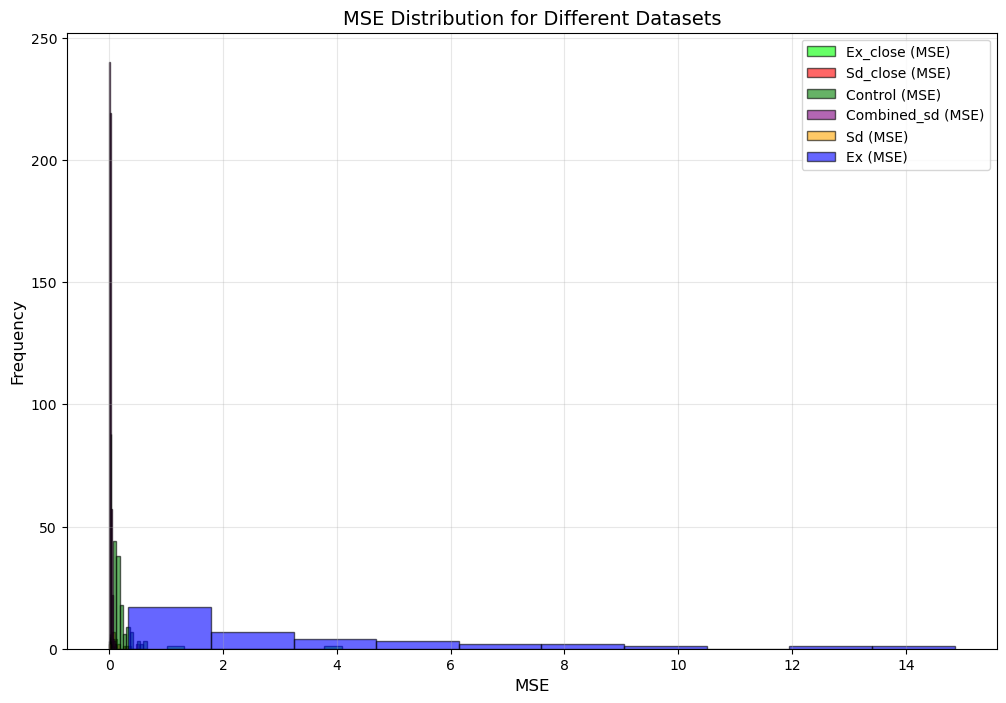

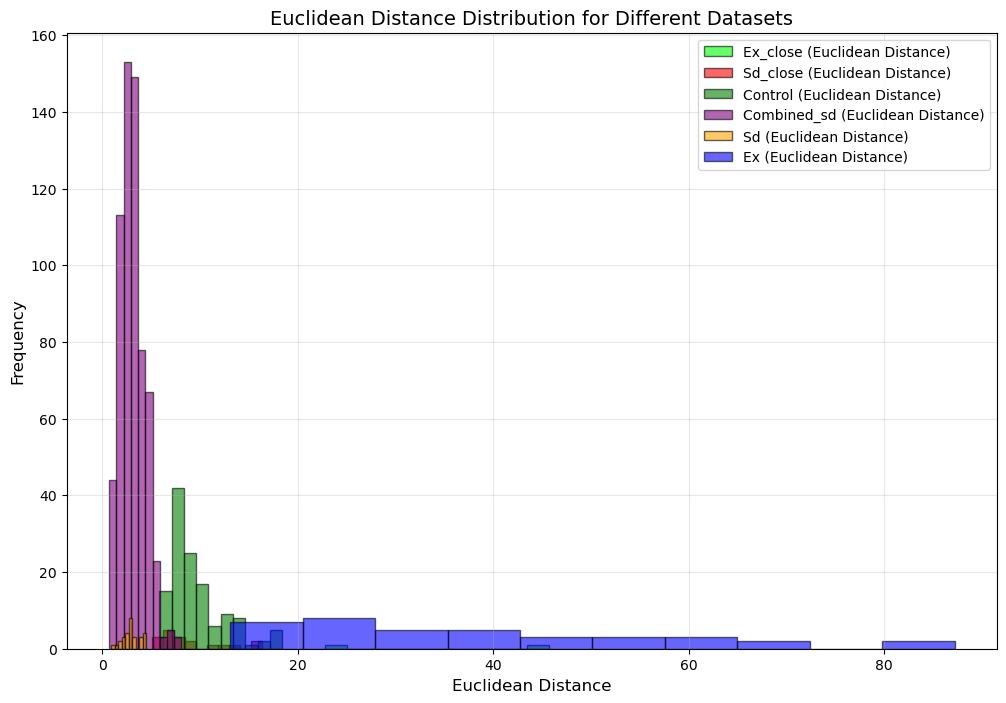

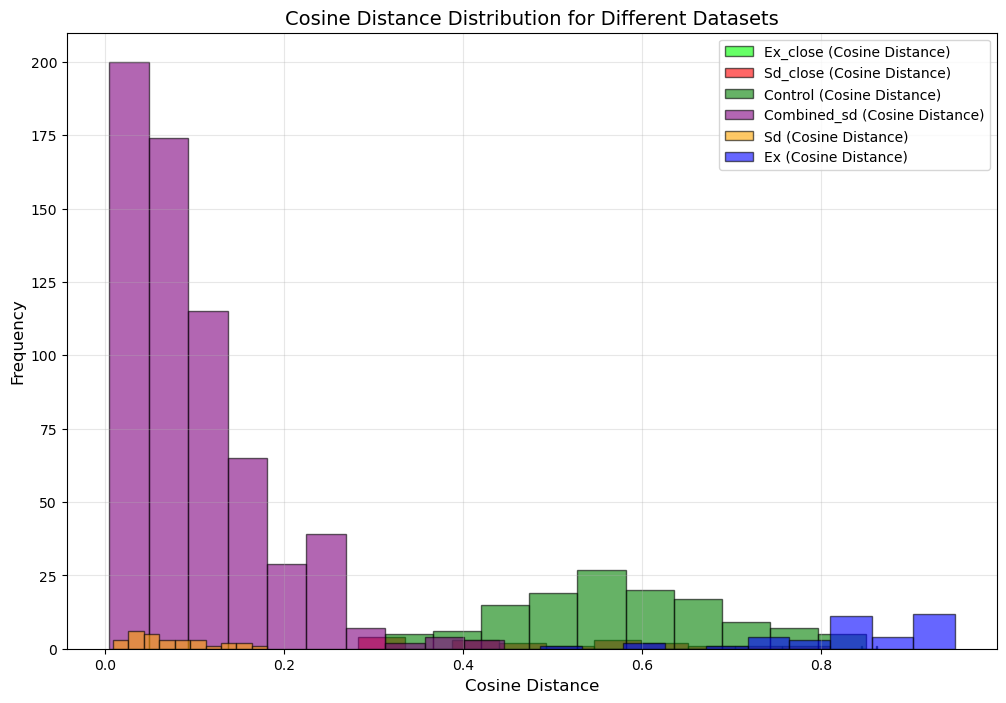

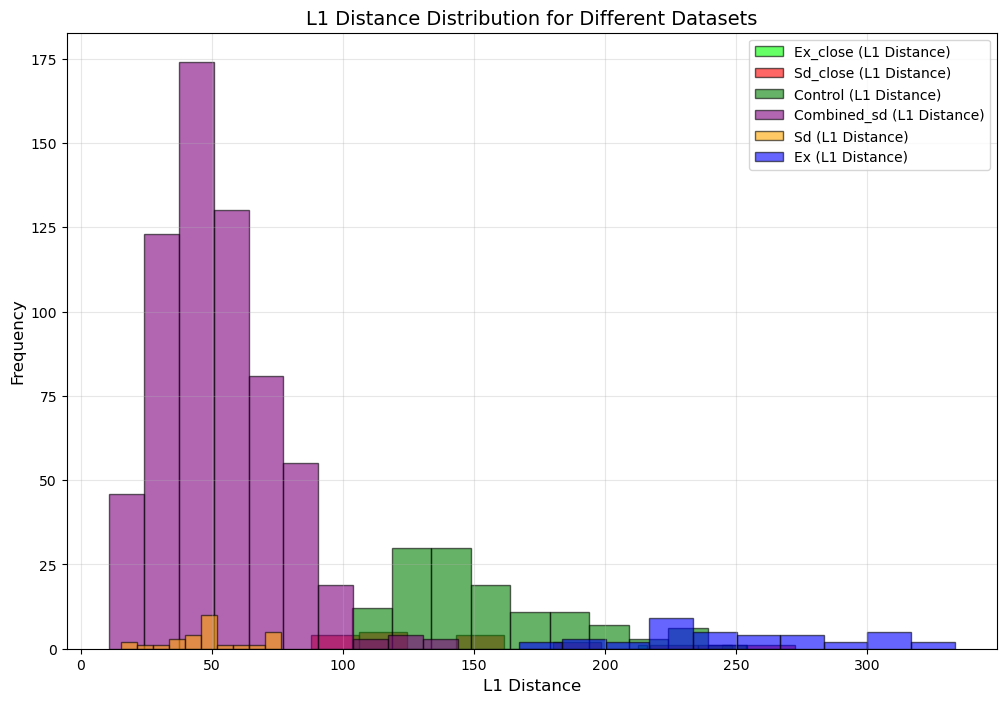

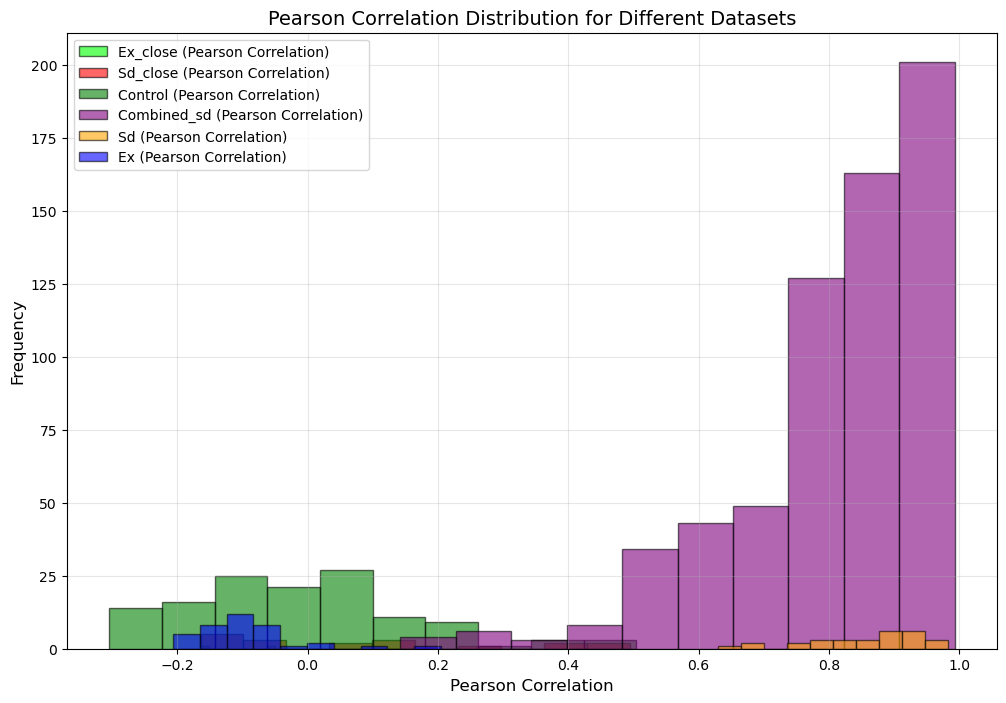

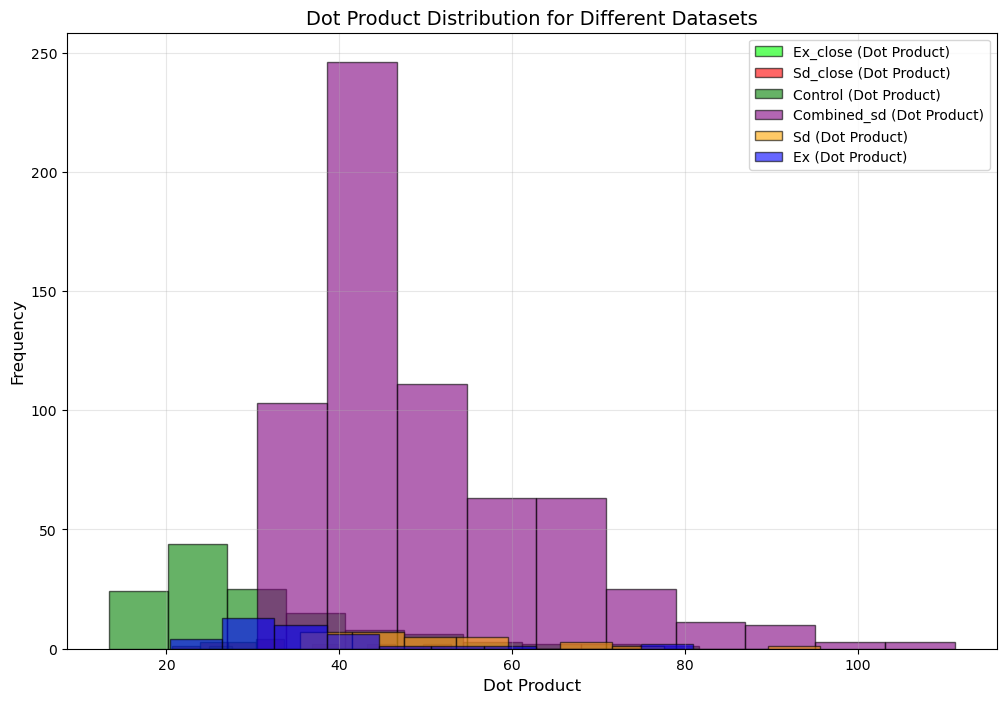

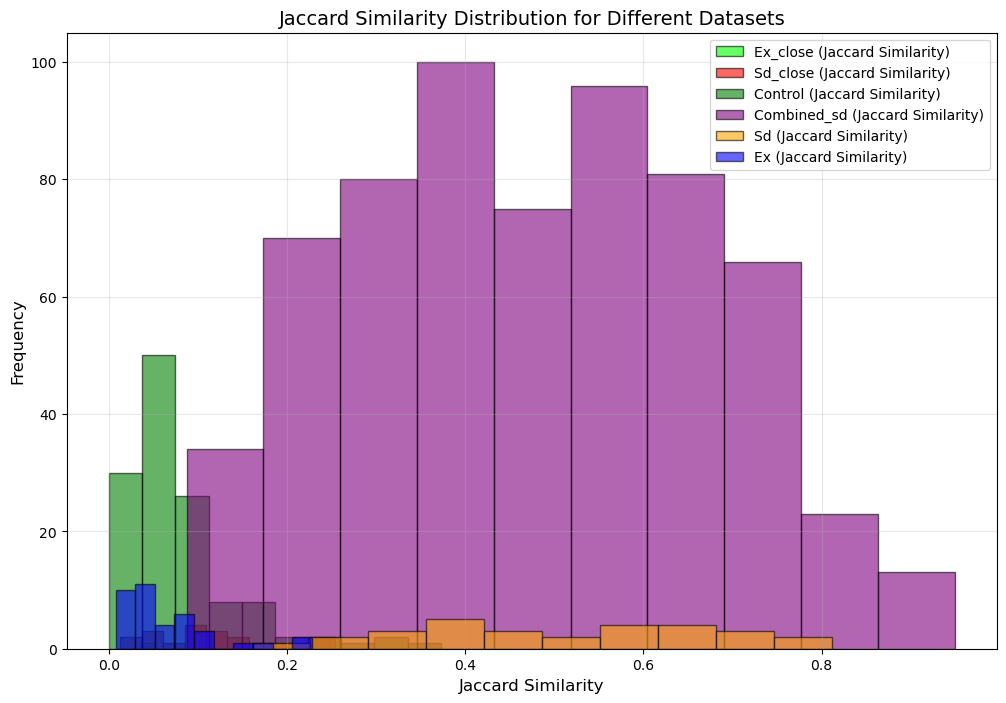

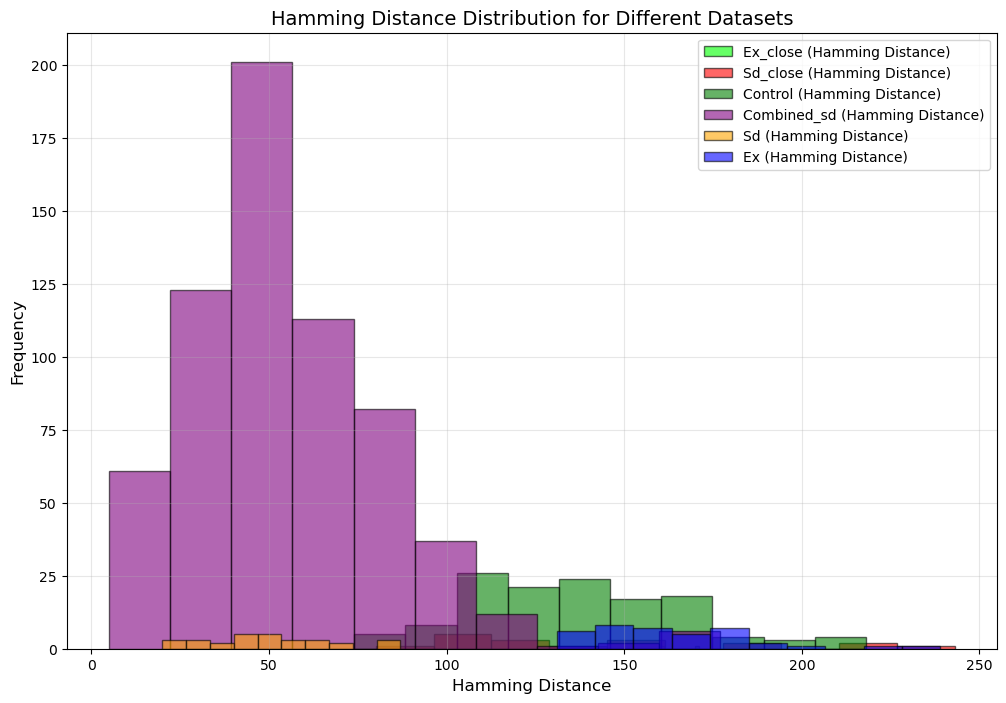

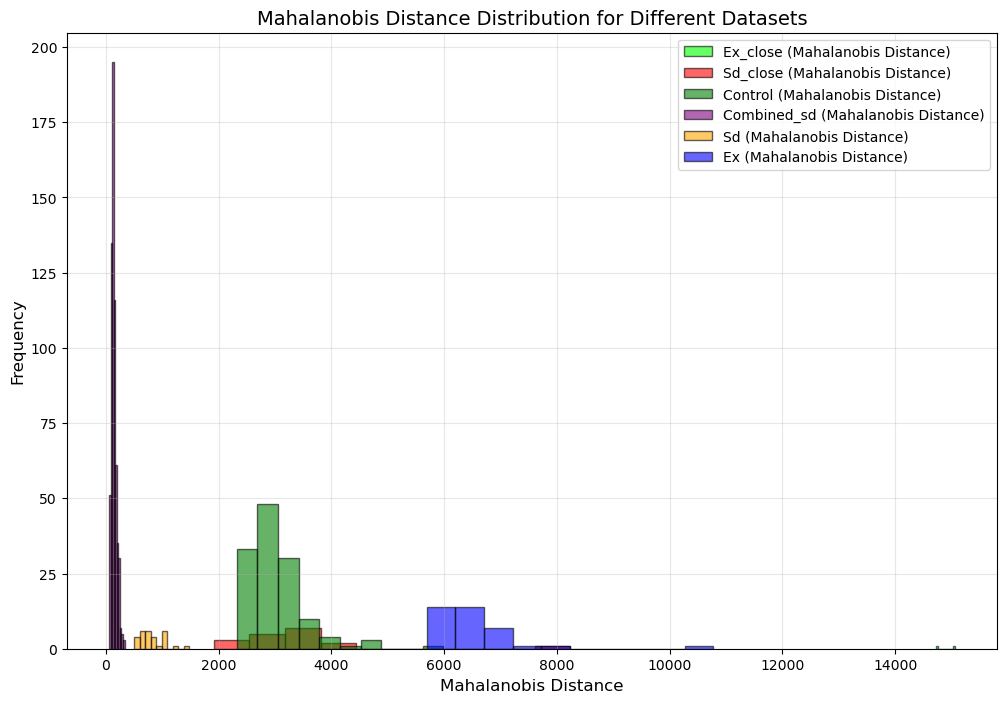

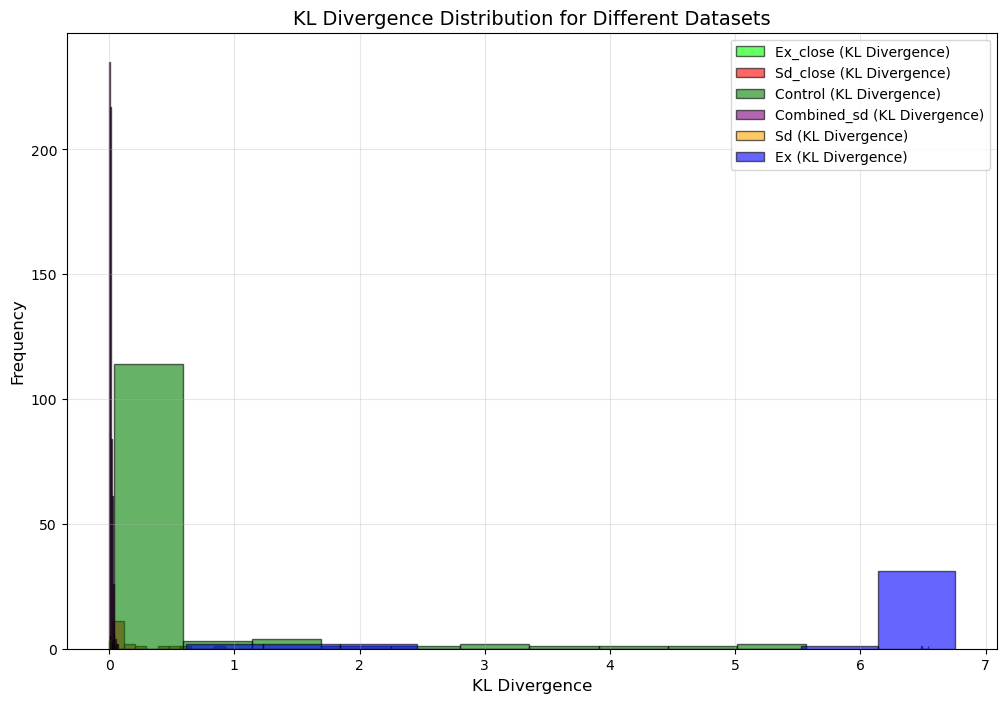

In [21]:
import matplotlib.pyplot as plt

# Metrics dictionary
datasets = {
    "ex_close": ex_close_metrics,
    "sd_close": sd_close_metrics,
    "control": d7_metrics,
    "combined_sd": combined_sd_metrics,
    "sd": sd_metrics,
    "ex": ex_metrics
}

# Metrics to plot
metrics = [
    "MSE",
    "Euclidean Distance",
    "Cosine Distance",
    "L1 Distance",
    "Pearson Correlation",
    "Dot Product",
    "Jaccard Similarity",
    "Hamming Distance",
    "Mahalanobis Distance",
    "KL Divergence"
]

# Define colors for each dataset
colors = {
    "ex_close": "lime",
    "sd_close": "red",
    "control": "green",
    "combined_sd": "purple",
    "sd": "orange",
    "ex": "blue"
}

# Plotting function
def plot_metric_distribution(metric_name, bins=20):
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset
    for dataset_name, metrics_dict in datasets.items():
        if metric_name in metrics_dict:  # Check if the metric exists
            values = metrics_dict[metric_name]
            plt.hist(
                values,
                bins=bins,
                alpha=0.6,
                label=f"{dataset_name.capitalize()} ({metric_name})",
                color=colors[dataset_name],
                edgecolor="black"
            )
    
    # Customize plot
    plt.title(f"{metric_name} Distribution for Different Datasets", fontsize=14)
    plt.xlabel(metric_name, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

# Plot distributions for all metrics
for metric in metrics:
    plot_metric_distribution(metric, bins=10)


In [22]:
# d7 included only mahanlolan

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def calculate_mahalanobis_distances(features, mean_vector, cov_inv):
    """
    Calculate Mahalanobis distances for the given feature set.
    
    Parameters:
    - features (torch.Tensor): The feature set of shape [N, 512], where N is the number of feature vectors.
    - mean_vector (torch.Tensor): The mean vector of the distribution to compare against (shape [512]).
    - cov_inv (torch.Tensor): The inverse covariance matrix of the distribution (shape [512, 512]).
    
    Returns:
    - mahalanobis_distances (List): List of Mahalanobis distances for each feature vector.
    """
    mahalanobis_distances = []
    
    for i in range(features.shape[0]):  # Iterate over all feature vectors in the set
        feature_vector = features[i].unsqueeze(0)  # Shape: [1, 512]
        
        # Compute the Mahalanobis distance
        delta = feature_vector.flatten() - mean_vector  # Difference from the mean
        distance = torch.sqrt(torch.dot(delta, torch.matmul(cov_inv, delta)))  # Mahalanobis distance
        mahalanobis_distances.append(distance.item())  # Convert to scalar and append
        
    return mahalanobis_distances


# Calculate mean and covariance matrix of the combined feature vectors (using combined_sd10_minmax as an example)
mean_vector = torch.mean(combined_sd10_minmax, dim=0)  # Mean vector of combined_sd10_minmax
covariance_matrix = torch.cov(combined_sd10_minmax.T)  # Covariance matrix of combined_sd10_minmax
epsilon = 1e-6  # Stabilization constant
covariance_matrix += torch.eye(covariance_matrix.size(0), device=combined_sd10_minmax.device) * epsilon  # Stabilize
cov_inv = torch.inverse(covariance_matrix)  # Inverse covariance matrix

# Calculate Mahalanobis distances for each feature set
combined_sd10_distances = calculate_mahalanobis_distances(combined_sd10_minmax, mean_vector, cov_inv)
d7_distances = calculate_mahalanobis_distances(cond7_minmax, mean_vector, cov_inv)
ex10_distances = calculate_mahalanobis_distances(ex10_minmax, mean_vector, cov_inv)
sd10_distances = calculate_mahalanobis_distances(sd10_minmax, mean_vector, cov_inv)



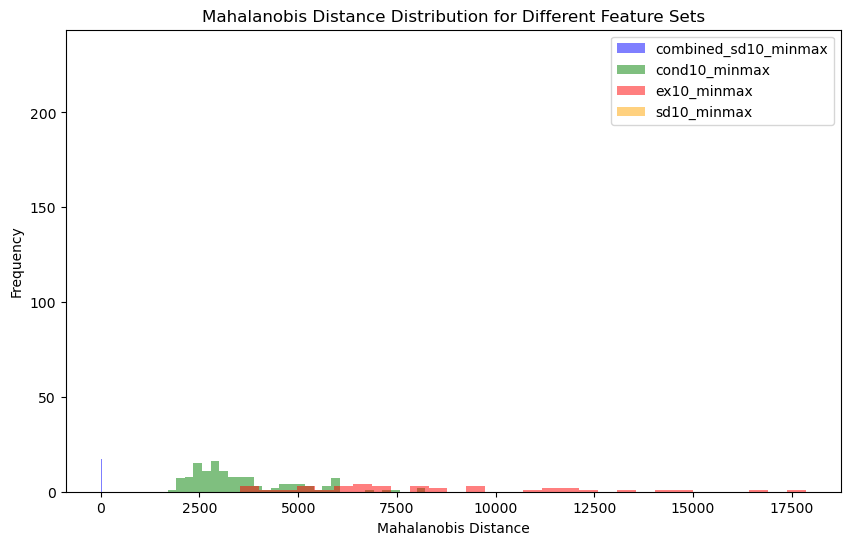

In [25]:
# Plotting the Mahalanobis distances
plt.figure(figsize=(10, 6))

# Plot each group
plt.hist(combined_sd10_distances, bins=30, alpha=0.5, label="combined_sd10_minmax", color='blue')
plt.hist(d7_distances, bins=30, alpha=0.5, label="cond10_minmax", color='green')
plt.hist(ex10_distances, bins=30, alpha=0.5, label="ex10_minmax", color='red')
plt.hist(sd10_distances, bins=30, alpha=0.5, label="sd10_minmax", color='orange')

# Labels and title
plt.title("Mahalanobis Distance Distribution for Different Feature Sets")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.legend(loc='upper right')

# Show the plot
plt.show()
